In [1]:
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label
%matplotlib inline

In [2]:
from skimage.feature import hog

# Define a function to return HOG features and visualization
def get_hog_features(img, orient=9, pix_per_cell=8, cell_per_block=2, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), 
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  visualise=True, feature_vector=feature_vec)
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), 
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  visualise=False, feature_vector=feature_vec)
        return features

In [3]:
# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
def bin_spatial(img, color_space='YCrCb', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

In [4]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    #return rhist, ghist, bhist, bin_centers, hist_features
    return hist_features

In [5]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    # bounding boxes
    bboxes = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            # spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            spatial_features = bin_spatial(subimg)
            #hist_features = []

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((hist_features, hog_features, spatial_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                bboxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return draw_img, bboxes

In [6]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def get_heatmap(img, bbox_list):
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = add_heat(heat,bbox_list)
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    return heatmap

In [7]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [8]:
dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

/opt/anaconda/3.6/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


2 cars found


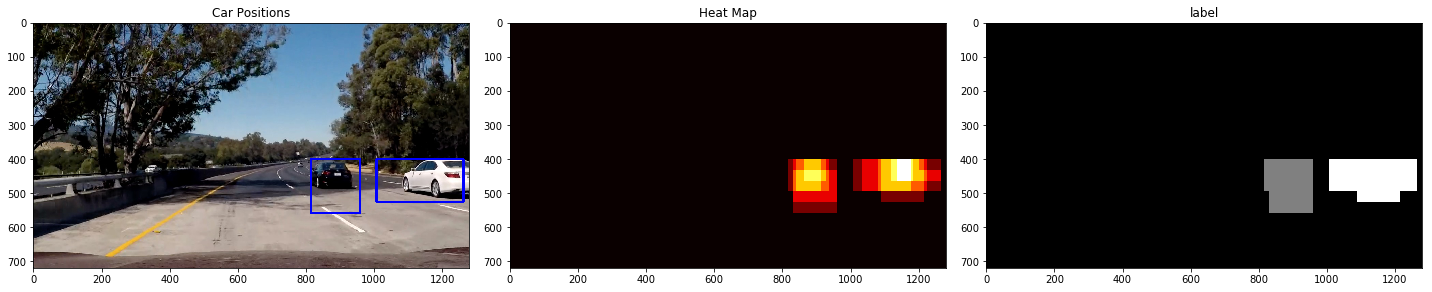

2 cars found


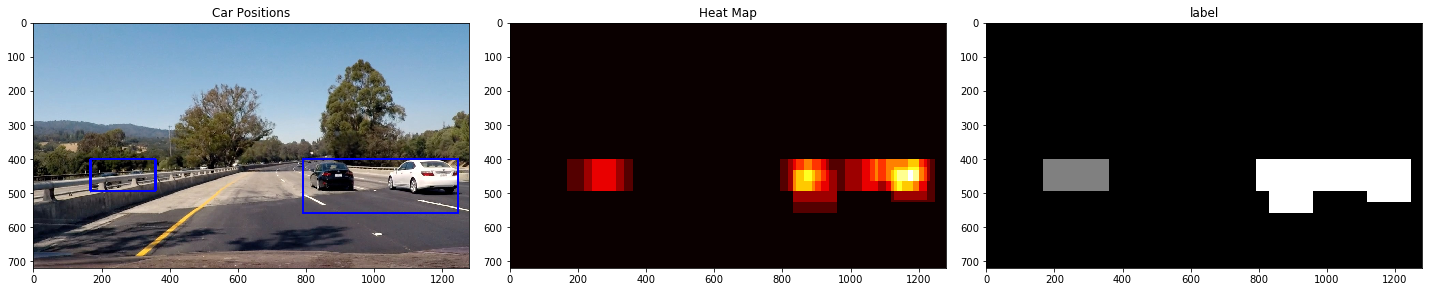

2 cars found


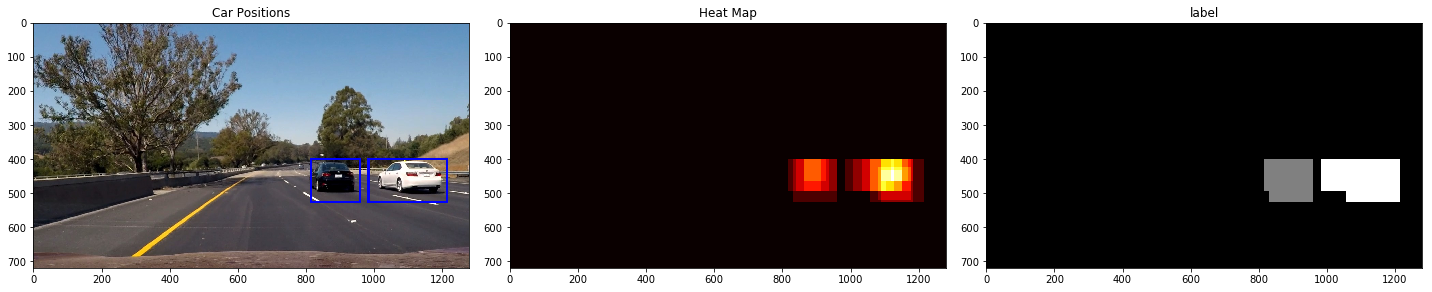

4 cars found


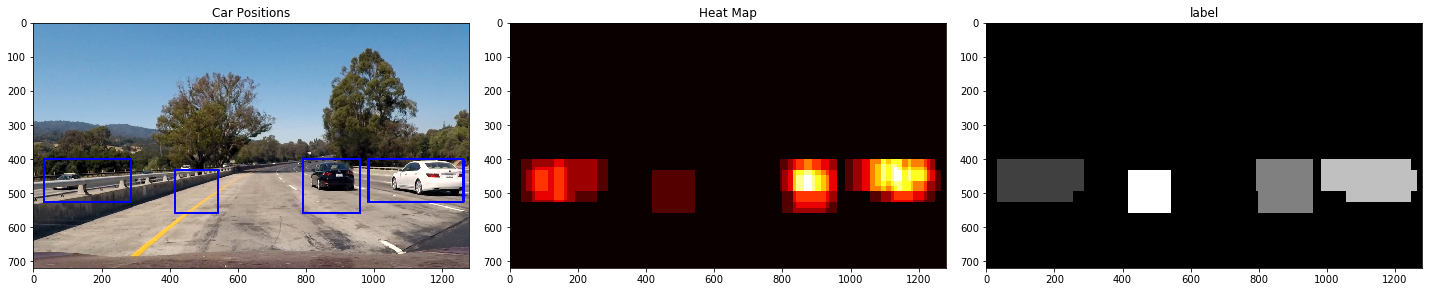

0 cars found


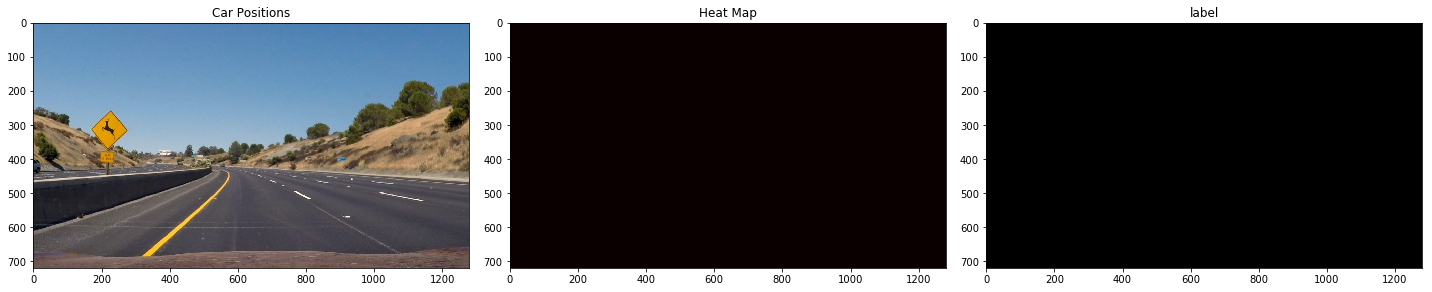

1 cars found


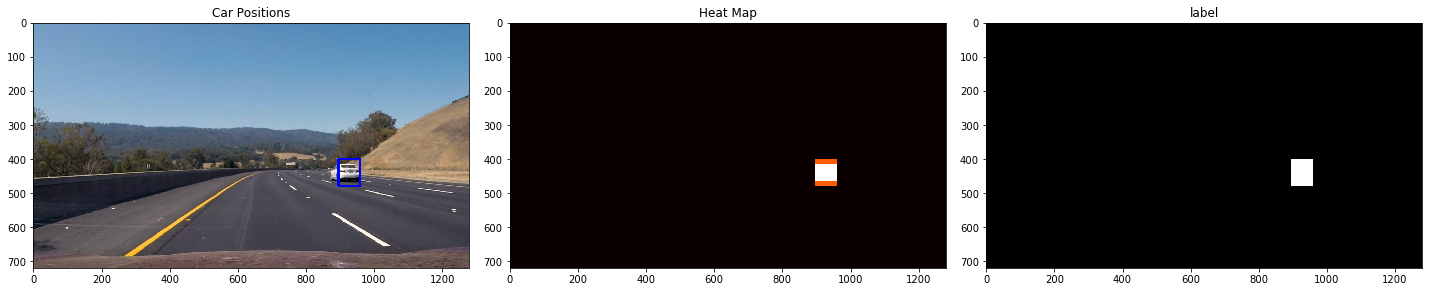

In [9]:
imglist = glob.glob('./test_images/*.jpg')

ystart = 400
ystop = 656
scale = 2.0

for imgname in imglist:
    img = mpimg.imread(imgname)
    
    scale = 2.0
    out_img, bboxes1 = find_cars(img, ystart, ystop, scale, svc, 
                                X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    scale = 1.0
    out_img, bboxes2 = find_cars(img, ystart, ystop, scale, svc, 
                                X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    scale = 1.5
    out_img, bboxes3 = find_cars(img, ystart, ystop, scale, svc, 
                                X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    bboxes = bboxes1 + bboxes2 + bboxes3
    
    heatmap = get_heatmap(out_img, bboxes)
    
    labels = label(heatmap)
    
    out_img = draw_labeled_bboxes(np.copy(img), labels)
    
    fig = plt.figure(figsize=(20, 10))
    
    plt.subplot(131)
    plt.imshow(out_img)
    plt.title('Car Positions')
    
    plt.subplot(132)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    
    plt.subplot(133)
    print(labels[1], 'cars found')
    plt.imshow(labels[0], cmap='gray')
    plt.title('label')
    
    fig.tight_layout()
    plt.show()

In [10]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [11]:
#global deti
#deti = 0

#def cutsave(img, bbox, outputname):
#    subim = img[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0], :]
#    cv2.imwrite(outputname, subim)
#    print("saving {}, size {}, bbox {}, imsize {}.".format(outputname, subim.shape, bbox, img.shape))

def find_cars_mulscale(img):
    #global deti
    scale = 2.0
    out_img, bboxes1 = find_cars(img, ystart, ystop, scale, svc, 
                                X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    scale = 1.2
    out_img, bboxes2 = find_cars(img, ystart, ystop, scale, svc, 
                                X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    scale = 1.6
    out_img, bboxes3 = find_cars(img, ystart, ystop, scale, svc, 
                                X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    bboxes = bboxes1 + bboxes2 + bboxes3
    
    #for bbox in bboxes:
        #cutsave(np.copy(img), bbox, "./temp/det{:0>4}.jpg".format(deti))
        #deti += 1
    
    heatmap = get_heatmap(out_img, bboxes)
    
    labels = label(heatmap)
    
    out_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return out_img

In [12]:
video_output = 'project_video_output.mp4'
clip1 = VideoFileClip("./project_video.mp4")
out_clip = clip1.fl_image(find_cars_mulscale) #NOTE: this function expects color images!!
%time out_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


  0%|          | 4/1261 [00:03<18:35,  1.13it/s]

saving ./temp/det0000.jpg, size (76, 76, 3), bbox ((0, 419), (76, 495)), imsize (720, 1280, 3).


  3%|▎         | 41/1261 [00:36<18:02,  1.13it/s]

saving ./temp/det0001.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).


 10%|█         | 132/1261 [01:57<16:58,  1.11it/s]

saving ./temp/det0002.jpg, size (76, 76, 3), bbox ((134, 419), (210, 495)), imsize (720, 1280, 3).
saving ./temp/det0003.jpg, size (76, 76, 3), bbox ((268, 400), (344, 476)), imsize (720, 1280, 3).


 11%|█         | 133/1261 [01:58<17:03,  1.10it/s]

saving ./temp/det0004.jpg, size (76, 76, 3), bbox ((115, 419), (191, 495)), imsize (720, 1280, 3).
saving ./temp/det0005.jpg, size (76, 76, 3), bbox ((268, 400), (344, 476)), imsize (720, 1280, 3).


 11%|█         | 135/1261 [02:00<17:11,  1.09it/s]

saving ./temp/det0006.jpg, size (76, 76, 3), bbox ((76, 400), (152, 476)), imsize (720, 1280, 3).


 11%|█         | 136/1261 [02:01<17:25,  1.08it/s]

saving ./temp/det0007.jpg, size (76, 76, 3), bbox ((57, 400), (133, 476)), imsize (720, 1280, 3).


 11%|█         | 137/1261 [02:02<17:12,  1.09it/s]

saving ./temp/det0008.jpg, size (76, 76, 3), bbox ((38, 400), (114, 476)), imsize (720, 1280, 3).


 11%|█         | 140/1261 [02:05<17:06,  1.09it/s]

saving ./temp/det0009.jpg, size (76, 76, 3), bbox ((134, 400), (210, 476)), imsize (720, 1280, 3).
saving ./temp/det0010.jpg, size (76, 76, 3), bbox ((134, 419), (210, 495)), imsize (720, 1280, 3).


 11%|█▏        | 142/1261 [02:07<16:59,  1.10it/s]

saving ./temp/det0011.jpg, size (76, 76, 3), bbox ((76, 419), (152, 495)), imsize (720, 1280, 3).
saving ./temp/det0012.jpg, size (76, 76, 3), bbox ((96, 400), (172, 476)), imsize (720, 1280, 3).
saving ./temp/det0013.jpg, size (76, 76, 3), bbox ((96, 419), (172, 495)), imsize (720, 1280, 3).


 11%|█▏        | 143/1261 [02:07<17:04,  1.09it/s]

saving ./temp/det0014.jpg, size (102, 102, 3), bbox ((25, 400), (127, 502)), imsize (720, 1280, 3).


 11%|█▏        | 144/1261 [02:08<16:52,  1.10it/s]

saving ./temp/det0015.jpg, size (76, 76, 3), bbox ((0, 400), (76, 476)), imsize (720, 1280, 3).


 13%|█▎        | 159/1261 [02:22<16:45,  1.10it/s]

saving ./temp/det0016.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 1280, 3).


 13%|█▎        | 160/1261 [02:23<16:39,  1.10it/s]

saving ./temp/det0017.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 13%|█▎        | 161/1261 [02:24<16:29,  1.11it/s]

saving ./temp/det0018.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det0019.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 13%|█▎        | 162/1261 [02:25<16:36,  1.10it/s]

saving ./temp/det0020.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det0021.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 13%|█▎        | 163/1261 [02:26<16:31,  1.11it/s]

saving ./temp/det0022.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det0023.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 13%|█▎        | 164/1261 [02:26<16:33,  1.10it/s]

saving ./temp/det0024.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det0025.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 13%|█▎        | 165/1261 [02:27<16:33,  1.10it/s]

saving ./temp/det0026.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det0027.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).
saving ./temp/det0028.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 13%|█▎        | 166/1261 [02:28<16:32,  1.10it/s]

saving ./temp/det0029.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det0030.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det0031.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det0032.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 1280, 3).
saving ./temp/det0033.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).
saving ./temp/det0034.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 13%|█▎        | 167/1261 [02:29<16:33,  1.10it/s]

saving ./temp/det0035.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det0036.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det0037.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det0038.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 13%|█▎        | 168/1261 [02:30<16:29,  1.10it/s]

saving ./temp/det0039.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det0040.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det0041.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 13%|█▎        | 169/1261 [02:31<16:35,  1.10it/s]

saving ./temp/det0042.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det0043.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det0044.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).
saving ./temp/det0045.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 13%|█▎        | 170/1261 [02:32<16:49,  1.08it/s]

saving ./temp/det0046.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0047.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det0048.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det0049.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).
saving ./temp/det0050.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 14%|█▎        | 171/1261 [02:33<16:50,  1.08it/s]

saving ./temp/det0051.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det0052.jpg, size (76, 76, 3), bbox ((1152, 419), (1228, 495)), imsize (720, 1280, 3).
saving ./temp/det0053.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det0054.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).
saving ./temp/det0055.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 14%|█▎        | 172/1261 [02:34<16:43,  1.09it/s]

saving ./temp/det0056.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0057.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det0058.jpg, size (76, 76, 3), bbox ((1152, 419), (1228, 495)), imsize (720, 1280, 3).
saving ./temp/det0059.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det0060.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).
saving ./temp/det0061.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 14%|█▎        | 173/1261 [02:35<16:51,  1.08it/s]

saving ./temp/det0062.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det0063.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0064.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det0065.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det0066.jpg, size (76, 76, 3), bbox ((1152, 419), (1228, 495)), imsize (720, 1280, 3).
saving ./temp/det0067.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det0068.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).
saving ./temp/det0069.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 14%|█▍        | 174/1261 [02:36<16:41,  1.09it/s]

saving ./temp/det0070.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det0071.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0072.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det0073.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det0074.jpg, size (76, 76, 3), bbox ((1152, 419), (1228, 495)), imsize (720, 1280, 3).
saving ./temp/det0075.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det0076.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).
saving ./temp/det0077.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 14%|█▍        | 175/1261 [02:37<16:30,  1.10it/s]

saving ./temp/det0078.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det0079.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0080.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det0081.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det0082.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).
saving ./temp/det0083.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 14%|█▍        | 176/1261 [02:37<16:32,  1.09it/s]

saving ./temp/det0084.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det0085.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0086.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det0087.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det0088.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).
saving ./temp/det0089.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 14%|█▍        | 177/1261 [02:38<16:40,  1.08it/s]

saving ./temp/det0090.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det0091.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0092.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det0093.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det0094.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).
saving ./temp/det0095.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).
saving ./temp/det0096.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 14%|█▍        | 178/1261 [02:39<16:40,  1.08it/s]

saving ./temp/det0097.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det0098.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0099.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det0100.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det0101.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det0102.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).
saving ./temp/det0103.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 14%|█▍        | 179/1261 [02:40<16:44,  1.08it/s]

saving ./temp/det0104.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det0105.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0106.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0107.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det0108.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det0109.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det0110.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).
saving ./temp/det0111.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 14%|█▍        | 180/1261 [02:41<16:30,  1.09it/s]

saving ./temp/det0112.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det0113.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0114.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0115.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det0116.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det0117.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det0118.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).
saving ./temp/det0119.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 14%|█▍        | 181/1261 [02:42<16:23,  1.10it/s]

saving ./temp/det0120.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det0121.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0122.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0123.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det0124.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det0125.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).
saving ./temp/det0126.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 14%|█▍        | 182/1261 [02:43<16:39,  1.08it/s]

saving ./temp/det0127.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det0128.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0129.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0130.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det0131.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det0132.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).
saving ./temp/det0133.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).
saving ./temp/det0134.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 15%|█▍        | 183/1261 [02:44<16:53,  1.06it/s]

saving ./temp/det0135.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det0136.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0137.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0138.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det0139.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).
saving ./temp/det0140.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).
saving ./temp/det0141.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 15%|█▍        | 184/1261 [02:45<16:45,  1.07it/s]

saving ./temp/det0142.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det0143.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det0144.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0145.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0146.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det0147.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).
saving ./temp/det0148.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).
saving ./temp/det0149.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 15%|█▍        | 185/1261 [02:46<16:38,  1.08it/s]

saving ./temp/det0150.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det0151.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0152.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0153.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det0154.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).
saving ./temp/det0155.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).


 15%|█▍        | 186/1261 [02:47<16:31,  1.08it/s]

saving ./temp/det0156.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det0157.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det0158.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0159.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0160.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det0161.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).
saving ./temp/det0162.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).


 15%|█▍        | 187/1261 [02:48<16:32,  1.08it/s]

saving ./temp/det0163.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det0164.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det0165.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0166.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0167.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det0168.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).
saving ./temp/det0169.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).


 15%|█▍        | 188/1261 [02:49<16:33,  1.08it/s]

saving ./temp/det0170.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det0171.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det0172.jpg, size (76, 76, 3), bbox ((1036, 438), (1112, 514)), imsize (720, 1280, 3).
saving ./temp/det0173.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0174.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0175.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det0176.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).
saving ./temp/det0177.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).


 15%|█▍        | 189/1261 [02:50<16:26,  1.09it/s]

saving ./temp/det0178.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det0179.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det0180.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0181.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0182.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det0183.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).
saving ./temp/det0184.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).
saving ./temp/det0185.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).


 15%|█▌        | 190/1261 [02:50<16:16,  1.10it/s]

saving ./temp/det0186.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det0187.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det0188.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0189.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det0190.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0191.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det0192.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).
saving ./temp/det0193.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).
saving ./temp/det0194.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).


 15%|█▌        | 191/1261 [02:51<16:07,  1.11it/s]

saving ./temp/det0195.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det0196.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det0197.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det0198.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0199.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det0200.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0201.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det0202.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).
saving ./temp/det0203.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).
saving ./temp/det0204.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), ims

 15%|█▌        | 192/1261 [02:52<16:15,  1.10it/s]

saving ./temp/det0205.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det0206.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det0207.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det0208.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det0209.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0210.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det0211.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0212.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det0213.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).
saving ./temp/det0214.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsiz

 15%|█▌        | 193/1261 [02:53<16:06,  1.10it/s]

saving ./temp/det0216.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det0217.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det0218.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det0219.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0220.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det0221.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0222.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det0223.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).
saving ./temp/det0224.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).
saving ./temp/det0225.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsiz

 15%|█▌        | 194/1261 [02:54<16:14,  1.10it/s]

saving ./temp/det0226.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det0227.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det0228.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det0229.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0230.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0231.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).
saving ./temp/det0232.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).
saving ./temp/det0233.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).


 15%|█▌        | 195/1261 [02:55<16:13,  1.09it/s]

saving ./temp/det0234.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det0235.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det0236.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det0237.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0238.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0239.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).
saving ./temp/det0240.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).
saving ./temp/det0241.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).


 16%|█▌        | 196/1261 [02:56<16:22,  1.08it/s]

saving ./temp/det0242.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det0243.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det0244.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det0245.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0246.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0247.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).
saving ./temp/det0248.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).
saving ./temp/det0249.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).


 16%|█▌        | 197/1261 [02:57<16:16,  1.09it/s]

saving ./temp/det0250.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det0251.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det0252.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0253.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0254.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).
saving ./temp/det0255.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).
saving ./temp/det0256.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).


 16%|█▌        | 198/1261 [02:58<16:26,  1.08it/s]

saving ./temp/det0257.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det0258.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det0259.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0260.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0261.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).
saving ./temp/det0262.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).
saving ./temp/det0263.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).


 16%|█▌        | 199/1261 [02:59<16:23,  1.08it/s]

saving ./temp/det0264.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det0265.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det0266.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det0267.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0268.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0269.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).
saving ./temp/det0270.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).


 16%|█▌        | 200/1261 [03:00<16:15,  1.09it/s]

saving ./temp/det0271.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det0272.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0273.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0274.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).
saving ./temp/det0275.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).


 16%|█▌        | 201/1261 [03:00<16:08,  1.09it/s]

saving ./temp/det0276.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det0277.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det0278.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0279.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0280.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).
saving ./temp/det0281.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).


 16%|█▌        | 202/1261 [03:01<16:13,  1.09it/s]

saving ./temp/det0282.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det0283.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det0284.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0285.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0286.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).
saving ./temp/det0287.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).


 16%|█▌        | 203/1261 [03:02<16:05,  1.10it/s]

saving ./temp/det0288.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det0289.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det0290.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0291.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0292.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).
saving ./temp/det0293.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).


 16%|█▌        | 204/1261 [03:03<16:15,  1.08it/s]

saving ./temp/det0294.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det0295.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det0296.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0297.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0298.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).
saving ./temp/det0299.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).


 16%|█▋        | 205/1261 [03:04<16:11,  1.09it/s]

saving ./temp/det0300.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det0301.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det0302.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0303.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0304.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).
saving ./temp/det0305.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).


 16%|█▋        | 206/1261 [03:05<16:13,  1.08it/s]

saving ./temp/det0306.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det0307.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det0308.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0309.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0310.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).
saving ./temp/det0311.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).


 16%|█▋        | 207/1261 [03:06<16:10,  1.09it/s]

saving ./temp/det0312.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det0313.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det0314.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0315.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0316.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).
saving ./temp/det0317.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).


 16%|█▋        | 208/1261 [03:07<16:05,  1.09it/s]

saving ./temp/det0318.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det0319.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det0320.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det0321.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0322.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).
saving ./temp/det0323.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).


 17%|█▋        | 209/1261 [03:08<16:00,  1.10it/s]

saving ./temp/det0324.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det0325.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det0326.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det0327.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0328.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).
saving ./temp/det0329.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).


 17%|█▋        | 210/1261 [03:09<15:58,  1.10it/s]

saving ./temp/det0330.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det0331.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det0332.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det0333.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0334.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).
saving ./temp/det0335.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).


 17%|█▋        | 211/1261 [03:10<16:03,  1.09it/s]

saving ./temp/det0336.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det0337.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det0338.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0339.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).
saving ./temp/det0340.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).


 17%|█▋        | 212/1261 [03:11<16:01,  1.09it/s]

saving ./temp/det0341.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det0342.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det0343.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0344.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det0345.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 1280, 3).
saving ./temp/det0346.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).
saving ./temp/det0347.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).


 17%|█▋        | 213/1261 [03:12<15:58,  1.09it/s]

saving ./temp/det0348.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det0349.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det0350.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0351.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det0352.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 1280, 3).
saving ./temp/det0353.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).
saving ./temp/det0354.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).


 17%|█▋        | 214/1261 [03:12<15:53,  1.10it/s]

saving ./temp/det0355.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det0356.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det0357.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0358.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det0359.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 1280, 3).
saving ./temp/det0360.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).
saving ./temp/det0361.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).


 17%|█▋        | 215/1261 [03:13<15:49,  1.10it/s]

saving ./temp/det0362.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det0363.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det0364.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det0365.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0366.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det0367.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 1280, 3).
saving ./temp/det0368.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).
saving ./temp/det0369.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).


 17%|█▋        | 216/1261 [03:14<15:47,  1.10it/s]

saving ./temp/det0370.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det0371.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det0372.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det0373.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0374.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det0375.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 1280, 3).
saving ./temp/det0376.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).
saving ./temp/det0377.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).


 17%|█▋        | 217/1261 [03:15<16:00,  1.09it/s]

saving ./temp/det0378.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det0379.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det0380.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det0381.jpg, size (76, 76, 3), bbox ((1075, 419), (1151, 495)), imsize (720, 1280, 3).
saving ./temp/det0382.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det0383.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0384.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det0385.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 1280, 3).
saving ./temp/det0386.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).
saving ./temp/det0387.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsiz

 17%|█▋        | 218/1261 [03:16<16:03,  1.08it/s]

saving ./temp/det0389.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det0390.jpg, size (76, 76, 3), bbox ((1075, 419), (1151, 495)), imsize (720, 1280, 3).
saving ./temp/det0391.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det0392.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0393.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 1280, 3).
saving ./temp/det0394.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).
saving ./temp/det0395.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).
saving ./temp/det0396.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).


 17%|█▋        | 219/1261 [03:17<16:01,  1.08it/s]

saving ./temp/det0397.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det0398.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det0399.jpg, size (76, 76, 3), bbox ((1075, 419), (1151, 495)), imsize (720, 1280, 3).
saving ./temp/det0400.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det0401.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0402.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det0403.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 1280, 3).
saving ./temp/det0404.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).
saving ./temp/det0405.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).
saving ./temp/det0406.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsiz

 17%|█▋        | 220/1261 [03:18<16:09,  1.07it/s]

saving ./temp/det0407.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det0408.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det0409.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det0410.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0411.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 1280, 3).
saving ./temp/det0412.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).
saving ./temp/det0413.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).


 18%|█▊        | 221/1261 [03:19<15:58,  1.09it/s]

saving ./temp/det0414.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det0415.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det0416.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det0417.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0418.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 1280, 3).
saving ./temp/det0419.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).
saving ./temp/det0420.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).


 18%|█▊        | 222/1261 [03:20<15:56,  1.09it/s]

saving ./temp/det0421.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det0422.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det0423.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det0424.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det0425.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0426.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 1280, 3).
saving ./temp/det0427.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).
saving ./temp/det0428.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).
saving ./temp/det0429.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 18%|█▊        | 223/1261 [03:21<16:02,  1.08it/s]

saving ./temp/det0430.jpg, size (76, 76, 3), bbox ((172, 400), (248, 476)), imsize (720, 1280, 3).
saving ./temp/det0431.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det0432.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det0433.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det0434.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0435.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 1280, 3).
saving ./temp/det0436.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).
saving ./temp/det0437.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).
saving ./temp/det0438.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 18%|█▊        | 224/1261 [03:22<15:53,  1.09it/s]

saving ./temp/det0439.jpg, size (76, 76, 3), bbox ((172, 400), (248, 476)), imsize (720, 1280, 3).
saving ./temp/det0440.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det0441.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det0442.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0443.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det0444.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det0445.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 1280, 3).
saving ./temp/det0446.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).
saving ./temp/det0447.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).
saving ./temp/det0448.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (7

 18%|█▊        | 225/1261 [03:23<15:43,  1.10it/s]

saving ./temp/det0449.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det0450.jpg, size (76, 76, 3), bbox ((153, 400), (229, 476)), imsize (720, 1280, 3).
saving ./temp/det0451.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det0452.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det0453.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 1280, 3).
saving ./temp/det0454.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).
saving ./temp/det0455.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 18%|█▊        | 226/1261 [03:23<15:45,  1.09it/s]

saving ./temp/det0456.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det0457.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det0458.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det0459.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det0460.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det0461.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 1280, 3).
saving ./temp/det0462.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).
saving ./temp/det0463.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).
saving ./temp/det0464.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 18%|█▊        | 227/1261 [03:24<15:40,  1.10it/s]

saving ./temp/det0465.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det0466.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det0467.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det0468.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det0469.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det0470.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det0471.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 1280, 3).
saving ./temp/det0472.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).
saving ./temp/det0473.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).
saving ./temp/det0474.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsiz

 18%|█▊        | 228/1261 [03:25<15:49,  1.09it/s]

saving ./temp/det0475.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det0476.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det0477.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det0478.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det0479.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det0480.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det0481.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 1280, 3).
saving ./temp/det0482.jpg, size (76, 76, 3), bbox ((1171, 438), (1247, 514)), imsize (720, 1280, 3).
saving ./temp/det0483.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).
saving ./temp/det0484.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize 

 18%|█▊        | 229/1261 [03:26<15:41,  1.10it/s]

saving ./temp/det0486.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det0487.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det0488.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det0489.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det0490.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det0491.jpg, size (76, 76, 3), bbox ((1152, 419), (1228, 495)), imsize (720, 1280, 3).
saving ./temp/det0492.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det0493.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).
saving ./temp/det0494.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).
saving ./temp/det0495.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsiz

 18%|█▊        | 230/1261 [03:27<15:47,  1.09it/s]

saving ./temp/det0496.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det0497.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det0498.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det0499.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det0500.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det0501.jpg, size (76, 76, 3), bbox ((1152, 419), (1228, 495)), imsize (720, 1280, 3).
saving ./temp/det0502.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det0503.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 1280, 3).
saving ./temp/det0504.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).
saving ./temp/det0505.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize 

 18%|█▊        | 231/1261 [03:28<15:43,  1.09it/s]

saving ./temp/det0507.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det0508.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det0509.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det0510.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det0511.jpg, size (76, 76, 3), bbox ((1152, 419), (1228, 495)), imsize (720, 1280, 3).
saving ./temp/det0512.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det0513.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).
saving ./temp/det0514.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).
saving ./temp/det0515.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 18%|█▊        | 232/1261 [03:29<15:48,  1.08it/s]

saving ./temp/det0516.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det0517.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det0518.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det0519.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det0520.jpg, size (76, 76, 3), bbox ((1152, 419), (1228, 495)), imsize (720, 1280, 3).
saving ./temp/det0521.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det0522.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).
saving ./temp/det0523.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).
saving ./temp/det0524.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 18%|█▊        | 233/1261 [03:30<15:45,  1.09it/s]

saving ./temp/det0525.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det0526.jpg, size (76, 76, 3), bbox ((0, 419), (76, 495)), imsize (720, 1280, 3).
saving ./temp/det0527.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det0528.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det0529.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det0530.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det0531.jpg, size (76, 76, 3), bbox ((1152, 419), (1228, 495)), imsize (720, 1280, 3).
saving ./temp/det0532.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det0533.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).
saving ./temp/det0534.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720,

 19%|█▊        | 234/1261 [03:31<15:38,  1.09it/s]

saving ./temp/det0536.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det0537.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det0538.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det0539.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det0540.jpg, size (76, 76, 3), bbox ((1152, 419), (1228, 495)), imsize (720, 1280, 3).
saving ./temp/det0541.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det0542.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).
saving ./temp/det0543.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).
saving ./temp/det0544.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 19%|█▊        | 235/1261 [03:32<15:39,  1.09it/s]

saving ./temp/det0545.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det0546.jpg, size (76, 76, 3), bbox ((172, 400), (248, 476)), imsize (720, 1280, 3).
saving ./temp/det0547.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det0548.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det0549.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det0550.jpg, size (76, 76, 3), bbox ((1152, 419), (1228, 495)), imsize (720, 1280, 3).
saving ./temp/det0551.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det0552.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).
saving ./temp/det0553.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).
saving ./temp/det0554.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize 

 19%|█▊        | 236/1261 [03:33<15:35,  1.10it/s]

saving ./temp/det0555.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det0556.jpg, size (76, 76, 3), bbox ((230, 400), (306, 476)), imsize (720, 1280, 3).
saving ./temp/det0557.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det0558.jpg, size (76, 76, 3), bbox ((1056, 419), (1132, 495)), imsize (720, 1280, 3).
saving ./temp/det0559.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det0560.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det0561.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det0562.jpg, size (76, 76, 3), bbox ((1152, 419), (1228, 495)), imsize (720, 1280, 3).
saving ./temp/det0563.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).
saving ./temp/det0564.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (7

 19%|█▉        | 237/1261 [03:33<15:31,  1.10it/s]

saving ./temp/det0567.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det0568.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det0569.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det0570.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det0571.jpg, size (76, 76, 3), bbox ((1152, 419), (1228, 495)), imsize (720, 1280, 3).
saving ./temp/det0572.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).
saving ./temp/det0573.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).
saving ./temp/det0574.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).
saving ./temp/det0575.jpg, size (102, 102, 3), bbox ((1152, 425), (1254, 527)), imsize (720, 1280, 3).


 19%|█▉        | 238/1261 [03:34<15:31,  1.10it/s]

saving ./temp/det0576.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det0577.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det0578.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det0579.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det0580.jpg, size (76, 76, 3), bbox ((1152, 419), (1228, 495)), imsize (720, 1280, 3).
saving ./temp/det0581.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det0582.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).
saving ./temp/det0583.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).
saving ./temp/det0584.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).
saving ./temp/det0585.jpg, size (102, 102, 3), bbox ((1152, 425), (1254, 527)), i

 19%|█▉        | 239/1261 [03:35<15:41,  1.09it/s]

saving ./temp/det0586.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det0587.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det0588.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det0589.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det0590.jpg, size (76, 76, 3), bbox ((1152, 419), (1228, 495)), imsize (720, 1280, 3).
saving ./temp/det0591.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).
saving ./temp/det0592.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).
saving ./temp/det0593.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 19%|█▉        | 240/1261 [03:36<15:45,  1.08it/s]

saving ./temp/det0594.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det0595.jpg, size (76, 76, 3), bbox ((230, 400), (306, 476)), imsize (720, 1280, 3).
saving ./temp/det0596.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det0597.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det0598.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det0599.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0600.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det0601.jpg, size (76, 76, 3), bbox ((1152, 419), (1228, 495)), imsize (720, 1280, 3).
saving ./temp/det0602.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det0603.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (7

 19%|█▉        | 241/1261 [03:37<15:44,  1.08it/s]

saving ./temp/det0606.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det0607.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det0608.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det0609.jpg, size (76, 76, 3), bbox ((1152, 419), (1228, 495)), imsize (720, 1280, 3).
saving ./temp/det0610.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).
saving ./temp/det0611.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 19%|█▉        | 242/1261 [03:38<15:33,  1.09it/s]

saving ./temp/det0612.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det0613.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det0614.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det0615.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0616.jpg, size (76, 76, 3), bbox ((1152, 419), (1228, 495)), imsize (720, 1280, 3).
saving ./temp/det0617.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det0618.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).
saving ./temp/det0619.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 19%|█▉        | 243/1261 [03:39<15:44,  1.08it/s]

saving ./temp/det0620.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det0621.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det0622.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det0623.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0624.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det0625.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det0626.jpg, size (76, 76, 3), bbox ((1152, 419), (1228, 495)), imsize (720, 1280, 3).
saving ./temp/det0627.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det0628.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).
saving ./temp/det0629.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize 

 19%|█▉        | 244/1261 [03:40<15:31,  1.09it/s]

saving ./temp/det0630.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det0631.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det0632.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det0633.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0634.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det0635.jpg, size (76, 76, 3), bbox ((1152, 419), (1228, 495)), imsize (720, 1280, 3).
saving ./temp/det0636.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 1280, 3).
saving ./temp/det0637.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det0638.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).
saving ./temp/det0639.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize 

 19%|█▉        | 245/1261 [03:41<15:35,  1.09it/s]

saving ./temp/det0641.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det0642.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det0643.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det0644.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0645.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det0646.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det0647.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det0648.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det0649.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).
saving ./temp/det0650.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize

 20%|█▉        | 246/1261 [03:42<15:36,  1.08it/s]

saving ./temp/det0652.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det0653.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det0654.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det0655.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0656.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det0657.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det0658.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det0659.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).
saving ./temp/det0660.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).
saving ./temp/det0661.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize

 20%|█▉        | 247/1261 [03:43<15:41,  1.08it/s]

saving ./temp/det0662.jpg, size (76, 76, 3), bbox ((57, 400), (133, 476)), imsize (720, 1280, 3).
saving ./temp/det0663.jpg, size (76, 76, 3), bbox ((57, 419), (133, 495)), imsize (720, 1280, 3).
saving ./temp/det0664.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det0665.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det0666.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det0667.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0668.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det0669.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det0670.jpg, size (102, 102, 3), bbox ((25, 400), (127, 502)), imsize (720, 1280, 3).
saving ./temp/det0671.jpg, size (102, 102, 3), bbox ((51, 400), (153, 502)), imsize (720, 1280, 3)

 20%|█▉        | 248/1261 [03:44<15:32,  1.09it/s]

saving ./temp/det0676.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det0677.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det0678.jpg, size (76, 76, 3), bbox ((0, 419), (76, 495)), imsize (720, 1280, 3).
saving ./temp/det0679.jpg, size (76, 76, 3), bbox ((19, 419), (95, 495)), imsize (720, 1280, 3).
saving ./temp/det0680.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det0681.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det0682.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det0683.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0684.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det0685.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280,

 20%|█▉        | 249/1261 [03:45<15:19,  1.10it/s]

saving ./temp/det0692.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det0693.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det0694.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det0695.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0696.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det0697.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det0698.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 1280, 3).
saving ./temp/det0699.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det0700.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det0701.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (7

 20%|█▉        | 250/1261 [03:45<15:16,  1.10it/s]

saving ./temp/det0704.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det0705.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det0706.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det0707.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det0708.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0709.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det0710.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 1280, 3).
saving ./temp/det0711.jpg, size (102, 102, 3), bbox ((25, 400), (127, 502)), imsize (720, 1280, 3).
saving ./temp/det0712.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det0713.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (

 20%|█▉        | 251/1261 [03:46<15:35,  1.08it/s]

saving ./temp/det0716.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det0717.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det0718.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det0719.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det0720.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det0721.jpg, size (102, 102, 3), bbox ((0, 400), (102, 502)), imsize (720, 1280, 3).
saving ./temp/det0722.jpg, size (102, 102, 3), bbox ((25, 400), (127, 502)), imsize (720, 1280, 3).
saving ./temp/det0723.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det0724.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det0725.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (7

 20%|█▉        | 252/1261 [03:47<15:37,  1.08it/s]

saving ./temp/det0728.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det0729.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det0730.jpg, size (76, 76, 3), bbox ((1036, 419), (1112, 495)), imsize (720, 1280, 3).
saving ./temp/det0731.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det0732.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det0733.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det0734.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 1280, 3).
saving ./temp/det0735.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det0736.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det0737.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize

 20%|██        | 253/1261 [03:48<15:29,  1.08it/s]

saving ./temp/det0740.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det0741.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det0742.jpg, size (76, 76, 3), bbox ((1036, 419), (1112, 495)), imsize (720, 1280, 3).
saving ./temp/det0743.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det0744.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det0745.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det0746.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det0747.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).
saving ./temp/det0748.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).
saving ./temp/det0749.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), ims

 20%|██        | 254/1261 [03:49<15:40,  1.07it/s]

saving ./temp/det0750.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det0751.jpg, size (76, 76, 3), bbox ((19, 419), (95, 495)), imsize (720, 1280, 3).
saving ./temp/det0752.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det0753.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det0754.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det0755.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det0756.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det0757.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).
saving ./temp/det0758.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).
saving ./temp/det0759.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize 

 20%|██        | 255/1261 [03:50<15:43,  1.07it/s]

saving ./temp/det0760.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det0761.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det0762.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det0763.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det0764.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det0765.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det0766.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).
saving ./temp/det0767.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).
saving ./temp/det0768.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 20%|██        | 256/1261 [03:51<15:35,  1.07it/s]

saving ./temp/det0769.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det0770.jpg, size (76, 76, 3), bbox ((0, 419), (76, 495)), imsize (720, 1280, 3).
saving ./temp/det0771.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det0772.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det0773.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det0774.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det0775.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det0776.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det0777.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).
saving ./temp/det0778.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (7

 20%|██        | 257/1261 [03:52<15:33,  1.08it/s]

saving ./temp/det0780.jpg, size (128, 128, 3), bbox ((1024, 400), (1152, 528)), imsize (720, 1280, 3).
saving ./temp/det0781.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det0782.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det0783.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det0784.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det0785.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0786.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det0787.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det0788.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).
saving ./temp/det0789.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), ims

 20%|██        | 258/1261 [03:53<15:26,  1.08it/s]

saving ./temp/det0790.jpg, size (128, 128, 3), bbox ((1024, 400), (1152, 528)), imsize (720, 1280, 3).
saving ./temp/det0791.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det0792.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det0793.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det0794.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det0795.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0796.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0797.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det0798.jpg, size (76, 76, 3), bbox ((1152, 419), (1228, 495)), imsize (720, 1280, 3).
saving ./temp/det0799.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize 

 21%|██        | 259/1261 [03:54<15:36,  1.07it/s]

saving ./temp/det0802.jpg, size (128, 128, 3), bbox ((1024, 400), (1152, 528)), imsize (720, 1280, 3).
saving ./temp/det0803.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det0804.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det0805.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det0806.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det0807.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0808.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0809.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det0810.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det0811.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize

 21%|██        | 260/1261 [03:55<15:34,  1.07it/s]

saving ./temp/det0814.jpg, size (128, 128, 3), bbox ((1024, 400), (1152, 528)), imsize (720, 1280, 3).
saving ./temp/det0815.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det0816.jpg, size (76, 76, 3), bbox ((960, 419), (1036, 495)), imsize (720, 1280, 3).
saving ./temp/det0817.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det0818.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det0819.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det0820.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0821.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0822.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det0823.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (7

 21%|██        | 261/1261 [03:56<15:31,  1.07it/s]

saving ./temp/det0827.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det0828.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det0829.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det0830.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det0831.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0832.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0833.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det0834.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det0835.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det0836.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize 

 21%|██        | 262/1261 [03:57<15:26,  1.08it/s]

saving ./temp/det0840.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det0841.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det0842.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det0843.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det0844.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0845.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0846.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det0847.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det0848.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det0849.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize

 21%|██        | 263/1261 [03:58<15:26,  1.08it/s]

saving ./temp/det0852.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det0853.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det0854.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det0855.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det0856.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0857.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0858.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det0859.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 1280, 3).
saving ./temp/det0860.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det0861.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (

 21%|██        | 264/1261 [03:58<15:14,  1.09it/s]

saving ./temp/det0865.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det0866.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det0867.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det0868.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det0869.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0870.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det0871.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0872.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det0873.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det0874.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (

 21%|██        | 265/1261 [03:59<15:14,  1.09it/s]

saving ./temp/det0877.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det0878.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det0879.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det0880.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0881.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det0882.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0883.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det0884.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det0885.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).
saving ./temp/det0886.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsiz

 21%|██        | 266/1261 [04:00<15:05,  1.10it/s]

saving ./temp/det0888.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det0889.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det0890.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det0891.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0892.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det0893.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0894.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det0895.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det0896.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det0897.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsiz

 21%|██        | 267/1261 [04:01<15:01,  1.10it/s]

saving ./temp/det0900.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det0901.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det0902.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det0903.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det0904.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0905.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det0906.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det0907.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det0908.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).
saving ./temp/det0909.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsi

 21%|██▏       | 268/1261 [04:02<14:52,  1.11it/s]

saving ./temp/det0911.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det0912.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det0913.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det0914.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det0915.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0916.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det0917.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0918.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 1280, 3).
saving ./temp/det0919.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det0920.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (

 21%|██▏       | 269/1261 [04:03<14:59,  1.10it/s]

saving ./temp/det0924.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det0925.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det0926.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det0927.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det0928.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0929.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det0930.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 1280, 3).
saving ./temp/det0931.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det0932.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det0933.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (

 21%|██▏       | 270/1261 [04:04<15:03,  1.10it/s]

saving ./temp/det0938.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det0939.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det0940.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det0941.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det0942.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0943.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det0944.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0945.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 1280, 3).
saving ./temp/det0946.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det0947.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (

 21%|██▏       | 271/1261 [04:05<15:06,  1.09it/s]

saving ./temp/det0951.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det0952.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det0953.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det0954.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0955.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det0956.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0957.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 1280, 3).
saving ./temp/det0958.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det0959.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).
saving ./temp/det0960.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsiz

 22%|██▏       | 272/1261 [04:06<14:56,  1.10it/s]

saving ./temp/det0961.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det0962.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det0963.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det0964.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det0965.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0966.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det0967.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det0968.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det0969.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det0970.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsi

 22%|██▏       | 273/1261 [04:07<14:58,  1.10it/s]

saving ./temp/det0973.jpg, size (128, 128, 3), bbox ((1024, 400), (1152, 528)), imsize (720, 1280, 3).
saving ./temp/det0974.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det0975.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det0976.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det0977.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0978.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det0979.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0980.jpg, size (76, 76, 3), bbox ((1152, 419), (1228, 495)), imsize (720, 1280, 3).
saving ./temp/det0981.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 1280, 3).
saving ./temp/det0982.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (

 22%|██▏       | 274/1261 [04:08<15:05,  1.09it/s]

saving ./temp/det0987.jpg, size (128, 128, 3), bbox ((1024, 400), (1152, 528)), imsize (720, 1280, 3).
saving ./temp/det0988.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det0989.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det0990.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det0991.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det0992.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det0993.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det0994.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det0995.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).
saving ./temp/det0996.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), ims

 22%|██▏       | 275/1261 [04:08<15:03,  1.09it/s]

saving ./temp/det0998.jpg, size (128, 128, 3), bbox ((1024, 400), (1152, 528)), imsize (720, 1280, 3).
saving ./temp/det0999.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det1000.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det1001.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det1002.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det1003.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det1004.jpg, size (76, 76, 3), bbox ((1113, 438), (1189, 514)), imsize (720, 1280, 3).
saving ./temp/det1005.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det1006.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 1280, 3).
saving ./temp/det1007.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (

 22%|██▏       | 276/1261 [04:09<14:57,  1.10it/s]

saving ./temp/det1012.jpg, size (128, 128, 3), bbox ((1024, 400), (1152, 528)), imsize (720, 1280, 3).
saving ./temp/det1013.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det1014.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det1015.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det1016.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det1017.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det1018.jpg, size (76, 76, 3), bbox ((1113, 438), (1189, 514)), imsize (720, 1280, 3).
saving ./temp/det1019.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 1280, 3).
saving ./temp/det1020.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det1021.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize

 22%|██▏       | 277/1261 [04:10<14:56,  1.10it/s]

saving ./temp/det1026.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det1027.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det1028.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det1029.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det1030.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det1031.jpg, size (76, 76, 3), bbox ((1113, 438), (1189, 514)), imsize (720, 1280, 3).
saving ./temp/det1032.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 1280, 3).
saving ./temp/det1033.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det1034.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det1035.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize

 22%|██▏       | 278/1261 [04:11<14:55,  1.10it/s]

saving ./temp/det1038.jpg, size (128, 128, 3), bbox ((1024, 400), (1152, 528)), imsize (720, 1280, 3).
saving ./temp/det1039.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det1040.jpg, size (76, 76, 3), bbox ((192, 400), (268, 476)), imsize (720, 1280, 3).
saving ./temp/det1041.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det1042.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det1043.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det1044.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det1045.jpg, size (76, 76, 3), bbox ((1113, 438), (1189, 514)), imsize (720, 1280, 3).
saving ./temp/det1046.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det1047.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720

 22%|██▏       | 279/1261 [04:12<15:09,  1.08it/s]

saving ./temp/det1054.jpg, size (128, 128, 3), bbox ((1024, 400), (1152, 528)), imsize (720, 1280, 3).
saving ./temp/det1055.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det1056.jpg, size (76, 76, 3), bbox ((192, 400), (268, 476)), imsize (720, 1280, 3).
saving ./temp/det1057.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det1058.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det1059.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det1060.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det1061.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det1062.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det1063.jpg, size (76, 76, 3), bbox ((1113, 438), (1189, 514)), imsize (720

 22%|██▏       | 280/1261 [04:13<15:25,  1.06it/s]

saving ./temp/det1070.jpg, size (128, 128, 3), bbox ((1024, 400), (1152, 528)), imsize (720, 1280, 3).
saving ./temp/det1071.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det1072.jpg, size (76, 76, 3), bbox ((192, 400), (268, 476)), imsize (720, 1280, 3).
saving ./temp/det1073.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det1074.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det1075.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det1076.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det1077.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det1078.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det1079.jpg, size (76, 76, 3), bbox ((1113, 438), (1189, 514)), imsize (720

 22%|██▏       | 281/1261 [04:14<15:19,  1.07it/s]

saving ./temp/det1085.jpg, size (128, 128, 3), bbox ((1024, 400), (1152, 528)), imsize (720, 1280, 3).
saving ./temp/det1086.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det1087.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det1088.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det1089.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det1090.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det1091.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det1092.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det1093.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 1280, 3).
saving ./temp/det1094.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (

 22%|██▏       | 282/1261 [04:15<15:16,  1.07it/s]

saving ./temp/det1097.jpg, size (128, 128, 3), bbox ((1024, 400), (1152, 528)), imsize (720, 1280, 3).
saving ./temp/det1098.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det1099.jpg, size (76, 76, 3), bbox ((960, 438), (1036, 514)), imsize (720, 1280, 3).
saving ./temp/det1100.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det1101.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det1102.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det1103.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det1104.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det1105.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det1106.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (7

 22%|██▏       | 283/1261 [04:16<15:01,  1.08it/s]

saving ./temp/det1110.jpg, size (128, 128, 3), bbox ((1024, 400), (1152, 528)), imsize (720, 1280, 3).
saving ./temp/det1111.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det1112.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det1113.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det1114.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det1115.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det1116.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det1117.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det1118.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det1119.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsiz

 23%|██▎       | 284/1261 [04:17<14:54,  1.09it/s]

saving ./temp/det1122.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det1123.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det1124.jpg, size (76, 76, 3), bbox ((172, 400), (248, 476)), imsize (720, 1280, 3).
saving ./temp/det1125.jpg, size (76, 76, 3), bbox ((192, 400), (268, 476)), imsize (720, 1280, 3).
saving ./temp/det1126.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det1127.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det1128.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det1129.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det1130.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det1131.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 

 23%|██▎       | 285/1261 [04:18<14:56,  1.09it/s]

saving ./temp/det1137.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det1138.jpg, size (76, 76, 3), bbox ((172, 400), (248, 476)), imsize (720, 1280, 3).
saving ./temp/det1139.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det1140.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det1141.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det1142.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det1143.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det1144.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det1145.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det1146.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (7

 23%|██▎       | 286/1261 [04:19<14:52,  1.09it/s]

saving ./temp/det1148.jpg, size (128, 128, 3), bbox ((1024, 400), (1152, 528)), imsize (720, 1280, 3).
saving ./temp/det1149.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det1150.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det1151.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det1152.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det1153.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det1154.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det1155.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det1156.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det1157.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize

 23%|██▎       | 287/1261 [04:20<14:46,  1.10it/s]

saving ./temp/det1161.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det1162.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det1163.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det1164.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det1165.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det1166.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det1167.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det1168.jpg, size (76, 76, 3), bbox ((1152, 419), (1228, 495)), imsize (720, 1280, 3).
saving ./temp/det1169.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det1170.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize

 23%|██▎       | 288/1261 [04:20<14:50,  1.09it/s]

saving ./temp/det1174.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det1175.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det1176.jpg, size (76, 76, 3), bbox ((115, 400), (191, 476)), imsize (720, 1280, 3).
saving ./temp/det1177.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det1178.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det1179.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det1180.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det1181.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det1182.jpg, size (76, 76, 3), bbox ((1113, 438), (1189, 514)), imsize (720, 1280, 3).
saving ./temp/det1183.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720

 23%|██▎       | 289/1261 [04:21<14:51,  1.09it/s]

saving ./temp/det1188.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det1189.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det1190.jpg, size (76, 76, 3), bbox ((96, 400), (172, 476)), imsize (720, 1280, 3).
saving ./temp/det1191.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det1192.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det1193.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det1194.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det1195.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det1196.jpg, size (76, 76, 3), bbox ((1113, 438), (1189, 514)), imsize (720, 1280, 3).
saving ./temp/det1197.jpg, size (76, 76, 3), bbox ((1152, 419), (1228, 495)), imsize (720,

 23%|██▎       | 290/1261 [04:22<14:52,  1.09it/s]

saving ./temp/det1202.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det1203.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det1204.jpg, size (76, 76, 3), bbox ((76, 400), (152, 476)), imsize (720, 1280, 3).
saving ./temp/det1205.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det1206.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det1207.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det1208.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det1209.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det1210.jpg, size (76, 76, 3), bbox ((1152, 419), (1228, 495)), imsize (720, 1280, 3).
saving ./temp/det1211.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720

 23%|██▎       | 291/1261 [04:23<15:01,  1.08it/s]

saving ./temp/det1214.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det1215.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det1216.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det1217.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det1218.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det1219.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det1220.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det1221.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det1222.jpg, size (76, 76, 3), bbox ((1152, 419), (1228, 495)), imsize (720, 1280, 3).
saving ./temp/det1223.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (

 23%|██▎       | 292/1261 [04:24<14:49,  1.09it/s]

saving ./temp/det1226.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det1227.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det1228.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det1229.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det1230.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det1231.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det1232.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det1233.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det1234.jpg, size (76, 76, 3), bbox ((1152, 419), (1228, 495)), imsize (720, 1280, 3).
saving ./temp/det1235.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (

 23%|██▎       | 293/1261 [04:25<14:59,  1.08it/s]

saving ./temp/det1238.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det1239.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det1240.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det1241.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det1242.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det1243.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det1244.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det1245.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det1246.jpg, size (76, 76, 3), bbox ((1152, 419), (1228, 495)), imsize (720, 1280, 3).
saving ./temp/det1247.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (

 23%|██▎       | 294/1261 [04:26<15:07,  1.07it/s]

saving ./temp/det1251.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det1252.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det1253.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det1254.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det1255.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det1256.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det1257.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det1258.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det1259.jpg, size (76, 76, 3), bbox ((1152, 419), (1228, 495)), imsize (720, 1280, 3).
saving ./temp/det1260.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (

 23%|██▎       | 295/1261 [04:27<14:57,  1.08it/s]

saving ./temp/det1265.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det1266.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det1267.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det1268.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det1269.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det1270.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det1271.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det1272.jpg, size (76, 76, 3), bbox ((1152, 419), (1228, 495)), imsize (720, 1280, 3).
saving ./temp/det1273.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).
saving ./temp/det1274.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize 

 23%|██▎       | 296/1261 [04:28<14:59,  1.07it/s]

saving ./temp/det1278.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det1279.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det1280.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det1281.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det1282.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det1283.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det1284.jpg, size (76, 76, 3), bbox ((1152, 419), (1228, 495)), imsize (720, 1280, 3).
saving ./temp/det1285.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).
saving ./temp/det1286.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det1287.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize

 24%|██▎       | 297/1261 [04:29<14:51,  1.08it/s]

saving ./temp/det1291.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det1292.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det1293.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det1294.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det1295.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det1296.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det1297.jpg, size (76, 76, 3), bbox ((1094, 438), (1170, 514)), imsize (720, 1280, 3).
saving ./temp/det1298.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det1299.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det1300.jpg, size (76, 76, 3), bbox ((1152, 419), (1228, 495)), imsize (7

 24%|██▎       | 298/1261 [04:30<14:53,  1.08it/s]

saving ./temp/det1307.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det1308.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det1309.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det1310.jpg, size (76, 76, 3), bbox ((1017, 419), (1093, 495)), imsize (720, 1280, 3).
saving ./temp/det1311.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det1312.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det1313.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det1314.jpg, size (76, 76, 3), bbox ((1094, 438), (1170, 514)), imsize (720, 1280, 3).
saving ./temp/det1315.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det1316.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (7

 24%|██▎       | 299/1261 [04:31<14:48,  1.08it/s]

saving ./temp/det1324.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det1325.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det1326.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det1327.jpg, size (76, 76, 3), bbox ((1017, 419), (1093, 495)), imsize (720, 1280, 3).
saving ./temp/det1328.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det1329.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det1330.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det1331.jpg, size (76, 76, 3), bbox ((1094, 438), (1170, 514)), imsize (720, 1280, 3).
saving ./temp/det1332.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det1333.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (7

 24%|██▍       | 300/1261 [04:32<14:45,  1.09it/s]

saving ./temp/det1341.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det1342.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det1343.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det1344.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det1345.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det1346.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det1347.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det1348.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det1349.jpg, size (76, 76, 3), bbox ((1094, 438), (1170, 514)), imsize (720, 1280, 3).
saving ./temp/det1350.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (72

 24%|██▍       | 301/1261 [04:32<14:41,  1.09it/s]

saving ./temp/det1358.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det1359.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det1360.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det1361.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det1362.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det1363.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det1364.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det1365.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det1366.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det1367.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize 

 24%|██▍       | 302/1261 [04:33<14:40,  1.09it/s]

saving ./temp/det1368.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det1369.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det1370.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det1371.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det1372.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det1373.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det1374.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det1375.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det1376.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det1377.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize 

 24%|██▍       | 303/1261 [04:34<14:42,  1.09it/s]

saving ./temp/det1379.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det1380.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det1381.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det1382.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det1383.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det1384.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det1385.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det1386.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det1387.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det1388.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (7

 24%|██▍       | 304/1261 [04:35<14:40,  1.09it/s]

saving ./temp/det1394.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det1395.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det1396.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det1397.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det1398.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det1399.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det1400.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det1401.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det1402.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).
saving ./temp/det1403.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (

 24%|██▍       | 305/1261 [04:36<14:31,  1.10it/s]

saving ./temp/det1407.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det1408.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det1409.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det1410.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det1411.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det1412.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det1413.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det1414.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det1415.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).
saving ./temp/det1416.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (72

 24%|██▍       | 306/1261 [04:37<14:30,  1.10it/s]

saving ./temp/det1421.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det1422.jpg, size (76, 76, 3), bbox ((115, 400), (191, 476)), imsize (720, 1280, 3).
saving ./temp/det1423.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det1424.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det1425.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det1426.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det1427.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det1428.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det1429.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det1430.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720

 24%|██▍       | 307/1261 [04:38<14:41,  1.08it/s]

saving ./temp/det1434.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det1435.jpg, size (76, 76, 3), bbox ((96, 400), (172, 476)), imsize (720, 1280, 3).
saving ./temp/det1436.jpg, size (76, 76, 3), bbox ((940, 419), (1016, 495)), imsize (720, 1280, 3).
saving ./temp/det1437.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det1438.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det1439.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det1440.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det1441.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det1442.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det1443.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 12

 24%|██▍       | 308/1261 [04:39<14:37,  1.09it/s]

saving ./temp/det1449.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det1450.jpg, size (76, 76, 3), bbox ((940, 419), (1016, 495)), imsize (720, 1280, 3).
saving ./temp/det1451.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det1452.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det1453.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det1454.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det1455.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det1456.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det1457.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det1458.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsiz

 25%|██▍       | 309/1261 [04:40<14:32,  1.09it/s]

saving ./temp/det1459.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det1460.jpg, size (76, 76, 3), bbox ((57, 400), (133, 476)), imsize (720, 1280, 3).
saving ./temp/det1461.jpg, size (76, 76, 3), bbox ((76, 400), (152, 476)), imsize (720, 1280, 3).
saving ./temp/det1462.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det1463.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det1464.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det1465.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det1466.jpg, size (76, 76, 3), bbox ((1132, 438), (1208, 514)), imsize (720, 1280, 3).
saving ./temp/det1467.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det1468.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 12

 25%|██▍       | 310/1261 [04:41<14:33,  1.09it/s]

saving ./temp/det1472.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det1473.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det1474.jpg, size (76, 76, 3), bbox ((57, 400), (133, 476)), imsize (720, 1280, 3).
saving ./temp/det1475.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det1476.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det1477.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det1478.jpg, size (76, 76, 3), bbox ((1132, 438), (1208, 514)), imsize (720, 1280, 3).
saving ./temp/det1479.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det1480.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det1481.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (7

 25%|██▍       | 311/1261 [04:42<14:28,  1.09it/s]

saving ./temp/det1484.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det1485.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det1486.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det1487.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det1488.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det1489.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det1490.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det1491.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det1492.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det1493.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize

 25%|██▍       | 312/1261 [04:43<14:34,  1.09it/s]

saving ./temp/det1496.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det1497.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det1498.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det1499.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det1500.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det1501.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det1502.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det1503.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det1504.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det1505.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsi

 25%|██▍       | 313/1261 [04:44<14:37,  1.08it/s]

saving ./temp/det1507.jpg, size (128, 128, 3), bbox ((992, 400), (1120, 528)), imsize (720, 1280, 3).
saving ./temp/det1508.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det1509.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det1510.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det1511.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det1512.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det1513.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det1514.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det1515.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det1516.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize 

 25%|██▍       | 314/1261 [04:44<14:25,  1.09it/s]

saving ./temp/det1520.jpg, size (128, 128, 3), bbox ((992, 400), (1120, 528)), imsize (720, 1280, 3).
saving ./temp/det1521.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det1522.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det1523.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det1524.jpg, size (76, 76, 3), bbox ((19, 419), (95, 495)), imsize (720, 1280, 3).
saving ./temp/det1525.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det1526.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det1527.jpg, size (76, 76, 3), bbox ((1075, 419), (1151, 495)), imsize (720, 1280, 3).
saving ./temp/det1528.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det1529.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (72

 25%|██▍       | 315/1261 [04:45<14:21,  1.10it/s]

saving ./temp/det1535.jpg, size (128, 128, 3), bbox ((992, 400), (1120, 528)), imsize (720, 1280, 3).
saving ./temp/det1536.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det1537.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det1538.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det1539.jpg, size (76, 76, 3), bbox ((19, 419), (95, 495)), imsize (720, 1280, 3).
saving ./temp/det1540.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det1541.jpg, size (76, 76, 3), bbox ((1017, 419), (1093, 495)), imsize (720, 1280, 3).
saving ./temp/det1542.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det1543.jpg, size (76, 76, 3), bbox ((1075, 419), (1151, 495)), imsize (720, 1280, 3).
saving ./temp/det1544.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (72

 25%|██▌       | 316/1261 [04:46<14:25,  1.09it/s]

saving ./temp/det1552.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det1553.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det1554.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det1555.jpg, size (76, 76, 3), bbox ((19, 419), (95, 495)), imsize (720, 1280, 3).
saving ./temp/det1556.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det1557.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det1558.jpg, size (76, 76, 3), bbox ((1075, 419), (1151, 495)), imsize (720, 1280, 3).
saving ./temp/det1559.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det1560.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det1561.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720

 25%|██▌       | 317/1261 [04:47<14:28,  1.09it/s]

saving ./temp/det1568.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det1569.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det1570.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det1571.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det1572.jpg, size (76, 76, 3), bbox ((1075, 419), (1151, 495)), imsize (720, 1280, 3).
saving ./temp/det1573.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det1574.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det1575.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det1576.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det1577.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (7

 25%|██▌       | 318/1261 [04:48<14:36,  1.08it/s]

saving ./temp/det1585.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det1586.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det1587.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det1588.jpg, size (76, 76, 3), bbox ((940, 419), (1016, 495)), imsize (720, 1280, 3).
saving ./temp/det1589.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det1590.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det1591.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det1592.jpg, size (76, 76, 3), bbox ((1075, 419), (1151, 495)), imsize (720, 1280, 3).
saving ./temp/det1593.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det1594.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (7

 25%|██▌       | 319/1261 [04:49<14:33,  1.08it/s]

saving ./temp/det1604.jpg, size (128, 128, 3), bbox ((992, 400), (1120, 528)), imsize (720, 1280, 3).
saving ./temp/det1605.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det1606.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det1607.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det1608.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det1609.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det1610.jpg, size (76, 76, 3), bbox ((1017, 419), (1093, 495)), imsize (720, 1280, 3).
saving ./temp/det1611.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det1612.jpg, size (76, 76, 3), bbox ((1075, 419), (1151, 495)), imsize (720, 1280, 3).
saving ./temp/det1613.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize 

 25%|██▌       | 320/1261 [04:50<14:30,  1.08it/s]

saving ./temp/det1621.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det1622.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det1623.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det1624.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det1625.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det1626.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det1627.jpg, size (76, 76, 3), bbox ((1075, 419), (1151, 495)), imsize (720, 1280, 3).
saving ./temp/det1628.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det1629.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det1630.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize 

 25%|██▌       | 321/1261 [04:51<14:26,  1.08it/s]

saving ./temp/det1635.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det1636.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det1637.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det1638.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det1639.jpg, size (76, 76, 3), bbox ((1075, 419), (1151, 495)), imsize (720, 1280, 3).
saving ./temp/det1640.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det1641.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det1642.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det1643.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det1644.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (72

 26%|██▌       | 322/1261 [04:52<14:30,  1.08it/s]

saving ./temp/det1647.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det1648.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det1649.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det1650.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det1651.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det1652.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det1653.jpg, size (76, 76, 3), bbox ((1075, 419), (1151, 495)), imsize (720, 1280, 3).
saving ./temp/det1654.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det1655.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det1656.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize 

 26%|██▌       | 323/1261 [04:53<14:24,  1.09it/s]

saving ./temp/det1660.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det1661.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det1662.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det1663.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det1664.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det1665.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det1666.jpg, size (76, 76, 3), bbox ((1075, 419), (1151, 495)), imsize (720, 1280, 3).
saving ./temp/det1667.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det1668.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det1669.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize 

 26%|██▌       | 324/1261 [04:54<14:24,  1.08it/s]

saving ./temp/det1675.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det1676.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det1677.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det1678.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det1679.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det1680.jpg, size (76, 76, 3), bbox ((1017, 419), (1093, 495)), imsize (720, 1280, 3).
saving ./temp/det1681.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det1682.jpg, size (76, 76, 3), bbox ((1075, 419), (1151, 495)), imsize (720, 1280, 3).
saving ./temp/det1683.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det1684.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (

 26%|██▌       | 325/1261 [04:55<14:21,  1.09it/s]

saving ./temp/det1690.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det1691.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det1692.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det1693.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det1694.jpg, size (76, 76, 3), bbox ((1017, 419), (1093, 495)), imsize (720, 1280, 3).
saving ./temp/det1695.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det1696.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det1697.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det1698.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det1699.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (

 26%|██▌       | 326/1261 [04:56<14:45,  1.06it/s]

saving ./temp/det1703.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det1704.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det1705.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det1706.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det1707.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det1708.jpg, size (76, 76, 3), bbox ((1017, 419), (1093, 495)), imsize (720, 1280, 3).
saving ./temp/det1709.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det1710.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det1711.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det1712.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize

 26%|██▌       | 327/1261 [04:56<14:29,  1.07it/s]

saving ./temp/det1716.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det1717.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det1718.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det1719.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det1720.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det1721.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det1722.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det1723.jpg, size (76, 76, 3), bbox ((1152, 419), (1228, 495)), imsize (720, 1280, 3).
saving ./temp/det1724.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 1280, 3).
saving ./temp/det1725.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (7

 26%|██▌       | 328/1261 [04:57<14:27,  1.08it/s]

saving ./temp/det1730.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det1731.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det1732.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det1733.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det1734.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det1735.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det1736.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det1737.jpg, size (76, 76, 3), bbox ((1152, 419), (1228, 495)), imsize (720, 1280, 3).
saving ./temp/det1738.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det1739.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (

 26%|██▌       | 329/1261 [04:58<14:32,  1.07it/s]

saving ./temp/det1743.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det1744.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det1745.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det1746.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det1747.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det1748.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det1749.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det1750.jpg, size (76, 76, 3), bbox ((1152, 419), (1228, 495)), imsize (720, 1280, 3).
saving ./temp/det1751.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 1280, 3).
saving ./temp/det1752.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (7

 26%|██▌       | 330/1261 [04:59<14:32,  1.07it/s]

saving ./temp/det1756.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det1757.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det1758.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det1759.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det1760.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det1761.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det1762.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det1763.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det1764.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det1765.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize

 26%|██▌       | 331/1261 [05:00<14:28,  1.07it/s]

saving ./temp/det1768.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det1769.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det1770.jpg, size (76, 76, 3), bbox ((153, 419), (229, 495)), imsize (720, 1280, 3).
saving ./temp/det1771.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det1772.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det1773.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det1774.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det1775.jpg, size (76, 76, 3), bbox ((1152, 419), (1228, 495)), imsize (720, 1280, 3).
saving ./temp/det1776.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det1777.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (72

 26%|██▋       | 332/1261 [05:01<14:17,  1.08it/s]

saving ./temp/det1778.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det1779.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det1780.jpg, size (76, 76, 3), bbox ((134, 419), (210, 495)), imsize (720, 1280, 3).
saving ./temp/det1781.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det1782.jpg, size (76, 76, 3), bbox ((998, 419), (1074, 495)), imsize (720, 1280, 3).
saving ./temp/det1783.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det1784.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det1785.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det1786.jpg, size (76, 76, 3), bbox ((1152, 419), (1228, 495)), imsize (720, 1280, 3).
saving ./temp/det1787.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720,

 26%|██▋       | 333/1261 [05:02<14:16,  1.08it/s]

saving ./temp/det1789.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det1790.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det1791.jpg, size (76, 76, 3), bbox ((115, 419), (191, 495)), imsize (720, 1280, 3).
saving ./temp/det1792.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det1793.jpg, size (76, 76, 3), bbox ((998, 419), (1074, 495)), imsize (720, 1280, 3).
saving ./temp/det1794.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det1795.jpg, size (76, 76, 3), bbox ((1075, 419), (1151, 495)), imsize (720, 1280, 3).
saving ./temp/det1796.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det1797.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det1798.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 

 26%|██▋       | 334/1261 [05:03<14:38,  1.06it/s]

saving ./temp/det1805.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det1806.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det1807.jpg, size (76, 76, 3), bbox ((76, 419), (152, 495)), imsize (720, 1280, 3).
saving ./temp/det1808.jpg, size (76, 76, 3), bbox ((96, 419), (172, 495)), imsize (720, 1280, 3).
saving ./temp/det1809.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det1810.jpg, size (76, 76, 3), bbox ((998, 419), (1074, 495)), imsize (720, 1280, 3).
saving ./temp/det1811.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det1812.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det1813.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det1814.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280

 27%|██▋       | 335/1261 [05:04<14:29,  1.06it/s]

saving ./temp/det1819.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det1820.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det1821.jpg, size (76, 76, 3), bbox ((57, 419), (133, 495)), imsize (720, 1280, 3).
saving ./temp/det1822.jpg, size (76, 76, 3), bbox ((76, 419), (152, 495)), imsize (720, 1280, 3).
saving ./temp/det1823.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det1824.jpg, size (76, 76, 3), bbox ((998, 419), (1074, 495)), imsize (720, 1280, 3).
saving ./temp/det1825.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det1826.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det1827.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det1828.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280

 27%|██▋       | 336/1261 [05:05<14:20,  1.08it/s]

saving ./temp/det1832.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det1833.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det1834.jpg, size (76, 76, 3), bbox ((38, 419), (114, 495)), imsize (720, 1280, 3).
saving ./temp/det1835.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det1836.jpg, size (76, 76, 3), bbox ((998, 419), (1074, 495)), imsize (720, 1280, 3).
saving ./temp/det1837.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det1838.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det1839.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det1840.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det1841.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720,

 27%|██▋       | 337/1261 [05:06<14:15,  1.08it/s]

saving ./temp/det1844.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det1845.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det1846.jpg, size (76, 76, 3), bbox ((0, 419), (76, 495)), imsize (720, 1280, 3).
saving ./temp/det1847.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det1848.jpg, size (76, 76, 3), bbox ((998, 419), (1074, 495)), imsize (720, 1280, 3).
saving ./temp/det1849.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det1850.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det1851.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det1852.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det1853.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1

 27%|██▋       | 338/1261 [05:07<14:18,  1.07it/s]

saving ./temp/det1856.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det1857.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det1858.jpg, size (76, 76, 3), bbox ((998, 419), (1074, 495)), imsize (720, 1280, 3).
saving ./temp/det1859.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det1860.jpg, size (76, 76, 3), bbox ((1056, 419), (1132, 495)), imsize (720, 1280, 3).
saving ./temp/det1861.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det1862.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det1863.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det1864.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det1865.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize 

 27%|██▋       | 339/1261 [05:08<14:13,  1.08it/s]

saving ./temp/det1866.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det1867.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det1868.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det1869.jpg, size (76, 76, 3), bbox ((998, 419), (1074, 495)), imsize (720, 1280, 3).
saving ./temp/det1870.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det1871.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det1872.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det1873.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det1874.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).


 27%|██▋       | 340/1261 [05:09<14:15,  1.08it/s]

saving ./temp/det1875.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det1876.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det1877.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det1878.jpg, size (76, 76, 3), bbox ((998, 419), (1074, 495)), imsize (720, 1280, 3).
saving ./temp/det1879.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det1880.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det1881.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det1882.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det1883.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det1884.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (72

 27%|██▋       | 341/1261 [05:10<14:10,  1.08it/s]

saving ./temp/det1885.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det1886.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det1887.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det1888.jpg, size (76, 76, 3), bbox ((998, 419), (1074, 495)), imsize (720, 1280, 3).
saving ./temp/det1889.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det1890.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det1891.jpg, size (76, 76, 3), bbox ((1056, 419), (1132, 495)), imsize (720, 1280, 3).
saving ./temp/det1892.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det1893.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det1894.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720,

 27%|██▋       | 342/1261 [05:10<14:02,  1.09it/s]

saving ./temp/det1896.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det1897.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det1898.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det1899.jpg, size (76, 76, 3), bbox ((998, 419), (1074, 495)), imsize (720, 1280, 3).
saving ./temp/det1900.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det1901.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det1902.jpg, size (76, 76, 3), bbox ((1075, 419), (1151, 495)), imsize (720, 1280, 3).
saving ./temp/det1903.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det1904.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det1905.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720,

 27%|██▋       | 343/1261 [05:11<14:01,  1.09it/s]

saving ./temp/det1907.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det1908.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det1909.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det1910.jpg, size (76, 76, 3), bbox ((998, 419), (1074, 495)), imsize (720, 1280, 3).
saving ./temp/det1911.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det1912.jpg, size (76, 76, 3), bbox ((1075, 419), (1151, 495)), imsize (720, 1280, 3).
saving ./temp/det1913.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det1914.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det1915.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det1916.jpg, size (76, 76, 3), bbox ((1152, 419), (1228, 495)), imsize (720, 1

 27%|██▋       | 344/1261 [05:12<14:13,  1.07it/s]

saving ./temp/det1920.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det1921.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det1922.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det1923.jpg, size (76, 76, 3), bbox ((998, 419), (1074, 495)), imsize (720, 1280, 3).
saving ./temp/det1924.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det1925.jpg, size (76, 76, 3), bbox ((1075, 419), (1151, 495)), imsize (720, 1280, 3).
saving ./temp/det1926.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det1927.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det1928.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det1929.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720,

 27%|██▋       | 345/1261 [05:13<14:36,  1.05it/s]

saving ./temp/det1931.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det1932.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det1933.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det1934.jpg, size (76, 76, 3), bbox ((998, 419), (1074, 495)), imsize (720, 1280, 3).
saving ./temp/det1935.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det1936.jpg, size (76, 76, 3), bbox ((1075, 419), (1151, 495)), imsize (720, 1280, 3).
saving ./temp/det1937.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det1938.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det1939.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det1940.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (72

 27%|██▋       | 346/1261 [05:14<14:33,  1.05it/s]

saving ./temp/det1942.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det1943.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det1944.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det1945.jpg, size (76, 76, 3), bbox ((998, 419), (1074, 495)), imsize (720, 1280, 3).
saving ./temp/det1946.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det1947.jpg, size (76, 76, 3), bbox ((1075, 419), (1151, 495)), imsize (720, 1280, 3).
saving ./temp/det1948.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det1949.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det1950.jpg, size (76, 76, 3), bbox ((1152, 419), (1228, 495)), imsize (720, 1280, 3).
saving ./temp/det1951.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 

 28%|██▊       | 347/1261 [05:15<14:54,  1.02it/s]

saving ./temp/det1954.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det1955.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det1956.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det1957.jpg, size (76, 76, 3), bbox ((998, 419), (1074, 495)), imsize (720, 1280, 3).
saving ./temp/det1958.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det1959.jpg, size (76, 76, 3), bbox ((1075, 419), (1151, 495)), imsize (720, 1280, 3).
saving ./temp/det1960.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det1961.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det1962.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det1963.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (7

 28%|██▊       | 348/1261 [05:16<14:45,  1.03it/s]

saving ./temp/det1964.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det1965.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det1966.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det1967.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det1968.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det1969.jpg, size (76, 76, 3), bbox ((1075, 419), (1151, 495)), imsize (720, 1280, 3).
saving ./temp/det1970.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det1971.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det1972.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det1973.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize 

 28%|██▊       | 349/1261 [05:17<14:37,  1.04it/s]

saving ./temp/det1974.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det1975.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det1976.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det1977.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det1978.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det1979.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det1980.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).
saving ./temp/det1981.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).


 28%|██▊       | 350/1261 [05:18<14:47,  1.03it/s]

saving ./temp/det1982.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det1983.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det1984.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det1985.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det1986.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det1987.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det1988.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det1989.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det1990.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).
saving ./temp/det1991.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsiz

 28%|██▊       | 351/1261 [05:19<14:36,  1.04it/s]

saving ./temp/det1992.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det1993.jpg, size (76, 76, 3), bbox ((979, 419), (1055, 495)), imsize (720, 1280, 3).
saving ./temp/det1994.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det1995.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det1996.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det1997.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det1998.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det1999.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det2000.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).


 28%|██▊       | 352/1261 [05:20<14:44,  1.03it/s]

saving ./temp/det2001.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det2002.jpg, size (76, 76, 3), bbox ((979, 419), (1055, 495)), imsize (720, 1280, 3).
saving ./temp/det2003.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det2004.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det2005.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det2006.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det2007.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det2008.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).


 28%|██▊       | 353/1261 [05:21<14:40,  1.03it/s]

saving ./temp/det2009.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det2010.jpg, size (76, 76, 3), bbox ((979, 419), (1055, 495)), imsize (720, 1280, 3).
saving ./temp/det2011.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det2012.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det2013.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det2014.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det2015.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).


 28%|██▊       | 354/1261 [05:22<14:40,  1.03it/s]

saving ./temp/det2016.jpg, size (76, 76, 3), bbox ((115, 419), (191, 495)), imsize (720, 1280, 3).
saving ./temp/det2017.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det2018.jpg, size (76, 76, 3), bbox ((979, 419), (1055, 495)), imsize (720, 1280, 3).
saving ./temp/det2019.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det2020.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det2021.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det2022.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det2023.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).


 28%|██▊       | 355/1261 [05:23<14:28,  1.04it/s]

saving ./temp/det2024.jpg, size (128, 128, 3), bbox ((1024, 400), (1152, 528)), imsize (720, 1280, 3).
saving ./temp/det2025.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det2026.jpg, size (76, 76, 3), bbox ((979, 419), (1055, 495)), imsize (720, 1280, 3).
saving ./temp/det2027.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det2028.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det2029.jpg, size (76, 76, 3), bbox ((1075, 419), (1151, 495)), imsize (720, 1280, 3).
saving ./temp/det2030.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det2031.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det2032.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).


 28%|██▊       | 356/1261 [05:24<14:20,  1.05it/s]

saving ./temp/det2033.jpg, size (128, 128, 3), bbox ((1024, 400), (1152, 528)), imsize (720, 1280, 3).
saving ./temp/det2034.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det2035.jpg, size (76, 76, 3), bbox ((979, 419), (1055, 495)), imsize (720, 1280, 3).
saving ./temp/det2036.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det2037.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det2038.jpg, size (76, 76, 3), bbox ((1075, 419), (1151, 495)), imsize (720, 1280, 3).
saving ./temp/det2039.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det2040.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det2041.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det2042.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (72

 28%|██▊       | 357/1261 [05:25<14:27,  1.04it/s]

saving ./temp/det2044.jpg, size (128, 128, 3), bbox ((1024, 400), (1152, 528)), imsize (720, 1280, 3).
saving ./temp/det2045.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det2046.jpg, size (76, 76, 3), bbox ((979, 419), (1055, 495)), imsize (720, 1280, 3).
saving ./temp/det2047.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det2048.jpg, size (76, 76, 3), bbox ((1075, 419), (1151, 495)), imsize (720, 1280, 3).
saving ./temp/det2049.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det2050.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det2051.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det2052.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).


 28%|██▊       | 358/1261 [05:26<14:58,  1.01it/s]

saving ./temp/det2053.jpg, size (128, 128, 3), bbox ((1024, 400), (1152, 528)), imsize (720, 1280, 3).
saving ./temp/det2054.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det2055.jpg, size (76, 76, 3), bbox ((979, 419), (1055, 495)), imsize (720, 1280, 3).
saving ./temp/det2056.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det2057.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det2058.jpg, size (76, 76, 3), bbox ((1075, 419), (1151, 495)), imsize (720, 1280, 3).
saving ./temp/det2059.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det2060.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det2061.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det2062.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (

 28%|██▊       | 359/1261 [05:27<14:48,  1.02it/s]

saving ./temp/det2064.jpg, size (128, 128, 3), bbox ((1024, 400), (1152, 528)), imsize (720, 1280, 3).
saving ./temp/det2065.jpg, size (76, 76, 3), bbox ((0, 419), (76, 495)), imsize (720, 1280, 3).
saving ./temp/det2066.jpg, size (76, 76, 3), bbox ((153, 419), (229, 495)), imsize (720, 1280, 3).
saving ./temp/det2067.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det2068.jpg, size (76, 76, 3), bbox ((979, 419), (1055, 495)), imsize (720, 1280, 3).
saving ./temp/det2069.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det2070.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det2071.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).
saving ./temp/det2072.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det2073.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280,

 29%|██▊       | 360/1261 [05:28<14:31,  1.03it/s]

saving ./temp/det2077.jpg, size (128, 128, 3), bbox ((1024, 400), (1152, 528)), imsize (720, 1280, 3).
saving ./temp/det2078.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det2079.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det2080.jpg, size (76, 76, 3), bbox ((979, 419), (1055, 495)), imsize (720, 1280, 3).
saving ./temp/det2081.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det2082.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det2083.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det2084.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det2085.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).


 29%|██▊       | 361/1261 [05:29<14:21,  1.04it/s]

saving ./temp/det2086.jpg, size (128, 128, 3), bbox ((1024, 400), (1152, 528)), imsize (720, 1280, 3).
saving ./temp/det2087.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det2088.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det2089.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).


 29%|██▊       | 362/1261 [05:30<14:22,  1.04it/s]

saving ./temp/det2090.jpg, size (128, 128, 3), bbox ((1024, 400), (1152, 528)), imsize (720, 1280, 3).
saving ./temp/det2091.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det2092.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det2093.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det2094.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det2095.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det2096.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).


 29%|██▉       | 363/1261 [05:31<14:39,  1.02it/s]

saving ./temp/det2097.jpg, size (128, 128, 3), bbox ((1024, 400), (1152, 528)), imsize (720, 1280, 3).
saving ./temp/det2098.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det2099.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det2100.jpg, size (76, 76, 3), bbox ((1056, 419), (1132, 495)), imsize (720, 1280, 3).
saving ./temp/det2101.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det2102.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det2103.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).
saving ./temp/det2104.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).


 29%|██▉       | 364/1261 [05:32<14:20,  1.04it/s]

saving ./temp/det2105.jpg, size (128, 128, 3), bbox ((1024, 400), (1152, 528)), imsize (720, 1280, 3).
saving ./temp/det2106.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det2107.jpg, size (76, 76, 3), bbox ((979, 419), (1055, 495)), imsize (720, 1280, 3).
saving ./temp/det2108.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det2109.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det2110.jpg, size (76, 76, 3), bbox ((1056, 419), (1132, 495)), imsize (720, 1280, 3).
saving ./temp/det2111.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det2112.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det2113.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det2114.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize 

 29%|██▉       | 365/1261 [05:33<14:18,  1.04it/s]

saving ./temp/det2115.jpg, size (128, 128, 3), bbox ((1024, 400), (1152, 528)), imsize (720, 1280, 3).
saving ./temp/det2116.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det2117.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det2118.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det2119.jpg, size (76, 76, 3), bbox ((979, 419), (1055, 495)), imsize (720, 1280, 3).
saving ./temp/det2120.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det2121.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det2122.jpg, size (76, 76, 3), bbox ((1056, 419), (1132, 495)), imsize (720, 1280, 3).
saving ./temp/det2123.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det2124.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720

 29%|██▉       | 366/1261 [05:34<14:18,  1.04it/s]

saving ./temp/det2129.jpg, size (128, 128, 3), bbox ((1024, 400), (1152, 528)), imsize (720, 1280, 3).
saving ./temp/det2130.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det2131.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det2132.jpg, size (76, 76, 3), bbox ((979, 419), (1055, 495)), imsize (720, 1280, 3).
saving ./temp/det2133.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det2134.jpg, size (76, 76, 3), bbox ((1056, 419), (1132, 495)), imsize (720, 1280, 3).
saving ./temp/det2135.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det2136.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det2137.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).


 29%|██▉       | 367/1261 [05:35<14:18,  1.04it/s]

saving ./temp/det2138.jpg, size (128, 128, 3), bbox ((1024, 400), (1152, 528)), imsize (720, 1280, 3).
saving ./temp/det2139.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det2140.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det2141.jpg, size (76, 76, 3), bbox ((979, 419), (1055, 495)), imsize (720, 1280, 3).
saving ./temp/det2142.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det2143.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det2144.jpg, size (76, 76, 3), bbox ((1056, 419), (1132, 495)), imsize (720, 1280, 3).
saving ./temp/det2145.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det2146.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det2147.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (72

 29%|██▉       | 368/1261 [05:35<14:05,  1.06it/s]

saving ./temp/det2148.jpg, size (128, 128, 3), bbox ((1024, 400), (1152, 528)), imsize (720, 1280, 3).
saving ./temp/det2149.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det2150.jpg, size (76, 76, 3), bbox ((979, 419), (1055, 495)), imsize (720, 1280, 3).
saving ./temp/det2151.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det2152.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det2153.jpg, size (76, 76, 3), bbox ((1056, 419), (1132, 495)), imsize (720, 1280, 3).
saving ./temp/det2154.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det2155.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det2156.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).


 29%|██▉       | 369/1261 [05:36<14:11,  1.05it/s]

saving ./temp/det2157.jpg, size (128, 128, 3), bbox ((1024, 400), (1152, 528)), imsize (720, 1280, 3).
saving ./temp/det2158.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det2159.jpg, size (76, 76, 3), bbox ((979, 419), (1055, 495)), imsize (720, 1280, 3).
saving ./temp/det2160.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det2161.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det2162.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det2163.jpg, size (76, 76, 3), bbox ((1056, 419), (1132, 495)), imsize (720, 1280, 3).
saving ./temp/det2164.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det2165.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det2166.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720

 29%|██▉       | 370/1261 [05:37<14:18,  1.04it/s]

saving ./temp/det2168.jpg, size (128, 128, 3), bbox ((1024, 400), (1152, 528)), imsize (720, 1280, 3).
saving ./temp/det2169.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det2170.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det2171.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det2172.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det2173.jpg, size (76, 76, 3), bbox ((1056, 419), (1132, 495)), imsize (720, 1280, 3).
saving ./temp/det2174.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det2175.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det2176.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det2177.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize

 29%|██▉       | 371/1261 [05:38<14:16,  1.04it/s]

saving ./temp/det2178.jpg, size (128, 128, 3), bbox ((1024, 400), (1152, 528)), imsize (720, 1280, 3).
saving ./temp/det2179.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det2180.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det2181.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det2182.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det2183.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det2184.jpg, size (76, 76, 3), bbox ((1056, 419), (1132, 495)), imsize (720, 1280, 3).
saving ./temp/det2185.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det2186.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det2187.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (

 30%|██▉       | 372/1261 [05:39<14:17,  1.04it/s]

saving ./temp/det2190.jpg, size (128, 128, 3), bbox ((1024, 400), (1152, 528)), imsize (720, 1280, 3).
saving ./temp/det2191.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det2192.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det2193.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det2194.jpg, size (76, 76, 3), bbox ((1036, 419), (1112, 495)), imsize (720, 1280, 3).
saving ./temp/det2195.jpg, size (76, 76, 3), bbox ((1056, 419), (1132, 495)), imsize (720, 1280, 3).
saving ./temp/det2196.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det2197.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det2198.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det2199.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (72

 30%|██▉       | 373/1261 [05:40<14:13,  1.04it/s]

saving ./temp/det2202.jpg, size (128, 128, 3), bbox ((1024, 400), (1152, 528)), imsize (720, 1280, 3).
saving ./temp/det2203.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det2204.jpg, size (76, 76, 3), bbox ((960, 419), (1036, 495)), imsize (720, 1280, 3).
saving ./temp/det2205.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det2206.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det2207.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det2208.jpg, size (76, 76, 3), bbox ((1036, 419), (1112, 495)), imsize (720, 1280, 3).
saving ./temp/det2209.jpg, size (76, 76, 3), bbox ((1056, 419), (1132, 495)), imsize (720, 1280, 3).
saving ./temp/det2210.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det2211.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 

 30%|██▉       | 374/1261 [05:41<14:04,  1.05it/s]

saving ./temp/det2216.jpg, size (128, 128, 3), bbox ((1024, 400), (1152, 528)), imsize (720, 1280, 3).
saving ./temp/det2217.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det2218.jpg, size (76, 76, 3), bbox ((960, 419), (1036, 495)), imsize (720, 1280, 3).
saving ./temp/det2219.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det2220.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det2221.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det2222.jpg, size (76, 76, 3), bbox ((1036, 419), (1112, 495)), imsize (720, 1280, 3).
saving ./temp/det2223.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det2224.jpg, size (76, 76, 3), bbox ((1056, 419), (1132, 495)), imsize (720, 1280, 3).
saving ./temp/det2225.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 

 30%|██▉       | 375/1261 [05:42<14:07,  1.05it/s]

saving ./temp/det2229.jpg, size (128, 128, 3), bbox ((1024, 400), (1152, 528)), imsize (720, 1280, 3).
saving ./temp/det2230.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det2231.jpg, size (76, 76, 3), bbox ((960, 419), (1036, 495)), imsize (720, 1280, 3).
saving ./temp/det2232.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det2233.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det2234.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det2235.jpg, size (76, 76, 3), bbox ((1036, 419), (1112, 495)), imsize (720, 1280, 3).
saving ./temp/det2236.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det2237.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det2238.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720,

 30%|██▉       | 376/1261 [05:43<14:24,  1.02it/s]

saving ./temp/det2241.jpg, size (128, 128, 3), bbox ((1024, 400), (1152, 528)), imsize (720, 1280, 3).
saving ./temp/det2242.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det2243.jpg, size (76, 76, 3), bbox ((960, 419), (1036, 495)), imsize (720, 1280, 3).
saving ./temp/det2244.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det2245.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det2246.jpg, size (76, 76, 3), bbox ((1036, 419), (1112, 495)), imsize (720, 1280, 3).
saving ./temp/det2247.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det2248.jpg, size (76, 76, 3), bbox ((1056, 419), (1132, 495)), imsize (720, 1280, 3).
saving ./temp/det2249.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).
saving ./temp/det2250.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720

 30%|██▉       | 377/1261 [05:44<14:37,  1.01it/s]

saving ./temp/det2253.jpg, size (128, 128, 3), bbox ((992, 400), (1120, 528)), imsize (720, 1280, 3).
saving ./temp/det2254.jpg, size (128, 128, 3), bbox ((1024, 400), (1152, 528)), imsize (720, 1280, 3).
saving ./temp/det2255.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2256.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det2257.jpg, size (76, 76, 3), bbox ((960, 419), (1036, 495)), imsize (720, 1280, 3).
saving ./temp/det2258.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det2259.jpg, size (76, 76, 3), bbox ((1017, 419), (1093, 495)), imsize (720, 1280, 3).
saving ./temp/det2260.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det2261.jpg, size (76, 76, 3), bbox ((1036, 419), (1112, 495)), imsize (720, 1280, 3).
saving ./temp/det2262.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 

 30%|██▉       | 378/1261 [05:45<14:28,  1.02it/s]

saving ./temp/det2268.jpg, size (128, 128, 3), bbox ((992, 400), (1120, 528)), imsize (720, 1280, 3).
saving ./temp/det2269.jpg, size (128, 128, 3), bbox ((1024, 400), (1152, 528)), imsize (720, 1280, 3).
saving ./temp/det2270.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2271.jpg, size (76, 76, 3), bbox ((960, 419), (1036, 495)), imsize (720, 1280, 3).
saving ./temp/det2272.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det2273.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det2274.jpg, size (76, 76, 3), bbox ((1017, 419), (1093, 495)), imsize (720, 1280, 3).
saving ./temp/det2275.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det2276.jpg, size (76, 76, 3), bbox ((1036, 419), (1112, 495)), imsize (720, 1280, 3).
saving ./temp/det2277.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 

 30%|███       | 379/1261 [05:46<14:32,  1.01it/s]

saving ./temp/det2283.jpg, size (128, 128, 3), bbox ((992, 400), (1120, 528)), imsize (720, 1280, 3).
saving ./temp/det2284.jpg, size (128, 128, 3), bbox ((1024, 400), (1152, 528)), imsize (720, 1280, 3).
saving ./temp/det2285.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2286.jpg, size (76, 76, 3), bbox ((960, 419), (1036, 495)), imsize (720, 1280, 3).
saving ./temp/det2287.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det2288.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det2289.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det2290.jpg, size (76, 76, 3), bbox ((1036, 419), (1112, 495)), imsize (720, 1280, 3).
saving ./temp/det2291.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).
saving ./temp/det2292.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720

 30%|███       | 380/1261 [05:47<14:25,  1.02it/s]

saving ./temp/det2296.jpg, size (128, 128, 3), bbox ((992, 400), (1120, 528)), imsize (720, 1280, 3).
saving ./temp/det2297.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2298.jpg, size (76, 76, 3), bbox ((960, 419), (1036, 495)), imsize (720, 1280, 3).
saving ./temp/det2299.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det2300.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det2301.jpg, size (76, 76, 3), bbox ((1036, 419), (1112, 495)), imsize (720, 1280, 3).
saving ./temp/det2302.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det2303.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det2304.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det2305.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720,

 30%|███       | 381/1261 [05:48<14:10,  1.03it/s]

saving ./temp/det2307.jpg, size (128, 128, 3), bbox ((992, 400), (1120, 528)), imsize (720, 1280, 3).
saving ./temp/det2308.jpg, size (76, 76, 3), bbox ((19, 419), (95, 495)), imsize (720, 1280, 3).
saving ./temp/det2309.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2310.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det2311.jpg, size (76, 76, 3), bbox ((960, 419), (1036, 495)), imsize (720, 1280, 3).
saving ./temp/det2312.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det2313.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det2314.jpg, size (76, 76, 3), bbox ((1017, 419), (1093, 495)), imsize (720, 1280, 3).
saving ./temp/det2315.jpg, size (76, 76, 3), bbox ((1036, 419), (1112, 495)), imsize (720, 1280, 3).
saving ./temp/det2316.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 

 30%|███       | 382/1261 [05:49<14:03,  1.04it/s]

saving ./temp/det2322.jpg, size (128, 128, 3), bbox ((992, 400), (1120, 528)), imsize (720, 1280, 3).
saving ./temp/det2323.jpg, size (76, 76, 3), bbox ((0, 419), (76, 495)), imsize (720, 1280, 3).
saving ./temp/det2324.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2325.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det2326.jpg, size (76, 76, 3), bbox ((960, 419), (1036, 495)), imsize (720, 1280, 3).
saving ./temp/det2327.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det2328.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det2329.jpg, size (76, 76, 3), bbox ((1017, 419), (1093, 495)), imsize (720, 1280, 3).
saving ./temp/det2330.jpg, size (76, 76, 3), bbox ((1036, 419), (1112, 495)), imsize (720, 1280, 3).
saving ./temp/det2331.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3

 30%|███       | 383/1261 [05:50<14:08,  1.03it/s]

saving ./temp/det2335.jpg, size (128, 128, 3), bbox ((992, 400), (1120, 528)), imsize (720, 1280, 3).
saving ./temp/det2336.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2337.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det2338.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det2339.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det2340.jpg, size (76, 76, 3), bbox ((1017, 419), (1093, 495)), imsize (720, 1280, 3).
saving ./temp/det2341.jpg, size (76, 76, 3), bbox ((1036, 419), (1112, 495)), imsize (720, 1280, 3).
saving ./temp/det2342.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).
saving ./temp/det2343.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det2344.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720,

 30%|███       | 384/1261 [05:51<14:07,  1.03it/s]

saving ./temp/det2347.jpg, size (128, 128, 3), bbox ((992, 400), (1120, 528)), imsize (720, 1280, 3).
saving ./temp/det2348.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2349.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det2350.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det2351.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det2352.jpg, size (76, 76, 3), bbox ((1017, 419), (1093, 495)), imsize (720, 1280, 3).
saving ./temp/det2353.jpg, size (76, 76, 3), bbox ((1036, 419), (1112, 495)), imsize (720, 1280, 3).
saving ./temp/det2354.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).
saving ./temp/det2355.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det2356.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720,

 31%|███       | 385/1261 [05:52<14:14,  1.03it/s]

saving ./temp/det2359.jpg, size (128, 128, 3), bbox ((992, 400), (1120, 528)), imsize (720, 1280, 3).
saving ./temp/det2360.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2361.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det2362.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det2363.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det2364.jpg, size (76, 76, 3), bbox ((1017, 419), (1093, 495)), imsize (720, 1280, 3).
saving ./temp/det2365.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).
saving ./temp/det2366.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det2367.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det2368.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (72

 31%|███       | 386/1261 [05:53<14:30,  1.00it/s]

saving ./temp/det2370.jpg, size (128, 128, 3), bbox ((992, 400), (1120, 528)), imsize (720, 1280, 3).
saving ./temp/det2371.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2372.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det2373.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det2374.jpg, size (76, 76, 3), bbox ((1017, 419), (1093, 495)), imsize (720, 1280, 3).
saving ./temp/det2375.jpg, size (76, 76, 3), bbox ((1036, 419), (1112, 495)), imsize (720, 1280, 3).
saving ./temp/det2376.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).
saving ./temp/det2377.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det2378.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det2379.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720

 31%|███       | 387/1261 [05:54<14:30,  1.00it/s]

saving ./temp/det2381.jpg, size (128, 128, 3), bbox ((992, 400), (1120, 528)), imsize (720, 1280, 3).
saving ./temp/det2382.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2383.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2384.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det2385.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det2386.jpg, size (76, 76, 3), bbox ((1017, 419), (1093, 495)), imsize (720, 1280, 3).
saving ./temp/det2387.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).
saving ./temp/det2388.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det2389.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det2390.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720,

 31%|███       | 388/1261 [05:55<14:12,  1.02it/s]

saving ./temp/det2391.jpg, size (128, 128, 3), bbox ((992, 400), (1120, 528)), imsize (720, 1280, 3).
saving ./temp/det2392.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2393.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det2394.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det2395.jpg, size (76, 76, 3), bbox ((998, 419), (1074, 495)), imsize (720, 1280, 3).
saving ./temp/det2396.jpg, size (76, 76, 3), bbox ((1017, 419), (1093, 495)), imsize (720, 1280, 3).
saving ./temp/det2397.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).
saving ./temp/det2398.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det2399.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).


 31%|███       | 389/1261 [05:56<14:06,  1.03it/s]

saving ./temp/det2400.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2401.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det2402.jpg, size (76, 76, 3), bbox ((998, 419), (1074, 495)), imsize (720, 1280, 3).
saving ./temp/det2403.jpg, size (76, 76, 3), bbox ((1017, 419), (1093, 495)), imsize (720, 1280, 3).
saving ./temp/det2404.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).
saving ./temp/det2405.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det2406.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).


 31%|███       | 390/1261 [05:57<14:27,  1.00it/s]

saving ./temp/det2407.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2408.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det2409.jpg, size (76, 76, 3), bbox ((1017, 419), (1093, 495)), imsize (720, 1280, 3).
saving ./temp/det2410.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).
saving ./temp/det2411.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det2412.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).


 31%|███       | 391/1261 [05:58<14:23,  1.01it/s]

saving ./temp/det2413.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2414.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).


 31%|███       | 392/1261 [05:59<14:08,  1.02it/s]

saving ./temp/det2415.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2416.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2417.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det2418.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).


 31%|███       | 393/1261 [06:00<14:03,  1.03it/s]

saving ./temp/det2419.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2420.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2421.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det2422.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det2423.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det2424.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).


 31%|███       | 394/1261 [06:01<14:08,  1.02it/s]

saving ./temp/det2425.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2426.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2427.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det2428.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det2429.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).


 31%|███▏      | 395/1261 [06:02<13:59,  1.03it/s]

saving ./temp/det2430.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2431.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2432.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).
saving ./temp/det2433.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det2434.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det2435.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).


 31%|███▏      | 396/1261 [06:03<14:20,  1.01it/s]

saving ./temp/det2436.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2437.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2438.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).
saving ./temp/det2439.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det2440.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).


 31%|███▏      | 397/1261 [06:04<13:57,  1.03it/s]

saving ./temp/det2441.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2442.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2443.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det2444.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).


 32%|███▏      | 398/1261 [06:05<14:04,  1.02it/s]

saving ./temp/det2445.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2446.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2447.jpg, size (76, 76, 3), bbox ((998, 419), (1074, 495)), imsize (720, 1280, 3).
saving ./temp/det2448.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det2449.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).


 32%|███▏      | 399/1261 [06:06<14:02,  1.02it/s]

saving ./temp/det2450.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2451.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2452.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det2453.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det2454.jpg, size (76, 76, 3), bbox ((998, 419), (1074, 495)), imsize (720, 1280, 3).
saving ./temp/det2455.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det2456.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).


 32%|███▏      | 400/1261 [06:07<14:10,  1.01it/s]

saving ./temp/det2457.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2458.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2459.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det2460.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).


 32%|███▏      | 401/1261 [06:08<14:02,  1.02it/s]

saving ./temp/det2461.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2462.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2463.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det2464.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det2465.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det2466.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).


 32%|███▏      | 402/1261 [06:09<13:48,  1.04it/s]

saving ./temp/det2467.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2468.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2469.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det2470.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det2471.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).


 32%|███▏      | 403/1261 [06:10<13:51,  1.03it/s]

saving ./temp/det2472.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2473.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2474.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2475.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det2476.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).


 32%|███▏      | 404/1261 [06:11<13:39,  1.05it/s]

saving ./temp/det2477.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2478.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2479.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2480.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det2481.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det2482.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).


 32%|███▏      | 405/1261 [06:12<13:30,  1.06it/s]

saving ./temp/det2483.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2484.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2485.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det2486.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det2487.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det2488.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).


 32%|███▏      | 406/1261 [06:12<13:18,  1.07it/s]

saving ./temp/det2489.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2490.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2491.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2492.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det2493.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det2494.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det2495.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).


 32%|███▏      | 407/1261 [06:13<13:13,  1.08it/s]

saving ./temp/det2496.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2497.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2498.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2499.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det2500.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det2501.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).


 32%|███▏      | 408/1261 [06:14<13:08,  1.08it/s]

saving ./temp/det2502.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2503.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2504.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det2505.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).


 32%|███▏      | 409/1261 [06:15<13:03,  1.09it/s]

saving ./temp/det2506.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2507.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2508.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2509.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).


 33%|███▎      | 410/1261 [06:16<13:07,  1.08it/s]

saving ./temp/det2510.jpg, size (76, 76, 3), bbox ((153, 419), (229, 495)), imsize (720, 1280, 3).
saving ./temp/det2511.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2512.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2513.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2514.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).


 33%|███▎      | 411/1261 [06:17<13:04,  1.08it/s]

saving ./temp/det2515.jpg, size (76, 76, 3), bbox ((134, 419), (210, 495)), imsize (720, 1280, 3).
saving ./temp/det2516.jpg, size (76, 76, 3), bbox ((153, 419), (229, 495)), imsize (720, 1280, 3).
saving ./temp/det2517.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2518.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2519.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).


 33%|███▎      | 412/1261 [06:18<13:04,  1.08it/s]

saving ./temp/det2520.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2521.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2522.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2523.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).


 33%|███▎      | 413/1261 [06:19<13:35,  1.04it/s]

saving ./temp/det2524.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2525.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2526.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det2527.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det2528.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).


 33%|███▎      | 414/1261 [06:20<13:30,  1.04it/s]

saving ./temp/det2529.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2530.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2531.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2532.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det2533.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det2534.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).


 33%|███▎      | 415/1261 [06:21<13:18,  1.06it/s]

saving ./temp/det2535.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2536.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2537.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det2538.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).


 33%|███▎      | 416/1261 [06:22<13:09,  1.07it/s]

saving ./temp/det2539.jpg, size (76, 76, 3), bbox ((0, 438), (76, 514)), imsize (720, 1280, 3).
saving ./temp/det2540.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2541.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2542.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2543.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det2544.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).


 33%|███▎      | 417/1261 [06:23<13:22,  1.05it/s]

saving ./temp/det2545.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2546.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2547.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det2548.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).


 33%|███▎      | 418/1261 [06:24<13:40,  1.03it/s]

saving ./temp/det2549.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2550.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2551.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2552.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det2553.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).


 33%|███▎      | 419/1261 [06:25<13:40,  1.03it/s]

saving ./temp/det2554.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2555.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2556.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det2557.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det2558.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).


 33%|███▎      | 420/1261 [06:26<13:47,  1.02it/s]

saving ./temp/det2559.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2560.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2561.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det2562.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det2563.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).


 33%|███▎      | 421/1261 [06:27<13:43,  1.02it/s]

saving ./temp/det2564.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2565.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2566.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det2567.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 33%|███▎      | 422/1261 [06:28<13:37,  1.03it/s]

saving ./temp/det2568.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2569.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2570.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det2571.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det2572.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).


 34%|███▎      | 423/1261 [06:29<13:34,  1.03it/s]

saving ./temp/det2573.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2574.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2575.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det2576.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det2577.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).


 34%|███▎      | 424/1261 [06:30<13:32,  1.03it/s]

saving ./temp/det2578.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2579.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2580.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det2581.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det2582.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).


 34%|███▎      | 425/1261 [06:31<13:21,  1.04it/s]

saving ./temp/det2583.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2584.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2585.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det2586.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det2587.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).


 34%|███▍      | 426/1261 [06:32<13:19,  1.04it/s]

saving ./temp/det2588.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2589.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2590.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det2591.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det2592.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).


 34%|███▍      | 427/1261 [06:32<13:11,  1.05it/s]

saving ./temp/det2593.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2594.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2595.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2596.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det2597.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det2598.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).


 34%|███▍      | 428/1261 [06:33<13:24,  1.03it/s]

saving ./temp/det2599.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2600.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2601.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2602.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det2603.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).


 34%|███▍      | 429/1261 [06:34<13:18,  1.04it/s]

saving ./temp/det2604.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2605.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2606.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det2607.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).


 34%|███▍      | 430/1261 [06:35<13:22,  1.04it/s]

saving ./temp/det2608.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2609.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det2610.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).


 34%|███▍      | 431/1261 [06:36<13:25,  1.03it/s]

saving ./temp/det2611.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2612.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2613.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 34%|███▍      | 432/1261 [06:37<13:12,  1.05it/s]

saving ./temp/det2614.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2615.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2616.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2617.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det2618.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 34%|███▍      | 433/1261 [06:38<13:16,  1.04it/s]

saving ./temp/det2619.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det2620.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2621.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2622.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2623.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2624.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det2625.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 34%|███▍      | 434/1261 [06:39<13:09,  1.05it/s]

saving ./temp/det2626.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2627.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2628.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2629.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det2630.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 34%|███▍      | 435/1261 [06:40<13:11,  1.04it/s]

saving ./temp/det2631.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2632.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2633.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2634.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2635.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det2636.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det2637.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).


 35%|███▍      | 436/1261 [06:41<13:10,  1.04it/s]

saving ./temp/det2638.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2639.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2640.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2641.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det2642.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 35%|███▍      | 437/1261 [06:42<13:09,  1.04it/s]

saving ./temp/det2643.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2644.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2645.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2646.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 35%|███▍      | 438/1261 [06:43<13:11,  1.04it/s]

saving ./temp/det2647.jpg, size (76, 76, 3), bbox ((153, 400), (229, 476)), imsize (720, 1280, 3).
saving ./temp/det2648.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2649.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2650.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2651.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2652.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 35%|███▍      | 439/1261 [06:44<13:08,  1.04it/s]

saving ./temp/det2653.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2654.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2655.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2656.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2657.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 35%|███▍      | 440/1261 [06:45<12:58,  1.05it/s]

saving ./temp/det2658.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2659.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2660.jpg, size (76, 76, 3), bbox ((960, 419), (1036, 495)), imsize (720, 1280, 3).
saving ./temp/det2661.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 35%|███▍      | 441/1261 [06:46<13:02,  1.05it/s]

saving ./temp/det2662.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2663.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2664.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2665.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2666.jpg, size (76, 76, 3), bbox ((960, 419), (1036, 495)), imsize (720, 1280, 3).
saving ./temp/det2667.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 35%|███▌      | 442/1261 [06:47<13:05,  1.04it/s]

saving ./temp/det2668.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2669.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2670.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2671.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2672.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 35%|███▌      | 443/1261 [06:48<13:22,  1.02it/s]

saving ./temp/det2673.jpg, size (76, 76, 3), bbox ((134, 419), (210, 495)), imsize (720, 1280, 3).
saving ./temp/det2674.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2675.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2676.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2677.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2678.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 35%|███▌      | 444/1261 [06:49<13:23,  1.02it/s]

saving ./temp/det2679.jpg, size (76, 76, 3), bbox ((115, 419), (191, 495)), imsize (720, 1280, 3).
saving ./temp/det2680.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2681.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2682.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2683.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2684.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 35%|███▌      | 445/1261 [06:50<13:22,  1.02it/s]

saving ./temp/det2685.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2686.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2687.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2688.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 35%|███▌      | 446/1261 [06:51<13:13,  1.03it/s]

saving ./temp/det2689.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2690.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2691.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2692.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 35%|███▌      | 447/1261 [06:52<13:25,  1.01it/s]

saving ./temp/det2693.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2694.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 36%|███▌      | 448/1261 [06:53<13:18,  1.02it/s]

saving ./temp/det2695.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2696.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2697.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 36%|███▌      | 449/1261 [06:54<13:11,  1.03it/s]

saving ./temp/det2698.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2699.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 36%|███▌      | 450/1261 [06:55<13:18,  1.02it/s]

saving ./temp/det2700.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2701.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2702.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 36%|███▌      | 451/1261 [06:56<13:18,  1.01it/s]

saving ./temp/det2703.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 36%|███▌      | 452/1261 [06:57<13:34,  1.01s/it]

saving ./temp/det2704.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2705.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 36%|███▌      | 453/1261 [06:58<13:31,  1.00s/it]

saving ./temp/det2706.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2707.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2708.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 36%|███▌      | 454/1261 [06:59<13:20,  1.01it/s]

saving ./temp/det2709.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2710.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2711.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2712.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 36%|███▌      | 455/1261 [07:00<13:13,  1.02it/s]

saving ./temp/det2713.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2714.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2715.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 36%|███▌      | 456/1261 [07:01<13:10,  1.02it/s]

saving ./temp/det2716.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2717.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2718.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 36%|███▌      | 457/1261 [07:02<13:04,  1.02it/s]

saving ./temp/det2719.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2720.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 36%|███▋      | 458/1261 [07:03<13:03,  1.03it/s]

saving ./temp/det2721.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2722.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2723.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 36%|███▋      | 459/1261 [07:04<13:00,  1.03it/s]

saving ./temp/det2724.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2725.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 36%|███▋      | 460/1261 [07:05<12:46,  1.04it/s]

saving ./temp/det2726.jpg, size (76, 76, 3), bbox ((19, 419), (95, 495)), imsize (720, 1280, 3).
saving ./temp/det2727.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2728.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2729.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 37%|███▋      | 461/1261 [07:05<12:35,  1.06it/s]

saving ./temp/det2730.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2731.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2732.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 37%|███▋      | 462/1261 [07:06<12:26,  1.07it/s]

saving ./temp/det2733.jpg, size (76, 76, 3), bbox ((0, 419), (76, 495)), imsize (720, 1280, 3).
saving ./temp/det2734.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2735.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2736.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 37%|███▋      | 463/1261 [07:07<12:21,  1.08it/s]

saving ./temp/det2737.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2738.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2739.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2740.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 37%|███▋      | 464/1261 [07:08<12:17,  1.08it/s]

saving ./temp/det2741.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2742.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2743.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2744.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 37%|███▋      | 465/1261 [07:09<12:13,  1.09it/s]

saving ./temp/det2745.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2746.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2747.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2748.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 37%|███▋      | 466/1261 [07:10<12:21,  1.07it/s]

saving ./temp/det2749.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2750.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2751.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2752.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det2753.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).
saving ./temp/det2754.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 37%|███▋      | 467/1261 [07:11<12:30,  1.06it/s]

saving ./temp/det2755.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2756.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2757.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 37%|███▋      | 468/1261 [07:12<12:24,  1.07it/s]

saving ./temp/det2758.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2759.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2760.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2761.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 37%|███▋      | 469/1261 [07:13<12:42,  1.04it/s]

saving ./temp/det2762.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2763.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2764.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 37%|███▋      | 470/1261 [07:14<12:50,  1.03it/s]

saving ./temp/det2765.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2766.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2767.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).
saving ./temp/det2768.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 37%|███▋      | 471/1261 [07:15<12:55,  1.02it/s]

saving ./temp/det2769.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2770.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2771.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2772.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).
saving ./temp/det2773.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 37%|███▋      | 472/1261 [07:16<12:48,  1.03it/s]

saving ./temp/det2774.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2775.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2776.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2777.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).
saving ./temp/det2778.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 38%|███▊      | 473/1261 [07:17<12:43,  1.03it/s]

saving ./temp/det2779.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2780.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2781.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2782.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2783.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).
saving ./temp/det2784.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 38%|███▊      | 474/1261 [07:18<12:43,  1.03it/s]

saving ./temp/det2785.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2786.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2787.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2788.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2789.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).
saving ./temp/det2790.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 38%|███▊      | 475/1261 [07:19<12:38,  1.04it/s]

saving ./temp/det2791.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2792.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2793.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2794.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2795.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).
saving ./temp/det2796.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det2797.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).


 38%|███▊      | 476/1261 [07:20<12:36,  1.04it/s]

saving ./temp/det2798.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2799.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2800.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2801.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2802.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).
saving ./temp/det2803.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det2804.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).


 38%|███▊      | 477/1261 [07:21<12:31,  1.04it/s]

saving ./temp/det2805.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2806.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2807.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2808.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2809.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det2810.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).
saving ./temp/det2811.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det2812.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).


 38%|███▊      | 478/1261 [07:22<12:30,  1.04it/s]

saving ./temp/det2813.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2814.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2815.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2816.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2817.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det2818.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det2819.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).
saving ./temp/det2820.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 38%|███▊      | 479/1261 [07:23<12:31,  1.04it/s]

saving ./temp/det2821.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2822.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2823.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2824.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2825.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det2826.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det2827.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).
saving ./temp/det2828.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 38%|███▊      | 480/1261 [07:24<12:43,  1.02it/s]

saving ./temp/det2829.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2830.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2831.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2832.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2833.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det2834.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).


 38%|███▊      | 481/1261 [07:25<12:46,  1.02it/s]

saving ./temp/det2835.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2836.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2837.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2838.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).


 38%|███▊      | 482/1261 [07:26<12:35,  1.03it/s]

saving ./temp/det2839.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2840.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2841.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2842.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).


 38%|███▊      | 483/1261 [07:27<12:26,  1.04it/s]

saving ./temp/det2843.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2844.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2845.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2846.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).


 38%|███▊      | 484/1261 [07:27<12:14,  1.06it/s]

saving ./temp/det2847.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2848.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2849.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2850.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2851.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).


 38%|███▊      | 485/1261 [07:28<12:19,  1.05it/s]

saving ./temp/det2852.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2853.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2854.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2855.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).


 39%|███▊      | 486/1261 [07:29<12:24,  1.04it/s]

saving ./temp/det2856.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2857.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2858.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2859.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).


 39%|███▊      | 487/1261 [07:30<12:39,  1.02it/s]

saving ./temp/det2860.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2861.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2862.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2863.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2864.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).
saving ./temp/det2865.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 39%|███▊      | 488/1261 [07:31<12:32,  1.03it/s]

saving ./temp/det2866.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2867.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2868.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).
saving ./temp/det2869.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 39%|███▉      | 489/1261 [07:32<12:33,  1.02it/s]

saving ./temp/det2870.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2871.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2872.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det2873.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).


 39%|███▉      | 490/1261 [07:33<12:22,  1.04it/s]

saving ./temp/det2874.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2875.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2876.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).


 39%|███▉      | 491/1261 [07:34<12:06,  1.06it/s]

saving ./temp/det2877.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2878.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2879.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).


 39%|███▉      | 492/1261 [07:35<11:58,  1.07it/s]

saving ./temp/det2880.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2881.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2882.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2883.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).


 39%|███▉      | 493/1261 [07:36<12:08,  1.05it/s]

saving ./temp/det2884.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2885.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2886.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2887.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).


 39%|███▉      | 494/1261 [07:37<12:03,  1.06it/s]

saving ./temp/det2888.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2889.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2890.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2891.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).


 39%|███▉      | 495/1261 [07:38<12:09,  1.05it/s]

saving ./temp/det2892.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2893.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2894.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2895.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2896.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).


 39%|███▉      | 496/1261 [07:39<12:17,  1.04it/s]

saving ./temp/det2897.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2898.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2899.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2900.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).


 39%|███▉      | 497/1261 [07:40<12:26,  1.02it/s]

saving ./temp/det2901.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2902.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2903.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).


 39%|███▉      | 498/1261 [07:41<12:26,  1.02it/s]

saving ./temp/det2904.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det2905.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2906.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2907.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).
saving ./temp/det2908.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 40%|███▉      | 499/1261 [07:42<12:17,  1.03it/s]

saving ./temp/det2909.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det2910.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2911.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2912.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).


 40%|███▉      | 500/1261 [07:43<12:18,  1.03it/s]

saving ./temp/det2913.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det2914.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2915.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2916.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2917.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2918.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det2919.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).


 40%|███▉      | 501/1261 [07:44<12:32,  1.01it/s]

saving ./temp/det2920.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det2921.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2922.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2923.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).


 40%|███▉      | 502/1261 [07:45<12:18,  1.03it/s]

saving ./temp/det2924.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det2925.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2926.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2927.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2928.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).


 40%|███▉      | 503/1261 [07:46<12:23,  1.02it/s]

saving ./temp/det2929.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det2930.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2931.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2932.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2933.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).


 40%|███▉      | 504/1261 [07:47<12:19,  1.02it/s]

saving ./temp/det2934.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det2935.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2936.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).


 40%|████      | 505/1261 [07:48<12:19,  1.02it/s]

saving ./temp/det2937.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det2938.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2939.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).


 40%|████      | 506/1261 [07:49<12:22,  1.02it/s]

saving ./temp/det2940.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det2941.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2942.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2943.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2944.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).


 40%|████      | 507/1261 [07:50<12:13,  1.03it/s]

saving ./temp/det2945.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2946.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2947.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2948.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).


 40%|████      | 508/1261 [07:51<12:01,  1.04it/s]

saving ./temp/det2949.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2950.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2951.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2952.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).


 40%|████      | 509/1261 [07:52<11:53,  1.05it/s]

saving ./temp/det2953.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2954.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2955.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).


 40%|████      | 510/1261 [07:53<11:44,  1.07it/s]

saving ./temp/det2956.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2957.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2958.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2959.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).


 41%|████      | 511/1261 [07:53<11:36,  1.08it/s]

saving ./temp/det2960.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det2961.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2962.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2963.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).


 41%|████      | 512/1261 [07:54<11:45,  1.06it/s]

saving ./temp/det2964.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det2965.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2966.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).


 41%|████      | 513/1261 [07:55<11:58,  1.04it/s]

saving ./temp/det2967.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det2968.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2969.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2970.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det2971.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).


 41%|████      | 514/1261 [07:56<11:48,  1.05it/s]

saving ./temp/det2972.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det2973.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2974.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2975.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).


 41%|████      | 515/1261 [07:57<11:40,  1.06it/s]

saving ./temp/det2976.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det2977.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det2978.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2979.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2980.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).


 41%|████      | 516/1261 [07:58<12:01,  1.03it/s]

saving ./temp/det2981.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det2982.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2983.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2984.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).


 41%|████      | 517/1261 [07:59<12:06,  1.02it/s]

saving ./temp/det2985.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det2986.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2987.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2988.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).


 41%|████      | 518/1261 [08:00<12:00,  1.03it/s]

saving ./temp/det2989.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det2990.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2991.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2992.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).


 41%|████      | 519/1261 [08:01<11:50,  1.04it/s]

saving ./temp/det2993.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det2994.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2995.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det2996.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).


 41%|████      | 520/1261 [08:02<11:38,  1.06it/s]

saving ./temp/det2997.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det2998.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det2999.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det3000.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).


 41%|████▏     | 521/1261 [08:03<11:34,  1.07it/s]

saving ./temp/det3001.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3002.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det3003.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).


 41%|████▏     | 522/1261 [08:04<11:46,  1.05it/s]

saving ./temp/det3004.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det3005.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).


 41%|████▏     | 523/1261 [08:05<11:55,  1.03it/s]

saving ./temp/det3006.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3007.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3008.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det3009.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).


 42%|████▏     | 524/1261 [08:06<11:50,  1.04it/s]

saving ./temp/det3010.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3011.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3012.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det3013.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det3014.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).


 42%|████▏     | 525/1261 [08:07<11:49,  1.04it/s]

saving ./temp/det3015.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3016.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3017.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det3018.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det3019.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).


 42%|████▏     | 526/1261 [08:08<11:49,  1.04it/s]

saving ./temp/det3020.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3021.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det3022.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det3023.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).


 42%|████▏     | 527/1261 [08:09<11:53,  1.03it/s]

saving ./temp/det3024.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3025.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det3026.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det3027.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det3028.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).


 42%|████▏     | 528/1261 [08:10<11:50,  1.03it/s]

saving ./temp/det3029.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3030.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3031.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det3032.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).


 42%|████▏     | 529/1261 [08:11<11:39,  1.05it/s]

saving ./temp/det3033.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3034.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3035.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det3036.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).


 42%|████▏     | 530/1261 [08:12<11:56,  1.02it/s]

saving ./temp/det3037.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3038.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3039.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).


 42%|████▏     | 531/1261 [08:13<11:50,  1.03it/s]

saving ./temp/det3040.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3041.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3042.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3043.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).


 42%|████▏     | 532/1261 [08:14<12:01,  1.01it/s]

saving ./temp/det3044.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3045.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3046.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3047.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det3048.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).


 42%|████▏     | 533/1261 [08:15<11:56,  1.02it/s]

saving ./temp/det3049.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3050.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3051.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3052.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det3053.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).
saving ./temp/det3054.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).


 42%|████▏     | 534/1261 [08:16<11:42,  1.03it/s]

saving ./temp/det3055.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3056.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3057.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3058.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det3059.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).
saving ./temp/det3060.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).


 42%|████▏     | 535/1261 [08:17<11:34,  1.05it/s]

saving ./temp/det3061.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3062.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3063.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3064.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det3065.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).


 43%|████▎     | 536/1261 [08:18<11:32,  1.05it/s]

saving ./temp/det3066.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3067.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3068.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3069.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det3070.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).


 43%|████▎     | 537/1261 [08:19<11:48,  1.02it/s]

saving ./temp/det3071.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3072.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3073.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3074.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det3075.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det3076.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det3077.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).


 43%|████▎     | 538/1261 [08:20<11:37,  1.04it/s]

saving ./temp/det3078.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3079.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3080.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3081.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det3082.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det3083.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det3084.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).


 43%|████▎     | 539/1261 [08:21<11:49,  1.02it/s]

saving ./temp/det3085.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3086.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3087.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3088.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det3089.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det3090.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).


 43%|████▎     | 540/1261 [08:22<11:41,  1.03it/s]

saving ./temp/det3091.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3092.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3093.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3094.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det3095.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det3096.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det3097.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).


 43%|████▎     | 541/1261 [08:23<11:52,  1.01it/s]

saving ./temp/det3098.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3099.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3100.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3101.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det3102.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det3103.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).


 43%|████▎     | 542/1261 [08:24<11:46,  1.02it/s]

saving ./temp/det3104.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3105.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3106.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3107.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det3108.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det3109.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).


 43%|████▎     | 543/1261 [08:25<11:48,  1.01it/s]

saving ./temp/det3110.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3111.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3112.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3113.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det3114.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det3115.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).


 43%|████▎     | 544/1261 [08:25<11:35,  1.03it/s]

saving ./temp/det3116.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3117.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3118.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3119.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det3120.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det3121.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).


 43%|████▎     | 545/1261 [08:26<11:35,  1.03it/s]

saving ./temp/det3122.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3123.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3124.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3125.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det3126.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det3127.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).
saving ./temp/det3128.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).


 43%|████▎     | 546/1261 [08:27<11:22,  1.05it/s]

saving ./temp/det3129.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3130.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3131.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3132.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det3133.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).


 43%|████▎     | 547/1261 [08:28<11:14,  1.06it/s]

saving ./temp/det3134.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3135.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3136.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det3137.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).
saving ./temp/det3138.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).


 43%|████▎     | 548/1261 [08:29<11:31,  1.03it/s]

saving ./temp/det3139.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3140.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3141.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det3142.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det3143.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).


 44%|████▎     | 549/1261 [08:30<11:36,  1.02it/s]

saving ./temp/det3144.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3145.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3146.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det3147.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det3148.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).


 44%|████▎     | 550/1261 [08:31<11:44,  1.01it/s]

saving ./temp/det3149.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3150.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3151.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det3152.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).


 44%|████▎     | 551/1261 [08:32<11:39,  1.01it/s]

saving ./temp/det3153.jpg, size (76, 76, 3), bbox ((268, 400), (344, 476)), imsize (720, 1280, 3).
saving ./temp/det3154.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3155.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3156.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det3157.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).


 44%|████▍     | 552/1261 [08:33<11:33,  1.02it/s]

saving ./temp/det3158.jpg, size (76, 76, 3), bbox ((249, 400), (325, 476)), imsize (720, 1280, 3).
saving ./temp/det3159.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3160.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3161.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det3162.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).


 44%|████▍     | 553/1261 [08:34<11:38,  1.01it/s]

saving ./temp/det3163.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det3164.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).


 44%|████▍     | 554/1261 [08:35<11:41,  1.01it/s]

saving ./temp/det3165.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3166.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det3167.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det3168.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).


 44%|████▍     | 555/1261 [08:36<11:38,  1.01it/s]

saving ./temp/det3169.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3170.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det3171.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det3172.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).


 44%|████▍     | 556/1261 [08:37<11:38,  1.01it/s]

saving ./temp/det3173.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3174.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3175.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det3176.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det3177.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).


 44%|████▍     | 557/1261 [08:38<11:34,  1.01it/s]

saving ./temp/det3178.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3179.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3180.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det3181.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det3182.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det3183.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).


 44%|████▍     | 558/1261 [08:39<11:36,  1.01it/s]

saving ./temp/det3184.jpg, size (76, 76, 3), bbox ((192, 400), (268, 476)), imsize (720, 1280, 3).
saving ./temp/det3185.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3186.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3187.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det3188.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det3189.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).


 44%|████▍     | 559/1261 [08:40<11:41,  1.00it/s]

saving ./temp/det3190.jpg, size (76, 76, 3), bbox ((230, 400), (306, 476)), imsize (720, 1280, 3).
saving ./temp/det3191.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3192.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det3193.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).


 45%|████▍     | 563/1261 [08:44<11:38,  1.00s/it]

saving ./temp/det3194.jpg, size (76, 76, 3), bbox ((153, 400), (229, 476)), imsize (720, 1280, 3).
saving ./temp/det3195.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det3196.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).


 45%|████▍     | 564/1261 [08:45<11:32,  1.01it/s]

saving ./temp/det3197.jpg, size (76, 76, 3), bbox ((0, 419), (76, 495)), imsize (720, 1280, 3).
saving ./temp/det3198.jpg, size (76, 76, 3), bbox ((230, 400), (306, 476)), imsize (720, 1280, 3).
saving ./temp/det3199.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3200.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).


 45%|████▍     | 565/1261 [08:46<11:37,  1.00s/it]

saving ./temp/det3201.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3202.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3203.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).


 45%|████▍     | 566/1261 [08:47<11:33,  1.00it/s]

saving ./temp/det3204.jpg, size (76, 76, 3), bbox ((57, 419), (133, 495)), imsize (720, 1280, 3).
saving ./temp/det3205.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3206.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3207.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det3208.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).


 45%|████▍     | 567/1261 [08:48<11:28,  1.01it/s]

saving ./temp/det3209.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3210.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3211.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3212.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det3213.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).


 45%|████▌     | 568/1261 [08:49<11:21,  1.02it/s]

saving ./temp/det3214.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3215.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3216.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3217.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det3218.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).


 45%|████▌     | 569/1261 [08:50<11:26,  1.01it/s]

saving ./temp/det3219.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3220.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det3221.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).


 45%|████▌     | 570/1261 [08:51<11:15,  1.02it/s]

saving ./temp/det3222.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3223.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3224.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det3225.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).


 45%|████▌     | 571/1261 [08:52<11:29,  1.00it/s]

saving ./temp/det3226.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).


 45%|████▌     | 572/1261 [08:53<11:13,  1.02it/s]

saving ./temp/det3227.jpg, size (76, 76, 3), bbox ((19, 419), (95, 495)), imsize (720, 1280, 3).
saving ./temp/det3228.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).


 45%|████▌     | 573/1261 [08:54<11:04,  1.03it/s]

saving ./temp/det3229.jpg, size (76, 76, 3), bbox ((0, 419), (76, 495)), imsize (720, 1280, 3).
saving ./temp/det3230.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).


 46%|████▌     | 574/1261 [08:55<11:18,  1.01it/s]

saving ./temp/det3231.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3232.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).


 46%|████▌     | 575/1261 [08:56<11:04,  1.03it/s]

saving ./temp/det3233.jpg, size (76, 76, 3), bbox ((57, 419), (133, 495)), imsize (720, 1280, 3).
saving ./temp/det3234.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3235.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).


 46%|████▌     | 576/1261 [08:57<11:00,  1.04it/s]

saving ./temp/det3236.jpg, size (76, 76, 3), bbox ((57, 419), (133, 495)), imsize (720, 1280, 3).
saving ./temp/det3237.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).


 46%|████▌     | 577/1261 [08:58<11:08,  1.02it/s]

saving ./temp/det3238.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det3239.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).


 46%|████▌     | 578/1261 [08:59<11:07,  1.02it/s]

saving ./temp/det3240.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det3241.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).


 46%|████▌     | 579/1261 [09:00<10:57,  1.04it/s]

saving ./temp/det3242.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det3243.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).


 46%|████▌     | 580/1261 [09:01<10:59,  1.03it/s]

saving ./temp/det3244.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3245.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).


 46%|████▌     | 581/1261 [09:02<11:03,  1.03it/s]

saving ./temp/det3246.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det3247.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).


 46%|████▌     | 582/1261 [09:03<10:52,  1.04it/s]

saving ./temp/det3248.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det3249.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).


 46%|████▌     | 583/1261 [09:04<10:44,  1.05it/s]

saving ./temp/det3250.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det3251.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).


 46%|████▋     | 584/1261 [09:05<10:52,  1.04it/s]

saving ./temp/det3252.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3253.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det3254.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).


 46%|████▋     | 585/1261 [09:06<10:44,  1.05it/s]

saving ./temp/det3255.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3256.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det3257.jpg, size (102, 102, 3), bbox ((230, 400), (332, 502)), imsize (720, 1280, 3).
saving ./temp/det3258.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).


 46%|████▋     | 586/1261 [09:07<11:02,  1.02it/s]

saving ./temp/det3259.jpg, size (76, 76, 3), bbox ((230, 400), (306, 476)), imsize (720, 1280, 3).
saving ./temp/det3260.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3261.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det3262.jpg, size (102, 102, 3), bbox ((230, 400), (332, 502)), imsize (720, 1280, 3).
saving ./temp/det3263.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).


 47%|████▋     | 587/1261 [09:08<11:05,  1.01it/s]

saving ./temp/det3264.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3265.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det3266.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).


 47%|████▋     | 588/1261 [09:09<11:09,  1.00it/s]

saving ./temp/det3267.jpg, size (76, 76, 3), bbox ((153, 419), (229, 495)), imsize (720, 1280, 3).
saving ./temp/det3268.jpg, size (76, 76, 3), bbox ((268, 419), (344, 495)), imsize (720, 1280, 3).
saving ./temp/det3269.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3270.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det3271.jpg, size (102, 102, 3), bbox ((256, 400), (358, 502)), imsize (720, 1280, 3).
saving ./temp/det3272.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).


 47%|████▋     | 589/1261 [09:10<11:10,  1.00it/s]

saving ./temp/det3273.jpg, size (76, 76, 3), bbox ((96, 419), (172, 495)), imsize (720, 1280, 3).
saving ./temp/det3274.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3275.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det3276.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).


 47%|████▋     | 590/1261 [09:11<11:09,  1.00it/s]

saving ./temp/det3277.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3278.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det3279.jpg, size (102, 102, 3), bbox ((204, 400), (306, 502)), imsize (720, 1280, 3).


 47%|████▋     | 591/1261 [09:12<10:55,  1.02it/s]

saving ./temp/det3280.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3281.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).


 47%|████▋     | 592/1261 [09:13<10:46,  1.03it/s]

saving ./temp/det3282.jpg, size (76, 76, 3), bbox ((76, 419), (152, 495)), imsize (720, 1280, 3).
saving ./temp/det3283.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3284.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).


 47%|████▋     | 593/1261 [09:14<10:52,  1.02it/s]

saving ./temp/det3285.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3286.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).


 47%|████▋     | 594/1261 [09:15<10:59,  1.01it/s]

saving ./temp/det3287.jpg, size (76, 76, 3), bbox ((96, 419), (172, 495)), imsize (720, 1280, 3).
saving ./temp/det3288.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3289.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det3290.jpg, size (102, 102, 3), bbox ((230, 400), (332, 502)), imsize (720, 1280, 3).


 47%|████▋     | 595/1261 [09:16<10:53,  1.02it/s]

saving ./temp/det3291.jpg, size (76, 76, 3), bbox ((96, 419), (172, 495)), imsize (720, 1280, 3).
saving ./temp/det3292.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).


 47%|████▋     | 596/1261 [09:17<10:56,  1.01it/s]

saving ./temp/det3293.jpg, size (76, 76, 3), bbox ((76, 419), (152, 495)), imsize (720, 1280, 3).
saving ./temp/det3294.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3295.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det3296.jpg, size (102, 102, 3), bbox ((230, 400), (332, 502)), imsize (720, 1280, 3).


 47%|████▋     | 597/1261 [09:17<10:44,  1.03it/s]

saving ./temp/det3297.jpg, size (76, 76, 3), bbox ((57, 419), (133, 495)), imsize (720, 1280, 3).
saving ./temp/det3298.jpg, size (76, 76, 3), bbox ((76, 419), (152, 495)), imsize (720, 1280, 3).
saving ./temp/det3299.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3300.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).


 47%|████▋     | 598/1261 [09:18<10:55,  1.01it/s]

saving ./temp/det3301.jpg, size (76, 76, 3), bbox ((57, 400), (133, 476)), imsize (720, 1280, 3).
saving ./temp/det3302.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3303.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).


 48%|████▊     | 599/1261 [09:19<10:46,  1.02it/s]

saving ./temp/det3304.jpg, size (76, 76, 3), bbox ((76, 419), (152, 495)), imsize (720, 1280, 3).
saving ./temp/det3305.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3306.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det3307.jpg, size (102, 102, 3), bbox ((76, 400), (178, 502)), imsize (720, 1280, 3).


 48%|████▊     | 600/1261 [09:20<10:42,  1.03it/s]

saving ./temp/det3308.jpg, size (76, 76, 3), bbox ((57, 419), (133, 495)), imsize (720, 1280, 3).
saving ./temp/det3309.jpg, size (76, 76, 3), bbox ((76, 419), (152, 495)), imsize (720, 1280, 3).
saving ./temp/det3310.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3311.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det3312.jpg, size (102, 102, 3), bbox ((25, 400), (127, 502)), imsize (720, 1280, 3).
saving ./temp/det3313.jpg, size (102, 102, 3), bbox ((51, 400), (153, 502)), imsize (720, 1280, 3).


 48%|████▊     | 601/1261 [09:21<10:41,  1.03it/s]

saving ./temp/det3314.jpg, size (76, 76, 3), bbox ((19, 419), (95, 495)), imsize (720, 1280, 3).
saving ./temp/det3315.jpg, size (76, 76, 3), bbox ((38, 419), (114, 495)), imsize (720, 1280, 3).
saving ./temp/det3316.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).


 48%|████▊     | 602/1261 [09:22<10:58,  1.00it/s]

saving ./temp/det3317.jpg, size (76, 76, 3), bbox ((0, 419), (76, 495)), imsize (720, 1280, 3).
saving ./temp/det3318.jpg, size (76, 76, 3), bbox ((19, 419), (95, 495)), imsize (720, 1280, 3).
saving ./temp/det3319.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).


 48%|████▊     | 603/1261 [09:23<10:51,  1.01it/s]

saving ./temp/det3320.jpg, size (76, 76, 3), bbox ((0, 419), (76, 495)), imsize (720, 1280, 3).
saving ./temp/det3321.jpg, size (76, 76, 3), bbox ((19, 419), (95, 495)), imsize (720, 1280, 3).
saving ./temp/det3322.jpg, size (76, 76, 3), bbox ((38, 419), (114, 495)), imsize (720, 1280, 3).
saving ./temp/det3323.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).


 48%|████▊     | 604/1261 [09:24<10:57,  1.00s/it]

saving ./temp/det3324.jpg, size (76, 76, 3), bbox ((0, 419), (76, 495)), imsize (720, 1280, 3).
saving ./temp/det3325.jpg, size (76, 76, 3), bbox ((19, 419), (95, 495)), imsize (720, 1280, 3).
saving ./temp/det3326.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).


 48%|████▊     | 605/1261 [09:25<10:48,  1.01it/s]

saving ./temp/det3327.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).


 48%|████▊     | 606/1261 [09:26<10:48,  1.01it/s]

saving ./temp/det3328.jpg, size (76, 76, 3), bbox ((38, 419), (114, 495)), imsize (720, 1280, 3).


 48%|████▊     | 607/1261 [09:27<10:43,  1.02it/s]

saving ./temp/det3329.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).


 48%|████▊     | 608/1261 [09:28<10:31,  1.03it/s]

saving ./temp/det3330.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3331.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).


 48%|████▊     | 609/1261 [09:29<10:41,  1.02it/s]

saving ./temp/det3332.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).


 49%|████▊     | 613/1261 [09:33<10:24,  1.04it/s]

saving ./temp/det3333.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).


 49%|████▊     | 614/1261 [09:34<10:25,  1.03it/s]

saving ./temp/det3334.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3335.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).


 49%|████▉     | 615/1261 [09:35<10:22,  1.04it/s]

saving ./temp/det3336.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3337.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3338.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).


 49%|████▉     | 616/1261 [09:36<10:21,  1.04it/s]

saving ./temp/det3339.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3340.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).


 49%|████▉     | 617/1261 [09:37<10:22,  1.03it/s]

saving ./temp/det3341.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3342.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).


 49%|████▉     | 618/1261 [09:38<10:24,  1.03it/s]

saving ./temp/det3343.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3344.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3345.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).


 49%|████▉     | 619/1261 [09:39<10:16,  1.04it/s]

saving ./temp/det3346.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3347.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).


 49%|████▉     | 620/1261 [09:40<10:18,  1.04it/s]

saving ./temp/det3348.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3349.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3350.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).


 49%|████▉     | 621/1261 [09:41<10:21,  1.03it/s]

saving ./temp/det3351.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det3352.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3353.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).


 49%|████▉     | 622/1261 [09:42<10:14,  1.04it/s]

saving ./temp/det3354.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det3355.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3356.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3357.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).


 49%|████▉     | 623/1261 [09:43<10:21,  1.03it/s]

saving ./temp/det3358.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det3359.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3360.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).


 49%|████▉     | 624/1261 [09:44<10:21,  1.03it/s]

saving ./temp/det3361.jpg, size (76, 76, 3), bbox ((76, 438), (152, 514)), imsize (720, 1280, 3).
saving ./temp/det3362.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det3363.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3364.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).


 50%|████▉     | 625/1261 [09:45<10:19,  1.03it/s]

saving ./temp/det3365.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det3366.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3367.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3368.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).


 50%|████▉     | 626/1261 [09:46<10:11,  1.04it/s]

saving ./temp/det3369.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det3370.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3371.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3372.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).


 50%|████▉     | 627/1261 [09:47<10:19,  1.02it/s]

saving ./temp/det3373.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det3374.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3375.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3376.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).


 50%|████▉     | 628/1261 [09:48<10:12,  1.03it/s]

saving ./temp/det3377.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det3378.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).


 50%|████▉     | 629/1261 [09:49<10:09,  1.04it/s]

saving ./temp/det3379.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3380.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3381.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).


 50%|████▉     | 630/1261 [09:50<09:57,  1.06it/s]

saving ./temp/det3382.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).


 50%|█████     | 631/1261 [09:50<09:59,  1.05it/s]

saving ./temp/det3383.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).


 50%|█████     | 632/1261 [09:51<09:55,  1.06it/s]

saving ./temp/det3384.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).


 50%|█████     | 633/1261 [09:52<10:01,  1.04it/s]

saving ./temp/det3385.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).


 50%|█████     | 634/1261 [09:53<10:10,  1.03it/s]

saving ./temp/det3386.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).


 50%|█████     | 635/1261 [09:54<09:59,  1.04it/s]

saving ./temp/det3387.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3388.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).


 51%|█████     | 637/1261 [09:56<09:55,  1.05it/s]

saving ./temp/det3389.jpg, size (76, 76, 3), bbox ((902, 419), (978, 495)), imsize (720, 1280, 3).


 51%|█████     | 638/1261 [09:57<09:50,  1.06it/s]

saving ./temp/det3390.jpg, size (76, 76, 3), bbox ((902, 419), (978, 495)), imsize (720, 1280, 3).
saving ./temp/det3391.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).


 51%|█████     | 639/1261 [09:58<09:50,  1.05it/s]

saving ./temp/det3392.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3393.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3394.jpg, size (102, 102, 3), bbox ((870, 400), (972, 502)), imsize (720, 1280, 3).


 51%|█████     | 640/1261 [09:59<10:01,  1.03it/s]

saving ./temp/det3395.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3396.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).


 51%|█████     | 641/1261 [10:00<09:49,  1.05it/s]

saving ./temp/det3397.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3398.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).


 51%|█████     | 642/1261 [10:01<09:47,  1.05it/s]

saving ./temp/det3399.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).


 51%|█████     | 643/1261 [10:02<09:41,  1.06it/s]

saving ./temp/det3400.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).


 51%|█████     | 644/1261 [10:03<09:39,  1.06it/s]

saving ./temp/det3401.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).


 51%|█████     | 645/1261 [10:04<09:48,  1.05it/s]

saving ./temp/det3402.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).


 51%|█████     | 646/1261 [10:05<09:51,  1.04it/s]

saving ./temp/det3403.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det3404.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3405.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).


 51%|█████▏    | 647/1261 [10:06<09:40,  1.06it/s]

saving ./temp/det3406.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).


 51%|█████▏    | 648/1261 [10:07<09:45,  1.05it/s]

saving ./temp/det3407.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3408.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).


 51%|█████▏    | 649/1261 [10:08<09:38,  1.06it/s]

saving ./temp/det3409.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det3410.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det3411.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3412.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).


 52%|█████▏    | 650/1261 [10:09<09:37,  1.06it/s]

saving ./temp/det3413.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det3414.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3415.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).


 52%|█████▏    | 651/1261 [10:10<09:33,  1.06it/s]

saving ./temp/det3416.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det3417.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).


 52%|█████▏    | 652/1261 [10:11<09:44,  1.04it/s]

saving ./temp/det3418.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det3419.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).


 52%|█████▏    | 653/1261 [10:11<09:45,  1.04it/s]

saving ./temp/det3420.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3421.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).


 52%|█████▏    | 654/1261 [10:12<09:42,  1.04it/s]

saving ./temp/det3422.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3423.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).


 52%|█████▏    | 655/1261 [10:13<09:35,  1.05it/s]

saving ./temp/det3424.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3425.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).


 52%|█████▏    | 656/1261 [10:14<09:32,  1.06it/s]

saving ./temp/det3426.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).


 52%|█████▏    | 657/1261 [10:15<09:25,  1.07it/s]

saving ./temp/det3427.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).


 52%|█████▏    | 658/1261 [10:16<09:30,  1.06it/s]

saving ./temp/det3428.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det3429.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).


 52%|█████▏    | 659/1261 [10:17<09:36,  1.04it/s]

saving ./temp/det3430.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).


 52%|█████▏    | 660/1261 [10:18<09:34,  1.05it/s]

saving ./temp/det3431.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det3432.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).


 52%|█████▏    | 661/1261 [10:19<09:30,  1.05it/s]

saving ./temp/det3433.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).


 52%|█████▏    | 662/1261 [10:20<09:39,  1.03it/s]

saving ./temp/det3434.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).


 53%|█████▎    | 663/1261 [10:21<09:37,  1.04it/s]

saving ./temp/det3435.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).


 53%|█████▎    | 664/1261 [10:22<09:34,  1.04it/s]

saving ./temp/det3436.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).


 53%|█████▎    | 665/1261 [10:23<09:22,  1.06it/s]

saving ./temp/det3437.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).


 53%|█████▎    | 666/1261 [10:24<09:24,  1.05it/s]

saving ./temp/det3438.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).


 53%|█████▎    | 667/1261 [10:25<09:31,  1.04it/s]

saving ./temp/det3439.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3440.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).


 53%|█████▎    | 668/1261 [10:26<09:41,  1.02it/s]

saving ./temp/det3441.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3442.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).


 53%|█████▎    | 669/1261 [10:27<09:41,  1.02it/s]

saving ./temp/det3443.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3444.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).


 53%|█████▎    | 670/1261 [10:28<09:39,  1.02it/s]

saving ./temp/det3445.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3446.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).


 53%|█████▎    | 671/1261 [10:29<09:33,  1.03it/s]

saving ./temp/det3447.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3448.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).


 53%|█████▎    | 672/1261 [10:30<09:27,  1.04it/s]

saving ./temp/det3449.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3450.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).


 53%|█████▎    | 673/1261 [10:31<09:30,  1.03it/s]

saving ./temp/det3451.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3452.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).


 53%|█████▎    | 674/1261 [10:32<09:24,  1.04it/s]

saving ./temp/det3453.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3454.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).


 54%|█████▎    | 675/1261 [10:33<09:30,  1.03it/s]

saving ./temp/det3455.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).


 54%|█████▎    | 676/1261 [10:34<09:21,  1.04it/s]

saving ./temp/det3456.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).


 54%|█████▎    | 677/1261 [10:35<09:24,  1.04it/s]

saving ./temp/det3457.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).


 54%|█████▍    | 678/1261 [10:36<09:23,  1.03it/s]

saving ./temp/det3458.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3459.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).


 54%|█████▍    | 679/1261 [10:36<09:19,  1.04it/s]

saving ./temp/det3460.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).


 54%|█████▍    | 680/1261 [10:37<09:27,  1.02it/s]

saving ./temp/det3461.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3462.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).


 54%|█████▍    | 681/1261 [10:38<09:25,  1.03it/s]

saving ./temp/det3463.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3464.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).


 54%|█████▍    | 682/1261 [10:39<09:25,  1.02it/s]

saving ./temp/det3465.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3466.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).


 54%|█████▍    | 684/1261 [10:41<09:19,  1.03it/s]

saving ./temp/det3467.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).


 54%|█████▍    | 685/1261 [10:42<09:18,  1.03it/s]

saving ./temp/det3468.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).


 54%|█████▍    | 686/1261 [10:43<09:07,  1.05it/s]

saving ./temp/det3469.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).


 54%|█████▍    | 687/1261 [10:44<09:00,  1.06it/s]

saving ./temp/det3470.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).


 55%|█████▍    | 688/1261 [10:45<09:00,  1.06it/s]

saving ./temp/det3471.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3472.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).


 55%|█████▍    | 689/1261 [10:46<09:04,  1.05it/s]

saving ./temp/det3473.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3474.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).


 55%|█████▍    | 690/1261 [10:47<09:18,  1.02it/s]

saving ./temp/det3475.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3476.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).


 55%|█████▍    | 691/1261 [10:48<09:16,  1.02it/s]

saving ./temp/det3477.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).


 55%|█████▍    | 692/1261 [10:49<09:09,  1.03it/s]

saving ./temp/det3478.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3479.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).


 55%|█████▍    | 693/1261 [10:50<09:03,  1.05it/s]

saving ./temp/det3480.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3481.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).


 55%|█████▌    | 694/1261 [10:51<09:05,  1.04it/s]

saving ./temp/det3482.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3483.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).


 55%|█████▌    | 695/1261 [10:52<09:00,  1.05it/s]

saving ./temp/det3484.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).


 55%|█████▌    | 696/1261 [10:53<08:53,  1.06it/s]

saving ./temp/det3485.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).


 55%|█████▌    | 697/1261 [10:54<08:57,  1.05it/s]

saving ./temp/det3486.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).


 55%|█████▌    | 698/1261 [10:55<08:55,  1.05it/s]

saving ./temp/det3487.jpg, size (128, 128, 3), bbox ((1120, 496), (1248, 624)), imsize (720, 1280, 3).
saving ./temp/det3488.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).


 55%|█████▌    | 699/1261 [10:56<08:50,  1.06it/s]

saving ./temp/det3489.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).


 56%|█████▌    | 700/1261 [10:57<08:44,  1.07it/s]

saving ./temp/det3490.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det3491.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3492.jpg, size (76, 76, 3), bbox ((1171, 438), (1247, 514)), imsize (720, 1280, 3).
saving ./temp/det3493.jpg, size (102, 102, 3), bbox ((1100, 502), (1202, 604)), imsize (720, 1280, 3).


 56%|█████▌    | 701/1261 [10:58<08:55,  1.05it/s]

saving ./temp/det3494.jpg, size (128, 128, 3), bbox ((1088, 496), (1216, 624)), imsize (720, 1280, 3).
saving ./temp/det3495.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det3496.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3497.jpg, size (76, 76, 3), bbox ((1171, 438), (1247, 514)), imsize (720, 1280, 3).
saving ./temp/det3498.jpg, size (102, 102, 3), bbox ((1100, 502), (1202, 604)), imsize (720, 1280, 3).


 56%|█████▌    | 702/1261 [10:59<09:00,  1.03it/s]

saving ./temp/det3499.jpg, size (128, 128, 3), bbox ((1088, 496), (1216, 624)), imsize (720, 1280, 3).


 56%|█████▌    | 703/1261 [11:00<08:59,  1.04it/s]

saving ./temp/det3500.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3501.jpg, size (76, 76, 3), bbox ((1152, 438), (1228, 514)), imsize (720, 1280, 3).
saving ./temp/det3502.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).
saving ./temp/det3503.jpg, size (102, 102, 3), bbox ((1152, 425), (1254, 527)), imsize (720, 1280, 3).


 56%|█████▌    | 704/1261 [11:00<08:52,  1.05it/s]

saving ./temp/det3504.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).
saving ./temp/det3505.jpg, size (102, 102, 3), bbox ((1152, 425), (1254, 527)), imsize (720, 1280, 3).


 56%|█████▌    | 705/1261 [11:01<08:46,  1.06it/s]

saving ./temp/det3506.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3507.jpg, size (76, 76, 3), bbox ((1171, 438), (1247, 514)), imsize (720, 1280, 3).
saving ./temp/det3508.jpg, size (76, 76, 3), bbox ((1171, 496), (1247, 572)), imsize (720, 1280, 3).
saving ./temp/det3509.jpg, size (102, 102, 3), bbox ((1075, 502), (1177, 604)), imsize (720, 1280, 3).
saving ./temp/det3510.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 56%|█████▌    | 706/1261 [11:02<08:44,  1.06it/s]

saving ./temp/det3511.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det3512.jpg, size (76, 76, 3), bbox ((1152, 496), (1228, 572)), imsize (720, 1280, 3).
saving ./temp/det3513.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).
saving ./temp/det3514.jpg, size (102, 102, 3), bbox ((1152, 425), (1254, 527)), imsize (720, 1280, 3).


 56%|█████▌    | 707/1261 [11:03<08:50,  1.04it/s]

saving ./temp/det3515.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det3516.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det3517.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 1280, 3).
saving ./temp/det3518.jpg, size (76, 76, 3), bbox ((1171, 553), (1247, 629)), imsize (720, 1280, 3).
saving ./temp/det3519.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).
saving ./temp/det3520.jpg, size (102, 102, 3), bbox ((1126, 425), (1228, 527)), imsize (720, 1280, 3).
saving ./temp/det3521.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 56%|█████▌    | 708/1261 [11:04<08:53,  1.04it/s]

saving ./temp/det3522.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det3523.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det3524.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).
saving ./temp/det3525.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 56%|█████▌    | 709/1261 [11:05<08:53,  1.03it/s]

saving ./temp/det3526.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det3527.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det3528.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det3529.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det3530.jpg, size (102, 102, 3), bbox ((1049, 502), (1151, 604)), imsize (720, 1280, 3).
saving ./temp/det3531.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).
saving ./temp/det3532.jpg, size (102, 102, 3), bbox ((1126, 425), (1228, 527)), imsize (720, 1280, 3).
saving ./temp/det3533.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 56%|█████▋    | 710/1261 [11:06<09:03,  1.01it/s]

saving ./temp/det3534.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det3535.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det3536.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det3537.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det3538.jpg, size (102, 102, 3), bbox ((1049, 502), (1151, 604)), imsize (720, 1280, 3).
saving ./temp/det3539.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).
saving ./temp/det3540.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 56%|█████▋    | 711/1261 [11:07<09:03,  1.01it/s]

saving ./temp/det3541.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det3542.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det3543.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det3544.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det3545.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det3546.jpg, size (102, 102, 3), bbox ((1049, 502), (1151, 604)), imsize (720, 1280, 3).
saving ./temp/det3547.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).
saving ./temp/det3548.jpg, size (102, 102, 3), bbox ((1100, 425), (1202, 527)), imsize (720, 1280, 3).
saving ./temp/det3549.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).
saving ./temp/det3550.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), i

 56%|█████▋    | 712/1261 [11:08<09:00,  1.02it/s]

saving ./temp/det3551.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det3552.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det3553.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det3554.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det3555.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det3556.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det3557.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det3558.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det3559.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).
saving ./temp/det3560.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize 

 57%|█████▋    | 713/1261 [11:09<09:03,  1.01it/s]

saving ./temp/det3561.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det3562.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det3563.jpg, size (76, 76, 3), bbox ((1056, 438), (1132, 514)), imsize (720, 1280, 3).
saving ./temp/det3564.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det3565.jpg, size (76, 76, 3), bbox ((1132, 553), (1208, 629)), imsize (720, 1280, 3).
saving ./temp/det3566.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det3567.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).
saving ./temp/det3568.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).


 57%|█████▋    | 714/1261 [11:10<08:58,  1.02it/s]

saving ./temp/det3569.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det3570.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det3571.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).
saving ./temp/det3572.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).


 57%|█████▋    | 715/1261 [11:11<08:59,  1.01it/s]

saving ./temp/det3573.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det3574.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3575.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det3576.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det3577.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det3578.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).
saving ./temp/det3579.jpg, size (102, 102, 3), bbox ((1075, 425), (1177, 527)), imsize (720, 1280, 3).
saving ./temp/det3580.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).


 57%|█████▋    | 716/1261 [11:12<08:59,  1.01it/s]

saving ./temp/det3581.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det3582.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det3583.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3584.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det3585.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).
saving ./temp/det3586.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).


 57%|█████▋    | 717/1261 [11:13<08:56,  1.01it/s]

saving ./temp/det3587.jpg, size (128, 128, 3), bbox ((1024, 464), (1152, 592)), imsize (720, 1280, 3).
saving ./temp/det3588.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det3589.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det3590.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3591.jpg, size (76, 76, 3), bbox ((1036, 438), (1112, 514)), imsize (720, 1280, 3).
saving ./temp/det3592.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det3593.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).
saving ./temp/det3594.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).


 57%|█████▋    | 718/1261 [11:14<08:52,  1.02it/s]

saving ./temp/det3595.jpg, size (128, 128, 3), bbox ((1024, 464), (1152, 592)), imsize (720, 1280, 3).
saving ./temp/det3596.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det3597.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3598.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det3599.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det3600.jpg, size (76, 76, 3), bbox ((1094, 534), (1170, 610)), imsize (720, 1280, 3).
saving ./temp/det3601.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det3602.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det3603.jpg, size (76, 76, 3), bbox ((1171, 553), (1247, 629)), imsize (720, 1280, 3).
saving ./temp/det3604.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (7

 57%|█████▋    | 719/1261 [11:15<08:49,  1.02it/s]

saving ./temp/det3607.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det3608.jpg, size (76, 76, 3), bbox ((1075, 419), (1151, 495)), imsize (720, 1280, 3).
saving ./temp/det3609.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det3610.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det3611.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det3612.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).
saving ./temp/det3613.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).
saving ./temp/det3614.jpg, size (102, 102, 3), bbox ((1152, 528), (1254, 630)), imsize (720, 1280, 3).


 57%|█████▋    | 720/1261 [11:16<08:38,  1.04it/s]

saving ./temp/det3615.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det3616.jpg, size (76, 76, 3), bbox ((1017, 496), (1093, 572)), imsize (720, 1280, 3).
saving ./temp/det3617.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det3618.jpg, size (76, 76, 3), bbox ((1075, 419), (1151, 495)), imsize (720, 1280, 3).
saving ./temp/det3619.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det3620.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det3621.jpg, size (76, 76, 3), bbox ((1152, 553), (1228, 629)), imsize (720, 1280, 3).
saving ./temp/det3622.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).
saving ./temp/det3623.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).
saving ./temp/det3624.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsiz

 57%|█████▋    | 721/1261 [11:17<08:40,  1.04it/s]

saving ./temp/det3627.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det3628.jpg, size (76, 76, 3), bbox ((1075, 419), (1151, 495)), imsize (720, 1280, 3).
saving ./temp/det3629.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det3630.jpg, size (76, 76, 3), bbox ((1152, 534), (1228, 610)), imsize (720, 1280, 3).
saving ./temp/det3631.jpg, size (76, 76, 3), bbox ((1152, 553), (1228, 629)), imsize (720, 1280, 3).
saving ./temp/det3632.jpg, size (76, 76, 3), bbox ((1171, 496), (1247, 572)), imsize (720, 1280, 3).
saving ./temp/det3633.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).
saving ./temp/det3634.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).
saving ./temp/det3635.jpg, size (102, 102, 3), bbox ((1152, 528), (1254, 630)), imsize (720, 1280, 3).


 57%|█████▋    | 722/1261 [11:18<08:32,  1.05it/s]

saving ./temp/det3636.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det3637.jpg, size (76, 76, 3), bbox ((1152, 534), (1228, 610)), imsize (720, 1280, 3).
saving ./temp/det3638.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).
saving ./temp/det3639.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).
saving ./temp/det3640.jpg, size (102, 102, 3), bbox ((1152, 502), (1254, 604)), imsize (720, 1280, 3).
saving ./temp/det3641.jpg, size (102, 102, 3), bbox ((1152, 528), (1254, 630)), imsize (720, 1280, 3).


 57%|█████▋    | 723/1261 [11:19<08:34,  1.05it/s]

saving ./temp/det3642.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det3643.jpg, size (76, 76, 3), bbox ((1056, 419), (1132, 495)), imsize (720, 1280, 3).
saving ./temp/det3644.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det3645.jpg, size (76, 76, 3), bbox ((1152, 496), (1228, 572)), imsize (720, 1280, 3).
saving ./temp/det3646.jpg, size (76, 76, 3), bbox ((1152, 553), (1228, 629)), imsize (720, 1280, 3).
saving ./temp/det3647.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).
saving ./temp/det3648.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).
saving ./temp/det3649.jpg, size (102, 102, 3), bbox ((1126, 528), (1228, 630)), imsize (720, 1280, 3).
saving ./temp/det3650.jpg, size (102, 102, 3), bbox ((1152, 528), (1254, 630)), imsize (720, 1280, 3).


 57%|█████▋    | 724/1261 [11:20<08:40,  1.03it/s]

saving ./temp/det3651.jpg, size (128, 128, 3), bbox ((992, 464), (1120, 592)), imsize (720, 1280, 3).
saving ./temp/det3652.jpg, size (128, 128, 3), bbox ((1120, 496), (1248, 624)), imsize (720, 1280, 3).
saving ./temp/det3653.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det3654.jpg, size (76, 76, 3), bbox ((1056, 419), (1132, 495)), imsize (720, 1280, 3).
saving ./temp/det3655.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det3656.jpg, size (76, 76, 3), bbox ((1132, 534), (1208, 610)), imsize (720, 1280, 3).
saving ./temp/det3657.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).
saving ./temp/det3658.jpg, size (102, 102, 3), bbox ((1126, 476), (1228, 578)), imsize (720, 1280, 3).
saving ./temp/det3659.jpg, size (102, 102, 3), bbox ((1126, 528), (1228, 630)), imsize (720, 1280, 3).
saving ./temp/det3660.jpg, size (102, 102, 3), bbox ((1152, 528), (1254, 630)), im

 57%|█████▋    | 725/1261 [11:21<08:38,  1.03it/s]

saving ./temp/det3661.jpg, size (128, 128, 3), bbox ((992, 464), (1120, 592)), imsize (720, 1280, 3).
saving ./temp/det3662.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det3663.jpg, size (128, 128, 3), bbox ((1120, 496), (1248, 624)), imsize (720, 1280, 3).
saving ./temp/det3664.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det3665.jpg, size (76, 76, 3), bbox ((1056, 419), (1132, 495)), imsize (720, 1280, 3).
saving ./temp/det3666.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det3667.jpg, size (76, 76, 3), bbox ((1132, 496), (1208, 572)), imsize (720, 1280, 3).
saving ./temp/det3668.jpg, size (76, 76, 3), bbox ((1132, 515), (1208, 591)), imsize (720, 1280, 3).
saving ./temp/det3669.jpg, size (76, 76, 3), bbox ((1132, 534), (1208, 610)), imsize (720, 1280, 3).
saving ./temp/det3670.jpg, size (76, 76, 3), bbox ((1132, 553), (1208, 629)), imsize (

 58%|█████▊    | 726/1261 [11:22<08:41,  1.03it/s]

saving ./temp/det3675.jpg, size (128, 128, 3), bbox ((992, 464), (1120, 592)), imsize (720, 1280, 3).
saving ./temp/det3676.jpg, size (128, 128, 3), bbox ((1120, 496), (1248, 624)), imsize (720, 1280, 3).
saving ./temp/det3677.jpg, size (76, 76, 3), bbox ((1036, 419), (1112, 495)), imsize (720, 1280, 3).
saving ./temp/det3678.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det3679.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det3680.jpg, size (76, 76, 3), bbox ((1113, 534), (1189, 610)), imsize (720, 1280, 3).
saving ./temp/det3681.jpg, size (76, 76, 3), bbox ((1132, 534), (1208, 610)), imsize (720, 1280, 3).
saving ./temp/det3682.jpg, size (102, 102, 3), bbox ((998, 476), (1100, 578)), imsize (720, 1280, 3).
saving ./temp/det3683.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).
saving ./temp/det3684.jpg, size (102, 102, 3), bbox ((1126, 502), (1228, 604)), imsiz

 58%|█████▊    | 727/1261 [11:23<08:36,  1.03it/s]

saving ./temp/det3686.jpg, size (128, 128, 3), bbox ((992, 464), (1120, 592)), imsize (720, 1280, 3).
saving ./temp/det3687.jpg, size (76, 76, 3), bbox ((1036, 419), (1112, 495)), imsize (720, 1280, 3).
saving ./temp/det3688.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det3689.jpg, size (76, 76, 3), bbox ((1113, 534), (1189, 610)), imsize (720, 1280, 3).
saving ./temp/det3690.jpg, size (102, 102, 3), bbox ((998, 476), (1100, 578)), imsize (720, 1280, 3).
saving ./temp/det3691.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det3692.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).
saving ./temp/det3693.jpg, size (102, 102, 3), bbox ((1100, 502), (1202, 604)), imsize (720, 1280, 3).


 58%|█████▊    | 728/1261 [11:24<08:28,  1.05it/s]

saving ./temp/det3694.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3695.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det3696.jpg, size (76, 76, 3), bbox ((1036, 419), (1112, 495)), imsize (720, 1280, 3).
saving ./temp/det3697.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det3698.jpg, size (76, 76, 3), bbox ((1113, 534), (1189, 610)), imsize (720, 1280, 3).
saving ./temp/det3699.jpg, size (76, 76, 3), bbox ((1132, 534), (1208, 610)), imsize (720, 1280, 3).
saving ./temp/det3700.jpg, size (102, 102, 3), bbox ((998, 476), (1100, 578)), imsize (720, 1280, 3).
saving ./temp/det3701.jpg, size (102, 102, 3), bbox ((1100, 476), (1202, 578)), imsize (720, 1280, 3).


 58%|█████▊    | 729/1261 [11:25<08:30,  1.04it/s]

saving ./temp/det3702.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det3703.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det3704.jpg, size (76, 76, 3), bbox ((1036, 419), (1112, 495)), imsize (720, 1280, 3).
saving ./temp/det3705.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det3706.jpg, size (76, 76, 3), bbox ((1113, 515), (1189, 591)), imsize (720, 1280, 3).
saving ./temp/det3707.jpg, size (76, 76, 3), bbox ((1113, 534), (1189, 610)), imsize (720, 1280, 3).


 58%|█████▊    | 730/1261 [11:26<08:32,  1.04it/s]

saving ./temp/det3708.jpg, size (128, 128, 3), bbox ((1088, 464), (1216, 592)), imsize (720, 1280, 3).
saving ./temp/det3709.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3710.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det3711.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det3712.jpg, size (76, 76, 3), bbox ((1094, 534), (1170, 610)), imsize (720, 1280, 3).
saving ./temp/det3713.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det3714.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).
saving ./temp/det3715.jpg, size (102, 102, 3), bbox ((1100, 502), (1202, 604)), imsize (720, 1280, 3).


 58%|█████▊    | 731/1261 [11:27<08:36,  1.03it/s]

saving ./temp/det3716.jpg, size (128, 128, 3), bbox ((1088, 496), (1216, 624)), imsize (720, 1280, 3).
saving ./temp/det3717.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3718.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det3719.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det3720.jpg, size (76, 76, 3), bbox ((1094, 534), (1170, 610)), imsize (720, 1280, 3).
saving ./temp/det3721.jpg, size (76, 76, 3), bbox ((1132, 534), (1208, 610)), imsize (720, 1280, 3).
saving ./temp/det3722.jpg, size (76, 76, 3), bbox ((1171, 457), (1247, 533)), imsize (720, 1280, 3).
saving ./temp/det3723.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det3724.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).
saving ./temp/det3725.jpg, size (102, 102, 3), bbox ((1100, 502), (1202, 604)), imsize 

 58%|█████▊    | 732/1261 [11:28<08:39,  1.02it/s]

saving ./temp/det3726.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3727.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det3728.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det3729.jpg, size (76, 76, 3), bbox ((1094, 515), (1170, 591)), imsize (720, 1280, 3).
saving ./temp/det3730.jpg, size (76, 76, 3), bbox ((1094, 534), (1170, 610)), imsize (720, 1280, 3).
saving ./temp/det3731.jpg, size (76, 76, 3), bbox ((1132, 534), (1208, 610)), imsize (720, 1280, 3).
saving ./temp/det3732.jpg, size (76, 76, 3), bbox ((1171, 457), (1247, 533)), imsize (720, 1280, 3).
saving ./temp/det3733.jpg, size (76, 76, 3), bbox ((1171, 476), (1247, 552)), imsize (720, 1280, 3).
saving ./temp/det3734.jpg, size (76, 76, 3), bbox ((1171, 534), (1247, 610)), imsize (720, 1280, 3).
saving ./temp/det3735.jpg, size (102, 102, 3), bbox ((972, 476), (1074, 578)), imsize (720, 1

 58%|█████▊    | 733/1261 [11:29<08:31,  1.03it/s]

saving ./temp/det3739.jpg, size (76, 76, 3), bbox ((1017, 419), (1093, 495)), imsize (720, 1280, 3).
saving ./temp/det3740.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det3741.jpg, size (76, 76, 3), bbox ((1094, 515), (1170, 591)), imsize (720, 1280, 3).
saving ./temp/det3742.jpg, size (76, 76, 3), bbox ((1152, 476), (1228, 552)), imsize (720, 1280, 3).
saving ./temp/det3743.jpg, size (76, 76, 3), bbox ((1171, 457), (1247, 533)), imsize (720, 1280, 3).
saving ./temp/det3744.jpg, size (76, 76, 3), bbox ((1171, 476), (1247, 552)), imsize (720, 1280, 3).
saving ./temp/det3745.jpg, size (102, 102, 3), bbox ((972, 476), (1074, 578)), imsize (720, 1280, 3).
saving ./temp/det3746.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det3747.jpg, size (102, 102, 3), bbox ((1049, 425), (1151, 527)), imsize (720, 1280, 3).
saving ./temp/det3748.jpg, size (102, 102, 3), bbox ((1075, 502), (1177, 604)), imsize

 58%|█████▊    | 734/1261 [11:30<08:31,  1.03it/s]

saving ./temp/det3750.jpg, size (128, 128, 3), bbox ((1056, 464), (1184, 592)), imsize (720, 1280, 3).
saving ./temp/det3751.jpg, size (76, 76, 3), bbox ((1017, 419), (1093, 495)), imsize (720, 1280, 3).
saving ./temp/det3752.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det3753.jpg, size (76, 76, 3), bbox ((1075, 515), (1151, 591)), imsize (720, 1280, 3).
saving ./temp/det3754.jpg, size (76, 76, 3), bbox ((1094, 515), (1170, 591)), imsize (720, 1280, 3).
saving ./temp/det3755.jpg, size (76, 76, 3), bbox ((1113, 534), (1189, 610)), imsize (720, 1280, 3).
saving ./temp/det3756.jpg, size (76, 76, 3), bbox ((1152, 457), (1228, 533)), imsize (720, 1280, 3).
saving ./temp/det3757.jpg, size (76, 76, 3), bbox ((1171, 457), (1247, 533)), imsize (720, 1280, 3).
saving ./temp/det3758.jpg, size (102, 102, 3), bbox ((972, 476), (1074, 578)), imsize (720, 1280, 3).
saving ./temp/det3759.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (

 58%|█████▊    | 735/1261 [11:31<08:36,  1.02it/s]

saving ./temp/det3763.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det3764.jpg, size (76, 76, 3), bbox ((1075, 496), (1151, 572)), imsize (720, 1280, 3).
saving ./temp/det3765.jpg, size (76, 76, 3), bbox ((1075, 515), (1151, 591)), imsize (720, 1280, 3).
saving ./temp/det3766.jpg, size (76, 76, 3), bbox ((1094, 515), (1170, 591)), imsize (720, 1280, 3).
saving ./temp/det3767.jpg, size (76, 76, 3), bbox ((1152, 457), (1228, 533)), imsize (720, 1280, 3).
saving ./temp/det3768.jpg, size (76, 76, 3), bbox ((1171, 457), (1247, 533)), imsize (720, 1280, 3).
saving ./temp/det3769.jpg, size (102, 102, 3), bbox ((972, 476), (1074, 578)), imsize (720, 1280, 3).
saving ./temp/det3770.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det3771.jpg, size (102, 102, 3), bbox ((1049, 425), (1151, 527)), imsize (720, 1280, 3).
saving ./temp/det3772.jpg, size (102, 102, 3), bbox ((1075, 502), (1177, 604)), imsize

 58%|█████▊    | 736/1261 [11:32<08:39,  1.01it/s]

saving ./temp/det3775.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det3776.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det3777.jpg, size (76, 76, 3), bbox ((1075, 515), (1151, 591)), imsize (720, 1280, 3).
saving ./temp/det3778.jpg, size (76, 76, 3), bbox ((1094, 515), (1170, 591)), imsize (720, 1280, 3).
saving ./temp/det3779.jpg, size (76, 76, 3), bbox ((1152, 457), (1228, 533)), imsize (720, 1280, 3).
saving ./temp/det3780.jpg, size (76, 76, 3), bbox ((1171, 457), (1247, 533)), imsize (720, 1280, 3).
saving ./temp/det3781.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det3782.jpg, size (102, 102, 3), bbox ((1075, 502), (1177, 604)), imsize (720, 1280, 3).
saving ./temp/det3783.jpg, size (102, 102, 3), bbox ((1152, 451), (1254, 553)), imsize (720, 1280, 3).
saving ./temp/det3784.jpg, size (102, 102, 3), bbox ((1152, 502), (1254, 604)), imsiz

 58%|█████▊    | 737/1261 [11:33<08:30,  1.03it/s]

saving ./temp/det3785.jpg, size (128, 128, 3), bbox ((1120, 432), (1248, 560)), imsize (720, 1280, 3).
saving ./temp/det3786.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3787.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det3788.jpg, size (76, 76, 3), bbox ((1075, 515), (1151, 591)), imsize (720, 1280, 3).
saving ./temp/det3789.jpg, size (76, 76, 3), bbox ((1152, 457), (1228, 533)), imsize (720, 1280, 3).
saving ./temp/det3790.jpg, size (76, 76, 3), bbox ((1171, 457), (1247, 533)), imsize (720, 1280, 3).
saving ./temp/det3791.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det3792.jpg, size (102, 102, 3), bbox ((1075, 502), (1177, 604)), imsize (720, 1280, 3).
saving ./temp/det3793.jpg, size (102, 102, 3), bbox ((1152, 451), (1254, 553)), imsize (720, 1280, 3).
saving ./temp/det3794.jpg, size (102, 102, 3), bbox ((1152, 502), (1254, 604)), imsiz

 59%|█████▊    | 738/1261 [11:34<08:30,  1.02it/s]

saving ./temp/det3795.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det3796.jpg, size (128, 128, 3), bbox ((1120, 432), (1248, 560)), imsize (720, 1280, 3).
saving ./temp/det3797.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3798.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det3799.jpg, size (76, 76, 3), bbox ((1075, 515), (1151, 591)), imsize (720, 1280, 3).
saving ./temp/det3800.jpg, size (76, 76, 3), bbox ((1152, 457), (1228, 533)), imsize (720, 1280, 3).
saving ./temp/det3801.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det3802.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det3803.jpg, size (102, 102, 3), bbox ((1075, 502), (1177, 604)), imsize (720, 1280, 3).
saving ./temp/det3804.jpg, size (102, 102, 3), bbox ((1126, 451), (1228, 553)), imsiz

 59%|█████▊    | 739/1261 [11:35<08:35,  1.01it/s]

saving ./temp/det3806.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det3807.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3808.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det3809.jpg, size (76, 76, 3), bbox ((1056, 496), (1132, 572)), imsize (720, 1280, 3).
saving ./temp/det3810.jpg, size (76, 76, 3), bbox ((1075, 496), (1151, 572)), imsize (720, 1280, 3).
saving ./temp/det3811.jpg, size (76, 76, 3), bbox ((1075, 515), (1151, 591)), imsize (720, 1280, 3).
saving ./temp/det3812.jpg, size (76, 76, 3), bbox ((1152, 457), (1228, 533)), imsize (720, 1280, 3).
saving ./temp/det3813.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det3814.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det3815.jpg, size (102, 102, 3), bbox ((1126, 451), (1228, 553)), imsize (

 59%|█████▊    | 740/1261 [11:36<08:32,  1.02it/s]

saving ./temp/det3816.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det3817.jpg, size (128, 128, 3), bbox ((1120, 432), (1248, 560)), imsize (720, 1280, 3).
saving ./temp/det3818.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3819.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det3820.jpg, size (76, 76, 3), bbox ((1056, 496), (1132, 572)), imsize (720, 1280, 3).
saving ./temp/det3821.jpg, size (76, 76, 3), bbox ((1056, 515), (1132, 591)), imsize (720, 1280, 3).
saving ./temp/det3822.jpg, size (76, 76, 3), bbox ((1075, 515), (1151, 591)), imsize (720, 1280, 3).
saving ./temp/det3823.jpg, size (76, 76, 3), bbox ((1094, 515), (1170, 591)), imsize (720, 1280, 3).
saving ./temp/det3824.jpg, size (76, 76, 3), bbox ((1132, 457), (1208, 533)), imsize (720, 1280, 3).
saving ./temp/det3825.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (72

 59%|█████▉    | 741/1261 [11:37<08:31,  1.02it/s]

saving ./temp/det3827.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3828.jpg, size (76, 76, 3), bbox ((1056, 515), (1132, 591)), imsize (720, 1280, 3).
saving ./temp/det3829.jpg, size (76, 76, 3), bbox ((1075, 515), (1151, 591)), imsize (720, 1280, 3).
saving ./temp/det3830.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).


 59%|█████▉    | 742/1261 [11:38<08:33,  1.01it/s]

saving ./temp/det3831.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det3832.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3833.jpg, size (76, 76, 3), bbox ((1056, 515), (1132, 591)), imsize (720, 1280, 3).
saving ./temp/det3834.jpg, size (76, 76, 3), bbox ((1075, 515), (1151, 591)), imsize (720, 1280, 3).
saving ./temp/det3835.jpg, size (76, 76, 3), bbox ((1132, 457), (1208, 533)), imsize (720, 1280, 3).
saving ./temp/det3836.jpg, size (102, 102, 3), bbox ((1024, 425), (1126, 527)), imsize (720, 1280, 3).
saving ./temp/det3837.jpg, size (102, 102, 3), bbox ((1049, 502), (1151, 604)), imsize (720, 1280, 3).
saving ./temp/det3838.jpg, size (102, 102, 3), bbox ((1100, 451), (1202, 553)), imsize (720, 1280, 3).


 59%|█████▉    | 743/1261 [11:38<08:29,  1.02it/s]

saving ./temp/det3839.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3840.jpg, size (76, 76, 3), bbox ((960, 476), (1036, 552)), imsize (720, 1280, 3).
saving ./temp/det3841.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det3842.jpg, size (76, 76, 3), bbox ((1056, 496), (1132, 572)), imsize (720, 1280, 3).
saving ./temp/det3843.jpg, size (76, 76, 3), bbox ((1056, 515), (1132, 591)), imsize (720, 1280, 3).
saving ./temp/det3844.jpg, size (76, 76, 3), bbox ((1075, 515), (1151, 591)), imsize (720, 1280, 3).
saving ./temp/det3845.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det3846.jpg, size (102, 102, 3), bbox ((1049, 476), (1151, 578)), imsize (720, 1280, 3).
saving ./temp/det3847.jpg, size (102, 102, 3), bbox ((1049, 502), (1151, 604)), imsize (720, 1280, 3).
saving ./temp/det3848.jpg, size (102, 102, 3), bbox ((1100, 451), (1202, 553)), imsize (7

 59%|█████▉    | 744/1261 [11:39<08:21,  1.03it/s]

saving ./temp/det3849.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3850.jpg, size (76, 76, 3), bbox ((960, 476), (1036, 552)), imsize (720, 1280, 3).
saving ./temp/det3851.jpg, size (76, 76, 3), bbox ((998, 419), (1074, 495)), imsize (720, 1280, 3).
saving ./temp/det3852.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det3853.jpg, size (76, 76, 3), bbox ((1017, 419), (1093, 495)), imsize (720, 1280, 3).
saving ./temp/det3854.jpg, size (76, 76, 3), bbox ((1036, 419), (1112, 495)), imsize (720, 1280, 3).
saving ./temp/det3855.jpg, size (76, 76, 3), bbox ((1056, 496), (1132, 572)), imsize (720, 1280, 3).
saving ./temp/det3856.jpg, size (76, 76, 3), bbox ((1056, 515), (1132, 591)), imsize (720, 1280, 3).
saving ./temp/det3857.jpg, size (76, 76, 3), bbox ((1075, 515), (1151, 591)), imsize (720, 1280, 3).
saving ./temp/det3858.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 128

 59%|█████▉    | 745/1261 [11:40<08:19,  1.03it/s]

saving ./temp/det3861.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det3862.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det3863.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3864.jpg, size (76, 76, 3), bbox ((960, 476), (1036, 552)), imsize (720, 1280, 3).
saving ./temp/det3865.jpg, size (76, 76, 3), bbox ((998, 419), (1074, 495)), imsize (720, 1280, 3).
saving ./temp/det3866.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det3867.jpg, size (76, 76, 3), bbox ((1017, 419), (1093, 495)), imsize (720, 1280, 3).
saving ./temp/det3868.jpg, size (76, 76, 3), bbox ((1036, 496), (1112, 572)), imsize (720, 1280, 3).
saving ./temp/det3869.jpg, size (76, 76, 3), bbox ((1056, 496), (1132, 572)), imsize (720, 1280, 3).
saving ./temp/det3870.jpg, size (76, 76, 3), bbox ((1056, 515), (1132, 591)), imsize (720, 1280

 59%|█████▉    | 746/1261 [11:41<08:23,  1.02it/s]

saving ./temp/det3876.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det3877.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det3878.jpg, size (76, 76, 3), bbox ((960, 457), (1036, 533)), imsize (720, 1280, 3).
saving ./temp/det3879.jpg, size (76, 76, 3), bbox ((960, 476), (1036, 552)), imsize (720, 1280, 3).
saving ./temp/det3880.jpg, size (76, 76, 3), bbox ((998, 419), (1074, 495)), imsize (720, 1280, 3).
saving ./temp/det3881.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det3882.jpg, size (76, 76, 3), bbox ((1056, 496), (1132, 572)), imsize (720, 1280, 3).
saving ./temp/det3883.jpg, size (76, 76, 3), bbox ((1056, 515), (1132, 591)), imsize (720, 1280, 3).
saving ./temp/det3884.jpg, size (76, 76, 3), bbox ((1113, 457), (1189, 533)), imsize (720, 1280, 3).
saving ./temp/det3885.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 12

 59%|█████▉    | 747/1261 [11:42<08:18,  1.03it/s]

saving ./temp/det3888.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det3889.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det3890.jpg, size (76, 76, 3), bbox ((960, 476), (1036, 552)), imsize (720, 1280, 3).
saving ./temp/det3891.jpg, size (76, 76, 3), bbox ((1036, 496), (1112, 572)), imsize (720, 1280, 3).
saving ./temp/det3892.jpg, size (76, 76, 3), bbox ((1036, 515), (1112, 591)), imsize (720, 1280, 3).
saving ./temp/det3893.jpg, size (76, 76, 3), bbox ((1056, 515), (1132, 591)), imsize (720, 1280, 3).
saving ./temp/det3894.jpg, size (76, 76, 3), bbox ((1113, 457), (1189, 533)), imsize (720, 1280, 3).
saving ./temp/det3895.jpg, size (76, 76, 3), bbox ((1113, 496), (1189, 572)), imsize (720, 1280, 3).
saving ./temp/det3896.jpg, size (76, 76, 3), bbox ((1171, 496), (1247, 572)), imsize (720, 1280, 3).
saving ./temp/det3897.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 

 59%|█████▉    | 748/1261 [11:43<08:10,  1.05it/s]

saving ./temp/det3899.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det3900.jpg, size (76, 76, 3), bbox ((960, 476), (1036, 552)), imsize (720, 1280, 3).
saving ./temp/det3901.jpg, size (76, 76, 3), bbox ((1036, 476), (1112, 552)), imsize (720, 1280, 3).
saving ./temp/det3902.jpg, size (76, 76, 3), bbox ((1036, 496), (1112, 572)), imsize (720, 1280, 3).
saving ./temp/det3903.jpg, size (76, 76, 3), bbox ((1036, 515), (1112, 591)), imsize (720, 1280, 3).
saving ./temp/det3904.jpg, size (76, 76, 3), bbox ((1094, 457), (1170, 533)), imsize (720, 1280, 3).
saving ./temp/det3905.jpg, size (76, 76, 3), bbox ((1113, 457), (1189, 533)), imsize (720, 1280, 3).
saving ./temp/det3906.jpg, size (76, 76, 3), bbox ((1171, 438), (1247, 514)), imsize (720, 1280, 3).
saving ./temp/det3907.jpg, size (102, 102, 3), bbox ((1049, 451), (1151, 553)), imsize (720, 1280, 3).
saving ./temp/det3908.jpg, size (102, 102, 3), bbox ((1100, 425), (1202, 527)), imsize (

 59%|█████▉    | 749/1261 [11:44<08:09,  1.05it/s]

saving ./temp/det3909.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det3910.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det3911.jpg, size (76, 76, 3), bbox ((960, 476), (1036, 552)), imsize (720, 1280, 3).
saving ./temp/det3912.jpg, size (76, 76, 3), bbox ((1036, 496), (1112, 572)), imsize (720, 1280, 3).
saving ./temp/det3913.jpg, size (76, 76, 3), bbox ((1036, 515), (1112, 591)), imsize (720, 1280, 3).
saving ./temp/det3914.jpg, size (76, 76, 3), bbox ((1075, 515), (1151, 591)), imsize (720, 1280, 3).
saving ./temp/det3915.jpg, size (76, 76, 3), bbox ((1094, 457), (1170, 533)), imsize (720, 1280, 3).
saving ./temp/det3916.jpg, size (76, 76, 3), bbox ((1094, 496), (1170, 572)), imsize (720, 1280, 3).
saving ./temp/det3917.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det3918.jpg, size (76, 76, 3), bbox ((1171, 438), (1247, 514)), imsize (720, 1

 59%|█████▉    | 750/1261 [11:45<08:10,  1.04it/s]

saving ./temp/det3924.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det3925.jpg, size (76, 76, 3), bbox ((960, 476), (1036, 552)), imsize (720, 1280, 3).
saving ./temp/det3926.jpg, size (76, 76, 3), bbox ((1036, 496), (1112, 572)), imsize (720, 1280, 3).
saving ./temp/det3927.jpg, size (76, 76, 3), bbox ((1113, 438), (1189, 514)), imsize (720, 1280, 3).
saving ./temp/det3928.jpg, size (76, 76, 3), bbox ((1152, 496), (1228, 572)), imsize (720, 1280, 3).
saving ./temp/det3929.jpg, size (76, 76, 3), bbox ((1171, 438), (1247, 514)), imsize (720, 1280, 3).
saving ./temp/det3930.jpg, size (76, 76, 3), bbox ((1171, 496), (1247, 572)), imsize (720, 1280, 3).
saving ./temp/det3931.jpg, size (102, 102, 3), bbox ((947, 451), (1049, 553)), imsize (720, 1280, 3).
saving ./temp/det3932.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det3933.jpg, size (102, 102, 3), bbox ((1075, 451), (1177, 553)), imsize (720,

 60%|█████▉    | 751/1261 [11:46<08:17,  1.02it/s]

saving ./temp/det3934.jpg, size (76, 76, 3), bbox ((1036, 496), (1112, 572)), imsize (720, 1280, 3).
saving ./temp/det3935.jpg, size (76, 76, 3), bbox ((1075, 457), (1151, 533)), imsize (720, 1280, 3).
saving ./temp/det3936.jpg, size (76, 76, 3), bbox ((1094, 457), (1170, 533)), imsize (720, 1280, 3).
saving ./temp/det3937.jpg, size (76, 76, 3), bbox ((1171, 496), (1247, 572)), imsize (720, 1280, 3).


 60%|█████▉    | 752/1261 [11:47<08:12,  1.03it/s]

saving ./temp/det3938.jpg, size (76, 76, 3), bbox ((1036, 496), (1112, 572)), imsize (720, 1280, 3).
saving ./temp/det3939.jpg, size (76, 76, 3), bbox ((1094, 457), (1170, 533)), imsize (720, 1280, 3).
saving ./temp/det3940.jpg, size (76, 76, 3), bbox ((1152, 496), (1228, 572)), imsize (720, 1280, 3).
saving ./temp/det3941.jpg, size (76, 76, 3), bbox ((1171, 438), (1247, 514)), imsize (720, 1280, 3).
saving ./temp/det3942.jpg, size (76, 76, 3), bbox ((1171, 496), (1247, 572)), imsize (720, 1280, 3).
saving ./temp/det3943.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).


 60%|█████▉    | 753/1261 [11:48<08:09,  1.04it/s]

saving ./temp/det3944.jpg, size (76, 76, 3), bbox ((998, 419), (1074, 495)), imsize (720, 1280, 3).
saving ./temp/det3945.jpg, size (76, 76, 3), bbox ((1036, 496), (1112, 572)), imsize (720, 1280, 3).
saving ./temp/det3946.jpg, size (76, 76, 3), bbox ((1094, 496), (1170, 572)), imsize (720, 1280, 3).
saving ./temp/det3947.jpg, size (76, 76, 3), bbox ((1152, 496), (1228, 572)), imsize (720, 1280, 3).
saving ./temp/det3948.jpg, size (76, 76, 3), bbox ((1171, 496), (1247, 572)), imsize (720, 1280, 3).
saving ./temp/det3949.jpg, size (102, 102, 3), bbox ((1024, 476), (1126, 578)), imsize (720, 1280, 3).


 60%|█████▉    | 754/1261 [11:49<08:02,  1.05it/s]

saving ./temp/det3950.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det3951.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3952.jpg, size (76, 76, 3), bbox ((998, 419), (1074, 495)), imsize (720, 1280, 3).
saving ./temp/det3953.jpg, size (76, 76, 3), bbox ((1036, 496), (1112, 572)), imsize (720, 1280, 3).
saving ./temp/det3954.jpg, size (76, 76, 3), bbox ((1094, 496), (1170, 572)), imsize (720, 1280, 3).
saving ./temp/det3955.jpg, size (76, 76, 3), bbox ((1113, 496), (1189, 572)), imsize (720, 1280, 3).
saving ./temp/det3956.jpg, size (76, 76, 3), bbox ((1152, 438), (1228, 514)), imsize (720, 1280, 3).
saving ./temp/det3957.jpg, size (76, 76, 3), bbox ((1171, 438), (1247, 514)), imsize (720, 1280, 3).
saving ./temp/det3958.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det3959.jpg, size (102, 102, 3), bbox ((1024, 476), (1126, 578)), imsize (720

 60%|█████▉    | 755/1261 [11:50<08:01,  1.05it/s]

saving ./temp/det3960.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det3961.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3962.jpg, size (76, 76, 3), bbox ((998, 419), (1074, 495)), imsize (720, 1280, 3).
saving ./temp/det3963.jpg, size (76, 76, 3), bbox ((1017, 496), (1093, 572)), imsize (720, 1280, 3).
saving ./temp/det3964.jpg, size (76, 76, 3), bbox ((1036, 496), (1112, 572)), imsize (720, 1280, 3).
saving ./temp/det3965.jpg, size (76, 76, 3), bbox ((1094, 496), (1170, 572)), imsize (720, 1280, 3).
saving ./temp/det3966.jpg, size (76, 76, 3), bbox ((1152, 438), (1228, 514)), imsize (720, 1280, 3).
saving ./temp/det3967.jpg, size (76, 76, 3), bbox ((1152, 496), (1228, 572)), imsize (720, 1280, 3).
saving ./temp/det3968.jpg, size (76, 76, 3), bbox ((1171, 457), (1247, 533)), imsize (720, 1280, 3).
saving ./temp/det3969.jpg, size (76, 76, 3), bbox ((1171, 496), (1247, 572)), imsize (720, 1

 60%|█████▉    | 756/1261 [11:51<07:56,  1.06it/s]

saving ./temp/det3971.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det3972.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det3973.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3974.jpg, size (76, 76, 3), bbox ((1017, 496), (1093, 572)), imsize (720, 1280, 3).
saving ./temp/det3975.jpg, size (76, 76, 3), bbox ((1036, 496), (1112, 572)), imsize (720, 1280, 3).
saving ./temp/det3976.jpg, size (76, 76, 3), bbox ((1075, 438), (1151, 514)), imsize (720, 1280, 3).
saving ./temp/det3977.jpg, size (76, 76, 3), bbox ((1094, 438), (1170, 514)), imsize (720, 1280, 3).
saving ./temp/det3978.jpg, size (76, 76, 3), bbox ((1094, 496), (1170, 572)), imsize (720, 1280, 3).
saving ./temp/det3979.jpg, size (76, 76, 3), bbox ((1113, 438), (1189, 514)), imsize (720, 1280, 3).
saving ./temp/det3980.jpg, size (76, 76, 3), bbox ((1152, 438), (1228, 514)), imsize (720, 12

 60%|██████    | 757/1261 [11:52<07:56,  1.06it/s]

saving ./temp/det3982.jpg, size (128, 128, 3), bbox ((1024, 432), (1152, 560)), imsize (720, 1280, 3).
saving ./temp/det3983.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det3984.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det3985.jpg, size (76, 76, 3), bbox ((998, 419), (1074, 495)), imsize (720, 1280, 3).
saving ./temp/det3986.jpg, size (76, 76, 3), bbox ((1017, 496), (1093, 572)), imsize (720, 1280, 3).
saving ./temp/det3987.jpg, size (76, 76, 3), bbox ((1036, 496), (1112, 572)), imsize (720, 1280, 3).
saving ./temp/det3988.jpg, size (76, 76, 3), bbox ((1075, 438), (1151, 514)), imsize (720, 1280, 3).
saving ./temp/det3989.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det3990.jpg, size (76, 76, 3), bbox ((1094, 438), (1170, 514)), imsize (720, 1280, 3).
saving ./temp/det3991.jpg, size (76, 76, 3), bbox ((1094, 496), (1170, 572)), imsize (720,

 60%|██████    | 758/1261 [11:53<07:53,  1.06it/s]

saving ./temp/det3998.jpg, size (128, 128, 3), bbox ((1024, 432), (1152, 560)), imsize (720, 1280, 3).
saving ./temp/det3999.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det4000.jpg, size (128, 128, 3), bbox ((1056, 432), (1184, 560)), imsize (720, 1280, 3).
saving ./temp/det4001.jpg, size (76, 76, 3), bbox ((268, 400), (344, 476)), imsize (720, 1280, 3).
saving ./temp/det4002.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det4003.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det4004.jpg, size (76, 76, 3), bbox ((998, 419), (1074, 495)), imsize (720, 1280, 3).
saving ./temp/det4005.jpg, size (76, 76, 3), bbox ((1017, 496), (1093, 572)), imsize (720, 1280, 3).
saving ./temp/det4006.jpg, size (76, 76, 3), bbox ((1036, 496), (1112, 572)), imsize (720, 1280, 3).
saving ./temp/det4007.jpg, size (76, 76, 3), bbox ((1075, 438), (1151, 514)), imsize (720, 1

 60%|██████    | 759/1261 [11:54<07:53,  1.06it/s]

saving ./temp/det4015.jpg, size (128, 128, 3), bbox ((1024, 432), (1152, 560)), imsize (720, 1280, 3).
saving ./temp/det4016.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det4017.jpg, size (128, 128, 3), bbox ((1056, 432), (1184, 560)), imsize (720, 1280, 3).
saving ./temp/det4018.jpg, size (76, 76, 3), bbox ((1017, 496), (1093, 572)), imsize (720, 1280, 3).
saving ./temp/det4019.jpg, size (76, 76, 3), bbox ((1075, 438), (1151, 514)), imsize (720, 1280, 3).
saving ./temp/det4020.jpg, size (76, 76, 3), bbox ((1075, 457), (1151, 533)), imsize (720, 1280, 3).
saving ./temp/det4021.jpg, size (76, 76, 3), bbox ((1152, 438), (1228, 514)), imsize (720, 1280, 3).
saving ./temp/det4022.jpg, size (102, 102, 3), bbox ((947, 451), (1049, 553)), imsize (720, 1280, 3).
saving ./temp/det4023.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).


 60%|██████    | 760/1261 [11:55<08:02,  1.04it/s]

saving ./temp/det4024.jpg, size (128, 128, 3), bbox ((1024, 432), (1152, 560)), imsize (720, 1280, 3).
saving ./temp/det4025.jpg, size (128, 128, 3), bbox ((1056, 432), (1184, 560)), imsize (720, 1280, 3).
saving ./temp/det4026.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det4027.jpg, size (76, 76, 3), bbox ((1017, 476), (1093, 552)), imsize (720, 1280, 3).
saving ./temp/det4028.jpg, size (76, 76, 3), bbox ((1017, 496), (1093, 572)), imsize (720, 1280, 3).
saving ./temp/det4029.jpg, size (76, 76, 3), bbox ((1075, 438), (1151, 514)), imsize (720, 1280, 3).
saving ./temp/det4030.jpg, size (76, 76, 3), bbox ((1132, 438), (1208, 514)), imsize (720, 1280, 3).
saving ./temp/det4031.jpg, size (76, 76, 3), bbox ((1152, 438), (1228, 514)), imsize (720, 1280, 3).
saving ./temp/det4032.jpg, size (76, 76, 3), bbox ((1152, 457), (1228, 533)), imsize (720, 1280, 3).
saving ./temp/det4033.jpg, size (102, 102, 3), bbox ((947, 451), (1049, 553)), imsize (72

 60%|██████    | 761/1261 [11:56<08:12,  1.02it/s]

saving ./temp/det4037.jpg, size (128, 128, 3), bbox ((1024, 432), (1152, 560)), imsize (720, 1280, 3).
saving ./temp/det4038.jpg, size (128, 128, 3), bbox ((1056, 432), (1184, 560)), imsize (720, 1280, 3).
saving ./temp/det4039.jpg, size (76, 76, 3), bbox ((1017, 476), (1093, 552)), imsize (720, 1280, 3).
saving ./temp/det4040.jpg, size (76, 76, 3), bbox ((1017, 496), (1093, 572)), imsize (720, 1280, 3).
saving ./temp/det4041.jpg, size (76, 76, 3), bbox ((1075, 438), (1151, 514)), imsize (720, 1280, 3).
saving ./temp/det4042.jpg, size (76, 76, 3), bbox ((1132, 438), (1208, 514)), imsize (720, 1280, 3).
saving ./temp/det4043.jpg, size (76, 76, 3), bbox ((1152, 438), (1228, 514)), imsize (720, 1280, 3).
saving ./temp/det4044.jpg, size (76, 76, 3), bbox ((1152, 457), (1228, 533)), imsize (720, 1280, 3).
saving ./temp/det4045.jpg, size (102, 102, 3), bbox ((947, 451), (1049, 553)), imsize (720, 1280, 3).


 60%|██████    | 762/1261 [11:57<08:13,  1.01it/s]

saving ./temp/det4046.jpg, size (128, 128, 3), bbox ((1056, 432), (1184, 560)), imsize (720, 1280, 3).
saving ./temp/det4047.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det4048.jpg, size (76, 76, 3), bbox ((979, 419), (1055, 495)), imsize (720, 1280, 3).
saving ./temp/det4049.jpg, size (76, 76, 3), bbox ((1017, 476), (1093, 552)), imsize (720, 1280, 3).
saving ./temp/det4050.jpg, size (76, 76, 3), bbox ((1017, 496), (1093, 572)), imsize (720, 1280, 3).
saving ./temp/det4051.jpg, size (76, 76, 3), bbox ((1075, 438), (1151, 514)), imsize (720, 1280, 3).
saving ./temp/det4052.jpg, size (76, 76, 3), bbox ((1113, 438), (1189, 514)), imsize (720, 1280, 3).
saving ./temp/det4053.jpg, size (76, 76, 3), bbox ((1132, 438), (1208, 514)), imsize (720, 1280, 3).
saving ./temp/det4054.jpg, size (76, 76, 3), bbox ((1152, 438), (1228, 514)), imsize (720, 1280, 3).
saving ./temp/det4055.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 

 61%|██████    | 763/1261 [11:58<08:12,  1.01it/s]

saving ./temp/det4057.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det4058.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det4059.jpg, size (76, 76, 3), bbox ((979, 419), (1055, 495)), imsize (720, 1280, 3).
saving ./temp/det4060.jpg, size (76, 76, 3), bbox ((998, 438), (1074, 514)), imsize (720, 1280, 3).
saving ./temp/det4061.jpg, size (76, 76, 3), bbox ((998, 476), (1074, 552)), imsize (720, 1280, 3).
saving ./temp/det4062.jpg, size (76, 76, 3), bbox ((1017, 476), (1093, 552)), imsize (720, 1280, 3).
saving ./temp/det4063.jpg, size (76, 76, 3), bbox ((1017, 496), (1093, 572)), imsize (720, 1280, 3).
saving ./temp/det4064.jpg, size (76, 76, 3), bbox ((1094, 438), (1170, 514)), imsize (720, 1280, 3).
saving ./temp/det4065.jpg, size (76, 76, 3), bbox ((1132, 438), (1208, 514)), imsize (720, 1280, 3).
saving ./temp/det4066.jpg, size (102, 102, 3), bbox ((947, 451), (1049, 553)), imsize (720, 1280,

 61%|██████    | 764/1261 [11:59<08:06,  1.02it/s]

saving ./temp/det4068.jpg, size (128, 128, 3), bbox ((1024, 400), (1152, 528)), imsize (720, 1280, 3).
saving ./temp/det4069.jpg, size (128, 128, 3), bbox ((1024, 432), (1152, 560)), imsize (720, 1280, 3).
saving ./temp/det4070.jpg, size (76, 76, 3), bbox ((979, 419), (1055, 495)), imsize (720, 1280, 3).
saving ./temp/det4071.jpg, size (76, 76, 3), bbox ((998, 438), (1074, 514)), imsize (720, 1280, 3).
saving ./temp/det4072.jpg, size (76, 76, 3), bbox ((998, 476), (1074, 552)), imsize (720, 1280, 3).
saving ./temp/det4073.jpg, size (76, 76, 3), bbox ((1017, 476), (1093, 552)), imsize (720, 1280, 3).
saving ./temp/det4074.jpg, size (76, 76, 3), bbox ((1017, 496), (1093, 572)), imsize (720, 1280, 3).
saving ./temp/det4075.jpg, size (76, 76, 3), bbox ((1132, 438), (1208, 514)), imsize (720, 1280, 3).
saving ./temp/det4076.jpg, size (102, 102, 3), bbox ((1024, 451), (1126, 553)), imsize (720, 1280, 3).
saving ./temp/det4077.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (

 61%|██████    | 765/1261 [12:00<07:58,  1.04it/s]

saving ./temp/det4078.jpg, size (128, 128, 3), bbox ((992, 432), (1120, 560)), imsize (720, 1280, 3).
saving ./temp/det4079.jpg, size (128, 128, 3), bbox ((1024, 400), (1152, 528)), imsize (720, 1280, 3).
saving ./temp/det4080.jpg, size (128, 128, 3), bbox ((1024, 432), (1152, 560)), imsize (720, 1280, 3).
saving ./temp/det4081.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det4082.jpg, size (76, 76, 3), bbox ((940, 457), (1016, 533)), imsize (720, 1280, 3).
saving ./temp/det4083.jpg, size (76, 76, 3), bbox ((979, 419), (1055, 495)), imsize (720, 1280, 3).
saving ./temp/det4084.jpg, size (76, 76, 3), bbox ((1017, 496), (1093, 572)), imsize (720, 1280, 3).
saving ./temp/det4085.jpg, size (76, 76, 3), bbox ((1132, 438), (1208, 514)), imsize (720, 1280, 3).
saving ./temp/det4086.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det4087.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (7

 61%|██████    | 766/1261 [12:01<08:04,  1.02it/s]

saving ./temp/det4088.jpg, size (128, 128, 3), bbox ((1024, 400), (1152, 528)), imsize (720, 1280, 3).
saving ./temp/det4089.jpg, size (128, 128, 3), bbox ((1024, 432), (1152, 560)), imsize (720, 1280, 3).
saving ./temp/det4090.jpg, size (76, 76, 3), bbox ((940, 457), (1016, 533)), imsize (720, 1280, 3).
saving ./temp/det4091.jpg, size (76, 76, 3), bbox ((979, 419), (1055, 495)), imsize (720, 1280, 3).
saving ./temp/det4092.jpg, size (76, 76, 3), bbox ((1017, 496), (1093, 572)), imsize (720, 1280, 3).
saving ./temp/det4093.jpg, size (76, 76, 3), bbox ((1056, 438), (1132, 514)), imsize (720, 1280, 3).
saving ./temp/det4094.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det4095.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det4096.jpg, size (102, 102, 3), bbox ((972, 425), (1074, 527)), imsize (720, 1280, 3).
saving ./temp/det4097.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize

 61%|██████    | 767/1261 [12:02<07:59,  1.03it/s]

saving ./temp/det4098.jpg, size (128, 128, 3), bbox ((960, 400), (1088, 528)), imsize (720, 1280, 3).
saving ./temp/det4099.jpg, size (128, 128, 3), bbox ((1024, 400), (1152, 528)), imsize (720, 1280, 3).
saving ./temp/det4100.jpg, size (128, 128, 3), bbox ((1024, 432), (1152, 560)), imsize (720, 1280, 3).
saving ./temp/det4101.jpg, size (76, 76, 3), bbox ((940, 457), (1016, 533)), imsize (720, 1280, 3).
saving ./temp/det4102.jpg, size (76, 76, 3), bbox ((979, 419), (1055, 495)), imsize (720, 1280, 3).
saving ./temp/det4103.jpg, size (76, 76, 3), bbox ((1056, 438), (1132, 514)), imsize (720, 1280, 3).
saving ./temp/det4104.jpg, size (76, 76, 3), bbox ((1056, 457), (1132, 533)), imsize (720, 1280, 3).
saving ./temp/det4105.jpg, size (76, 76, 3), bbox ((1113, 438), (1189, 514)), imsize (720, 1280, 3).
saving ./temp/det4106.jpg, size (76, 76, 3), bbox ((1132, 438), (1208, 514)), imsize (720, 1280, 3).
saving ./temp/det4107.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (7

 61%|██████    | 768/1261 [12:03<08:00,  1.03it/s]

saving ./temp/det4111.jpg, size (128, 128, 3), bbox ((960, 400), (1088, 528)), imsize (720, 1280, 3).
saving ./temp/det4112.jpg, size (128, 128, 3), bbox ((1024, 400), (1152, 528)), imsize (720, 1280, 3).
saving ./temp/det4113.jpg, size (128, 128, 3), bbox ((1024, 432), (1152, 560)), imsize (720, 1280, 3).
saving ./temp/det4114.jpg, size (76, 76, 3), bbox ((940, 457), (1016, 533)), imsize (720, 1280, 3).
saving ./temp/det4115.jpg, size (76, 76, 3), bbox ((979, 419), (1055, 495)), imsize (720, 1280, 3).
saving ./temp/det4116.jpg, size (76, 76, 3), bbox ((1017, 496), (1093, 572)), imsize (720, 1280, 3).
saving ./temp/det4117.jpg, size (76, 76, 3), bbox ((1056, 438), (1132, 514)), imsize (720, 1280, 3).
saving ./temp/det4118.jpg, size (76, 76, 3), bbox ((1113, 438), (1189, 514)), imsize (720, 1280, 3).
saving ./temp/det4119.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det4120.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (

 61%|██████    | 769/1261 [12:04<07:57,  1.03it/s]

saving ./temp/det4124.jpg, size (128, 128, 3), bbox ((992, 432), (1120, 560)), imsize (720, 1280, 3).
saving ./temp/det4125.jpg, size (128, 128, 3), bbox ((1024, 400), (1152, 528)), imsize (720, 1280, 3).
saving ./temp/det4126.jpg, size (128, 128, 3), bbox ((1024, 432), (1152, 560)), imsize (720, 1280, 3).
saving ./temp/det4127.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det4128.jpg, size (76, 76, 3), bbox ((940, 457), (1016, 533)), imsize (720, 1280, 3).
saving ./temp/det4129.jpg, size (76, 76, 3), bbox ((1056, 438), (1132, 514)), imsize (720, 1280, 3).
saving ./temp/det4130.jpg, size (76, 76, 3), bbox ((1113, 438), (1189, 514)), imsize (720, 1280, 3).
saving ./temp/det4131.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det4132.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det4133.jpg, size (102, 102, 3), bbox ((1049, 451), (1151, 553)), imsize 

 61%|██████    | 770/1261 [12:04<07:51,  1.04it/s]

saving ./temp/det4134.jpg, size (128, 128, 3), bbox ((960, 400), (1088, 528)), imsize (720, 1280, 3).
saving ./temp/det4135.jpg, size (128, 128, 3), bbox ((992, 432), (1120, 560)), imsize (720, 1280, 3).
saving ./temp/det4136.jpg, size (128, 128, 3), bbox ((1024, 400), (1152, 528)), imsize (720, 1280, 3).
saving ./temp/det4137.jpg, size (128, 128, 3), bbox ((1024, 432), (1152, 560)), imsize (720, 1280, 3).
saving ./temp/det4138.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det4139.jpg, size (76, 76, 3), bbox ((940, 457), (1016, 533)), imsize (720, 1280, 3).
saving ./temp/det4140.jpg, size (76, 76, 3), bbox ((979, 419), (1055, 495)), imsize (720, 1280, 3).
saving ./temp/det4141.jpg, size (76, 76, 3), bbox ((998, 496), (1074, 572)), imsize (720, 1280, 3).
saving ./temp/det4142.jpg, size (76, 76, 3), bbox ((1075, 438), (1151, 514)), imsize (720, 1280, 3).
saving ./temp/det4143.jpg, size (76, 76, 3), bbox ((1113, 438), (1189, 514)), imsize (720,

 61%|██████    | 771/1261 [12:05<07:55,  1.03it/s]

saving ./temp/det4147.jpg, size (128, 128, 3), bbox ((960, 400), (1088, 528)), imsize (720, 1280, 3).
saving ./temp/det4148.jpg, size (128, 128, 3), bbox ((992, 432), (1120, 560)), imsize (720, 1280, 3).
saving ./temp/det4149.jpg, size (128, 128, 3), bbox ((1024, 400), (1152, 528)), imsize (720, 1280, 3).
saving ./temp/det4150.jpg, size (76, 76, 3), bbox ((940, 457), (1016, 533)), imsize (720, 1280, 3).
saving ./temp/det4151.jpg, size (76, 76, 3), bbox ((979, 419), (1055, 495)), imsize (720, 1280, 3).
saving ./temp/det4152.jpg, size (76, 76, 3), bbox ((998, 496), (1074, 572)), imsize (720, 1280, 3).
saving ./temp/det4153.jpg, size (76, 76, 3), bbox ((1075, 438), (1151, 514)), imsize (720, 1280, 3).
saving ./temp/det4154.jpg, size (76, 76, 3), bbox ((1113, 438), (1189, 514)), imsize (720, 1280, 3).
saving ./temp/det4155.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det4156.jpg, size (102, 102, 3), bbox ((1049, 451), (1151, 553)), imsize (7

 61%|██████    | 772/1261 [12:06<07:57,  1.02it/s]

saving ./temp/det4158.jpg, size (128, 128, 3), bbox ((960, 400), (1088, 528)), imsize (720, 1280, 3).
saving ./temp/det4159.jpg, size (128, 128, 3), bbox ((992, 432), (1120, 560)), imsize (720, 1280, 3).
saving ./temp/det4160.jpg, size (76, 76, 3), bbox ((940, 515), (1016, 591)), imsize (720, 1280, 3).
saving ./temp/det4161.jpg, size (76, 76, 3), bbox ((979, 419), (1055, 495)), imsize (720, 1280, 3).
saving ./temp/det4162.jpg, size (76, 76, 3), bbox ((998, 476), (1074, 552)), imsize (720, 1280, 3).
saving ./temp/det4163.jpg, size (76, 76, 3), bbox ((1113, 438), (1189, 514)), imsize (720, 1280, 3).
saving ./temp/det4164.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det4165.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det4166.jpg, size (102, 102, 3), bbox ((1100, 451), (1202, 553)), imsize (720, 1280, 3).


 61%|██████▏   | 773/1261 [12:07<07:55,  1.03it/s]

saving ./temp/det4167.jpg, size (128, 128, 3), bbox ((992, 432), (1120, 560)), imsize (720, 1280, 3).
saving ./temp/det4168.jpg, size (76, 76, 3), bbox ((940, 457), (1016, 533)), imsize (720, 1280, 3).
saving ./temp/det4169.jpg, size (76, 76, 3), bbox ((979, 419), (1055, 495)), imsize (720, 1280, 3).
saving ./temp/det4170.jpg, size (76, 76, 3), bbox ((998, 476), (1074, 552)), imsize (720, 1280, 3).
saving ./temp/det4171.jpg, size (76, 76, 3), bbox ((998, 496), (1074, 572)), imsize (720, 1280, 3).
saving ./temp/det4172.jpg, size (76, 76, 3), bbox ((1075, 438), (1151, 514)), imsize (720, 1280, 3).
saving ./temp/det4173.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det4174.jpg, size (102, 102, 3), bbox ((998, 451), (1100, 553)), imsize (720, 1280, 3).


 61%|██████▏   | 774/1261 [12:08<07:55,  1.02it/s]

saving ./temp/det4175.jpg, size (128, 128, 3), bbox ((992, 432), (1120, 560)), imsize (720, 1280, 3).
saving ./temp/det4176.jpg, size (76, 76, 3), bbox ((998, 476), (1074, 552)), imsize (720, 1280, 3).
saving ./temp/det4177.jpg, size (76, 76, 3), bbox ((1036, 438), (1112, 514)), imsize (720, 1280, 3).
saving ./temp/det4178.jpg, size (76, 76, 3), bbox ((1094, 438), (1170, 514)), imsize (720, 1280, 3).


 61%|██████▏   | 775/1261 [12:09<07:46,  1.04it/s]

saving ./temp/det4179.jpg, size (128, 128, 3), bbox ((992, 432), (1120, 560)), imsize (720, 1280, 3).
saving ./temp/det4180.jpg, size (76, 76, 3), bbox ((998, 476), (1074, 552)), imsize (720, 1280, 3).
saving ./temp/det4181.jpg, size (76, 76, 3), bbox ((1094, 438), (1170, 514)), imsize (720, 1280, 3).


 62%|██████▏   | 776/1261 [12:10<07:49,  1.03it/s]

saving ./temp/det4182.jpg, size (128, 128, 3), bbox ((992, 432), (1120, 560)), imsize (720, 1280, 3).
saving ./temp/det4183.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det4184.jpg, size (76, 76, 3), bbox ((998, 476), (1074, 552)), imsize (720, 1280, 3).
saving ./temp/det4185.jpg, size (76, 76, 3), bbox ((1094, 438), (1170, 514)), imsize (720, 1280, 3).
saving ./temp/det4186.jpg, size (102, 102, 3), bbox ((1075, 425), (1177, 527)), imsize (720, 1280, 3).


 62%|██████▏   | 777/1261 [12:11<07:41,  1.05it/s]

saving ./temp/det4187.jpg, size (128, 128, 3), bbox ((992, 432), (1120, 560)), imsize (720, 1280, 3).
saving ./temp/det4188.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det4189.jpg, size (76, 76, 3), bbox ((960, 419), (1036, 495)), imsize (720, 1280, 3).
saving ./temp/det4190.jpg, size (76, 76, 3), bbox ((998, 476), (1074, 552)), imsize (720, 1280, 3).
saving ./temp/det4191.jpg, size (76, 76, 3), bbox ((1094, 438), (1170, 514)), imsize (720, 1280, 3).


 62%|██████▏   | 778/1261 [12:12<07:37,  1.06it/s]

saving ./temp/det4192.jpg, size (128, 128, 3), bbox ((992, 432), (1120, 560)), imsize (720, 1280, 3).
saving ./temp/det4193.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det4194.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det4195.jpg, size (76, 76, 3), bbox ((960, 419), (1036, 495)), imsize (720, 1280, 3).
saving ./temp/det4196.jpg, size (76, 76, 3), bbox ((979, 438), (1055, 514)), imsize (720, 1280, 3).
saving ./temp/det4197.jpg, size (76, 76, 3), bbox ((1036, 438), (1112, 514)), imsize (720, 1280, 3).
saving ./temp/det4198.jpg, size (76, 76, 3), bbox ((1094, 438), (1170, 514)), imsize (720, 1280, 3).


 62%|██████▏   | 779/1261 [12:13<07:33,  1.06it/s]

saving ./temp/det4199.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det4200.jpg, size (76, 76, 3), bbox ((960, 419), (1036, 495)), imsize (720, 1280, 3).
saving ./temp/det4201.jpg, size (76, 76, 3), bbox ((1036, 438), (1112, 514)), imsize (720, 1280, 3).
saving ./temp/det4202.jpg, size (76, 76, 3), bbox ((1094, 438), (1170, 514)), imsize (720, 1280, 3).
saving ./temp/det4203.jpg, size (102, 102, 3), bbox ((998, 451), (1100, 553)), imsize (720, 1280, 3).
saving ./temp/det4204.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det4205.jpg, size (102, 102, 3), bbox ((1049, 425), (1151, 527)), imsize (720, 1280, 3).


 62%|██████▏   | 780/1261 [12:14<07:34,  1.06it/s]

saving ./temp/det4206.jpg, size (128, 128, 3), bbox ((992, 400), (1120, 528)), imsize (720, 1280, 3).
saving ./temp/det4207.jpg, size (128, 128, 3), bbox ((992, 432), (1120, 560)), imsize (720, 1280, 3).
saving ./temp/det4208.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det4209.jpg, size (76, 76, 3), bbox ((921, 457), (997, 533)), imsize (720, 1280, 3).
saving ./temp/det4210.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det4211.jpg, size (76, 76, 3), bbox ((960, 419), (1036, 495)), imsize (720, 1280, 3).
saving ./temp/det4212.jpg, size (76, 76, 3), bbox ((1036, 438), (1112, 514)), imsize (720, 1280, 3).
saving ./temp/det4213.jpg, size (76, 76, 3), bbox ((1075, 438), (1151, 514)), imsize (720, 1280, 3).
saving ./temp/det4214.jpg, size (76, 76, 3), bbox ((1094, 438), (1170, 514)), imsize (720, 1280, 3).
saving ./temp/det4215.jpg, size (102, 102, 3), bbox ((1049, 425), (1151, 527)), imsize (720, 12

 62%|██████▏   | 781/1261 [12:15<07:29,  1.07it/s]

saving ./temp/det4217.jpg, size (128, 128, 3), bbox ((992, 400), (1120, 528)), imsize (720, 1280, 3).
saving ./temp/det4218.jpg, size (128, 128, 3), bbox ((992, 432), (1120, 560)), imsize (720, 1280, 3).
saving ./temp/det4219.jpg, size (76, 76, 3), bbox ((979, 476), (1055, 552)), imsize (720, 1280, 3).


 62%|██████▏   | 782/1261 [12:16<07:25,  1.08it/s]

saving ./temp/det4220.jpg, size (128, 128, 3), bbox ((992, 400), (1120, 528)), imsize (720, 1280, 3).
saving ./temp/det4221.jpg, size (76, 76, 3), bbox ((921, 457), (997, 533)), imsize (720, 1280, 3).
saving ./temp/det4222.jpg, size (76, 76, 3), bbox ((979, 476), (1055, 552)), imsize (720, 1280, 3).


 62%|██████▏   | 783/1261 [12:17<07:28,  1.07it/s]

saving ./temp/det4223.jpg, size (128, 128, 3), bbox ((992, 400), (1120, 528)), imsize (720, 1280, 3).
saving ./temp/det4224.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det4225.jpg, size (76, 76, 3), bbox ((979, 476), (1055, 552)), imsize (720, 1280, 3).
saving ./temp/det4226.jpg, size (76, 76, 3), bbox ((1017, 438), (1093, 514)), imsize (720, 1280, 3).
saving ./temp/det4227.jpg, size (76, 76, 3), bbox ((1094, 438), (1170, 514)), imsize (720, 1280, 3).
saving ./temp/det4228.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 62%|██████▏   | 784/1261 [12:18<07:37,  1.04it/s]

saving ./temp/det4229.jpg, size (128, 128, 3), bbox ((992, 400), (1120, 528)), imsize (720, 1280, 3).
saving ./temp/det4230.jpg, size (76, 76, 3), bbox ((921, 457), (997, 533)), imsize (720, 1280, 3).
saving ./temp/det4231.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det4232.jpg, size (76, 76, 3), bbox ((979, 476), (1055, 552)), imsize (720, 1280, 3).
saving ./temp/det4233.jpg, size (76, 76, 3), bbox ((1094, 438), (1170, 514)), imsize (720, 1280, 3).
saving ./temp/det4234.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 62%|██████▏   | 785/1261 [12:19<07:40,  1.03it/s]

saving ./temp/det4235.jpg, size (128, 128, 3), bbox ((992, 400), (1120, 528)), imsize (720, 1280, 3).
saving ./temp/det4236.jpg, size (128, 128, 3), bbox ((1024, 400), (1152, 528)), imsize (720, 1280, 3).
saving ./temp/det4237.jpg, size (76, 76, 3), bbox ((979, 476), (1055, 552)), imsize (720, 1280, 3).
saving ./temp/det4238.jpg, size (76, 76, 3), bbox ((1094, 438), (1170, 514)), imsize (720, 1280, 3).
saving ./temp/det4239.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 62%|██████▏   | 786/1261 [12:20<07:46,  1.02it/s]

saving ./temp/det4240.jpg, size (128, 128, 3), bbox ((992, 400), (1120, 528)), imsize (720, 1280, 3).
saving ./temp/det4241.jpg, size (128, 128, 3), bbox ((1024, 400), (1152, 528)), imsize (720, 1280, 3).
saving ./temp/det4242.jpg, size (128, 128, 3), bbox ((1024, 432), (1152, 560)), imsize (720, 1280, 3).
saving ./temp/det4243.jpg, size (76, 76, 3), bbox ((979, 476), (1055, 552)), imsize (720, 1280, 3).
saving ./temp/det4244.jpg, size (76, 76, 3), bbox ((1094, 438), (1170, 514)), imsize (720, 1280, 3).
saving ./temp/det4245.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det4246.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).


 62%|██████▏   | 787/1261 [12:21<07:40,  1.03it/s]

saving ./temp/det4247.jpg, size (128, 128, 3), bbox ((928, 400), (1056, 528)), imsize (720, 1280, 3).
saving ./temp/det4248.jpg, size (128, 128, 3), bbox ((992, 400), (1120, 528)), imsize (720, 1280, 3).
saving ./temp/det4249.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det4250.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det4251.jpg, size (76, 76, 3), bbox ((1017, 419), (1093, 495)), imsize (720, 1280, 3).
saving ./temp/det4252.jpg, size (76, 76, 3), bbox ((1075, 438), (1151, 514)), imsize (720, 1280, 3).
saving ./temp/det4253.jpg, size (76, 76, 3), bbox ((1094, 438), (1170, 514)), imsize (720, 1280, 3).
saving ./temp/det4254.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det4255.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).


 62%|██████▏   | 788/1261 [12:22<07:37,  1.03it/s]

saving ./temp/det4256.jpg, size (128, 128, 3), bbox ((992, 400), (1120, 528)), imsize (720, 1280, 3).
saving ./temp/det4257.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det4258.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det4259.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det4260.jpg, size (76, 76, 3), bbox ((1017, 419), (1093, 495)), imsize (720, 1280, 3).
saving ./temp/det4261.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).


 63%|██████▎   | 789/1261 [12:23<07:30,  1.05it/s]

saving ./temp/det4262.jpg, size (128, 128, 3), bbox ((928, 400), (1056, 528)), imsize (720, 1280, 3).
saving ./temp/det4263.jpg, size (128, 128, 3), bbox ((992, 400), (1120, 528)), imsize (720, 1280, 3).
saving ./temp/det4264.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det4265.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det4266.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det4267.jpg, size (76, 76, 3), bbox ((1075, 438), (1151, 514)), imsize (720, 1280, 3).
saving ./temp/det4268.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).


 63%|██████▎   | 790/1261 [12:24<07:25,  1.06it/s]

saving ./temp/det4269.jpg, size (128, 128, 3), bbox ((928, 400), (1056, 528)), imsize (720, 1280, 3).
saving ./temp/det4270.jpg, size (128, 128, 3), bbox ((992, 400), (1120, 528)), imsize (720, 1280, 3).
saving ./temp/det4271.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det4272.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det4273.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det4274.jpg, size (76, 76, 3), bbox ((998, 438), (1074, 514)), imsize (720, 1280, 3).
saving ./temp/det4275.jpg, size (76, 76, 3), bbox ((1075, 438), (1151, 514)), imsize (720, 1280, 3).
saving ./temp/det4276.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det4277.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).


 63%|██████▎   | 791/1261 [12:25<07:26,  1.05it/s]

saving ./temp/det4278.jpg, size (128, 128, 3), bbox ((992, 400), (1120, 528)), imsize (720, 1280, 3).
saving ./temp/det4279.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det4280.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det4281.jpg, size (76, 76, 3), bbox ((1075, 438), (1151, 514)), imsize (720, 1280, 3).
saving ./temp/det4282.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).


 63%|██████▎   | 792/1261 [12:26<07:25,  1.05it/s]

saving ./temp/det4283.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det4284.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det4285.jpg, size (76, 76, 3), bbox ((1056, 438), (1132, 514)), imsize (720, 1280, 3).
saving ./temp/det4286.jpg, size (76, 76, 3), bbox ((1075, 438), (1151, 514)), imsize (720, 1280, 3).
saving ./temp/det4287.jpg, size (102, 102, 3), bbox ((972, 425), (1074, 527)), imsize (720, 1280, 3).


 63%|██████▎   | 793/1261 [12:27<07:27,  1.05it/s]

saving ./temp/det4288.jpg, size (128, 128, 3), bbox ((960, 400), (1088, 528)), imsize (720, 1280, 3).
saving ./temp/det4289.jpg, size (128, 128, 3), bbox ((992, 400), (1120, 528)), imsize (720, 1280, 3).
saving ./temp/det4290.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det4291.jpg, size (76, 76, 3), bbox ((940, 419), (1016, 495)), imsize (720, 1280, 3).
saving ./temp/det4292.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det4293.jpg, size (76, 76, 3), bbox ((998, 438), (1074, 514)), imsize (720, 1280, 3).
saving ./temp/det4294.jpg, size (76, 76, 3), bbox ((1075, 438), (1151, 514)), imsize (720, 1280, 3).


 63%|██████▎   | 794/1261 [12:27<07:20,  1.06it/s]

saving ./temp/det4295.jpg, size (128, 128, 3), bbox ((960, 400), (1088, 528)), imsize (720, 1280, 3).
saving ./temp/det4296.jpg, size (76, 76, 3), bbox ((902, 496), (978, 572)), imsize (720, 1280, 3).
saving ./temp/det4297.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det4298.jpg, size (76, 76, 3), bbox ((940, 419), (1016, 495)), imsize (720, 1280, 3).


 63%|██████▎   | 795/1261 [12:28<07:30,  1.04it/s]

saving ./temp/det4299.jpg, size (128, 128, 3), bbox ((960, 400), (1088, 528)), imsize (720, 1280, 3).
saving ./temp/det4300.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det4301.jpg, size (76, 76, 3), bbox ((940, 419), (1016, 495)), imsize (720, 1280, 3).
saving ./temp/det4302.jpg, size (76, 76, 3), bbox ((998, 419), (1074, 495)), imsize (720, 1280, 3).
saving ./temp/det4303.jpg, size (76, 76, 3), bbox ((1056, 438), (1132, 514)), imsize (720, 1280, 3).


 63%|██████▎   | 796/1261 [12:29<07:23,  1.05it/s]

saving ./temp/det4304.jpg, size (128, 128, 3), bbox ((928, 400), (1056, 528)), imsize (720, 1280, 3).
saving ./temp/det4305.jpg, size (128, 128, 3), bbox ((960, 400), (1088, 528)), imsize (720, 1280, 3).
saving ./temp/det4306.jpg, size (128, 128, 3), bbox ((960, 432), (1088, 560)), imsize (720, 1280, 3).
saving ./temp/det4307.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det4308.jpg, size (76, 76, 3), bbox ((940, 419), (1016, 495)), imsize (720, 1280, 3).
saving ./temp/det4309.jpg, size (76, 76, 3), bbox ((998, 419), (1074, 495)), imsize (720, 1280, 3).
saving ./temp/det4310.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).


 63%|██████▎   | 797/1261 [12:30<07:23,  1.05it/s]

saving ./temp/det4311.jpg, size (128, 128, 3), bbox ((928, 400), (1056, 528)), imsize (720, 1280, 3).
saving ./temp/det4312.jpg, size (128, 128, 3), bbox ((960, 400), (1088, 528)), imsize (720, 1280, 3).
saving ./temp/det4313.jpg, size (128, 128, 3), bbox ((960, 432), (1088, 560)), imsize (720, 1280, 3).
saving ./temp/det4314.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det4315.jpg, size (76, 76, 3), bbox ((940, 419), (1016, 495)), imsize (720, 1280, 3).
saving ./temp/det4316.jpg, size (76, 76, 3), bbox ((960, 476), (1036, 552)), imsize (720, 1280, 3).
saving ./temp/det4317.jpg, size (76, 76, 3), bbox ((998, 419), (1074, 495)), imsize (720, 1280, 3).
saving ./temp/det4318.jpg, size (76, 76, 3), bbox ((1056, 438), (1132, 514)), imsize (720, 1280, 3).
saving ./temp/det4319.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).


 63%|██████▎   | 798/1261 [12:31<07:16,  1.06it/s]

saving ./temp/det4320.jpg, size (128, 128, 3), bbox ((960, 400), (1088, 528)), imsize (720, 1280, 3).
saving ./temp/det4321.jpg, size (128, 128, 3), bbox ((960, 432), (1088, 560)), imsize (720, 1280, 3).
saving ./temp/det4322.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det4323.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det4324.jpg, size (76, 76, 3), bbox ((960, 476), (1036, 552)), imsize (720, 1280, 3).
saving ./temp/det4325.jpg, size (76, 76, 3), bbox ((998, 419), (1074, 495)), imsize (720, 1280, 3).
saving ./temp/det4326.jpg, size (76, 76, 3), bbox ((1056, 438), (1132, 514)), imsize (720, 1280, 3).
saving ./temp/det4327.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).


 63%|██████▎   | 799/1261 [12:32<07:13,  1.07it/s]

saving ./temp/det4328.jpg, size (128, 128, 3), bbox ((960, 400), (1088, 528)), imsize (720, 1280, 3).
saving ./temp/det4329.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det4330.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).
saving ./temp/det4331.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).


 63%|██████▎   | 800/1261 [12:33<07:11,  1.07it/s]

saving ./temp/det4332.jpg, size (128, 128, 3), bbox ((928, 400), (1056, 528)), imsize (720, 1280, 3).
saving ./temp/det4333.jpg, size (128, 128, 3), bbox ((960, 400), (1088, 528)), imsize (720, 1280, 3).
saving ./temp/det4334.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det4335.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det4336.jpg, size (76, 76, 3), bbox ((979, 438), (1055, 514)), imsize (720, 1280, 3).
saving ./temp/det4337.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).
saving ./temp/det4338.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).


 64%|██████▎   | 801/1261 [12:34<07:10,  1.07it/s]

saving ./temp/det4339.jpg, size (128, 128, 3), bbox ((928, 400), (1056, 528)), imsize (720, 1280, 3).
saving ./temp/det4340.jpg, size (128, 128, 3), bbox ((960, 400), (1088, 528)), imsize (720, 1280, 3).
saving ./temp/det4341.jpg, size (128, 128, 3), bbox ((992, 400), (1120, 528)), imsize (720, 1280, 3).
saving ./temp/det4342.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det4343.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det4344.jpg, size (76, 76, 3), bbox ((979, 438), (1055, 514)), imsize (720, 1280, 3).
saving ./temp/det4345.jpg, size (76, 76, 3), bbox ((1056, 438), (1132, 514)), imsize (720, 1280, 3).
saving ./temp/det4346.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).
saving ./temp/det4347.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).


 64%|██████▎   | 802/1261 [12:35<07:09,  1.07it/s]

saving ./temp/det4348.jpg, size (128, 128, 3), bbox ((896, 400), (1024, 528)), imsize (720, 1280, 3).
saving ./temp/det4349.jpg, size (128, 128, 3), bbox ((928, 400), (1056, 528)), imsize (720, 1280, 3).
saving ./temp/det4350.jpg, size (128, 128, 3), bbox ((960, 400), (1088, 528)), imsize (720, 1280, 3).
saving ./temp/det4351.jpg, size (128, 128, 3), bbox ((992, 400), (1120, 528)), imsize (720, 1280, 3).
saving ./temp/det4352.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det4353.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det4354.jpg, size (76, 76, 3), bbox ((979, 438), (1055, 514)), imsize (720, 1280, 3).
saving ./temp/det4355.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).
saving ./temp/det4356.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det4357.jpg, size (102, 102, 3), bbox ((972, 425), (1074, 527)), imsize (72

 64%|██████▎   | 803/1261 [12:36<07:12,  1.06it/s]

saving ./temp/det4358.jpg, size (128, 128, 3), bbox ((928, 400), (1056, 528)), imsize (720, 1280, 3).
saving ./temp/det4359.jpg, size (128, 128, 3), bbox ((960, 400), (1088, 528)), imsize (720, 1280, 3).
saving ./temp/det4360.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det4361.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det4362.jpg, size (76, 76, 3), bbox ((960, 438), (1036, 514)), imsize (720, 1280, 3).
saving ./temp/det4363.jpg, size (76, 76, 3), bbox ((979, 438), (1055, 514)), imsize (720, 1280, 3).
saving ./temp/det4364.jpg, size (76, 76, 3), bbox ((1036, 438), (1112, 514)), imsize (720, 1280, 3).
saving ./temp/det4365.jpg, size (76, 76, 3), bbox ((1036, 457), (1112, 533)), imsize (720, 1280, 3).
saving ./temp/det4366.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).
saving ./temp/det4367.jpg, size (102, 102, 3), bbox ((947, 425), (1049, 527)), imsize (720, 1

 64%|██████▍   | 804/1261 [12:37<07:20,  1.04it/s]

saving ./temp/det4369.jpg, size (128, 128, 3), bbox ((896, 400), (1024, 528)), imsize (720, 1280, 3).
saving ./temp/det4370.jpg, size (128, 128, 3), bbox ((928, 400), (1056, 528)), imsize (720, 1280, 3).
saving ./temp/det4371.jpg, size (128, 128, 3), bbox ((960, 400), (1088, 528)), imsize (720, 1280, 3).
saving ./temp/det4372.jpg, size (128, 128, 3), bbox ((992, 400), (1120, 528)), imsize (720, 1280, 3).
saving ./temp/det4373.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det4374.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det4375.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det4376.jpg, size (76, 76, 3), bbox ((1036, 438), (1112, 514)), imsize (720, 1280, 3).
saving ./temp/det4377.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).
saving ./temp/det4378.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720

 64%|██████▍   | 805/1261 [12:38<07:21,  1.03it/s]

saving ./temp/det4381.jpg, size (128, 128, 3), bbox ((896, 400), (1024, 528)), imsize (720, 1280, 3).
saving ./temp/det4382.jpg, size (128, 128, 3), bbox ((928, 400), (1056, 528)), imsize (720, 1280, 3).
saving ./temp/det4383.jpg, size (128, 128, 3), bbox ((960, 400), (1088, 528)), imsize (720, 1280, 3).
saving ./temp/det4384.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det4385.jpg, size (76, 76, 3), bbox ((921, 419), (997, 495)), imsize (720, 1280, 3).
saving ./temp/det4386.jpg, size (76, 76, 3), bbox ((1036, 438), (1112, 514)), imsize (720, 1280, 3).
saving ./temp/det4387.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).
saving ./temp/det4388.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 64%|██████▍   | 806/1261 [12:39<07:22,  1.03it/s]

saving ./temp/det4389.jpg, size (128, 128, 3), bbox ((896, 400), (1024, 528)), imsize (720, 1280, 3).
saving ./temp/det4390.jpg, size (128, 128, 3), bbox ((928, 400), (1056, 528)), imsize (720, 1280, 3).
saving ./temp/det4391.jpg, size (128, 128, 3), bbox ((960, 400), (1088, 528)), imsize (720, 1280, 3).
saving ./temp/det4392.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det4393.jpg, size (76, 76, 3), bbox ((921, 419), (997, 495)), imsize (720, 1280, 3).
saving ./temp/det4394.jpg, size (76, 76, 3), bbox ((960, 438), (1036, 514)), imsize (720, 1280, 3).
saving ./temp/det4395.jpg, size (76, 76, 3), bbox ((979, 419), (1055, 495)), imsize (720, 1280, 3).
saving ./temp/det4396.jpg, size (76, 76, 3), bbox ((998, 438), (1074, 514)), imsize (720, 1280, 3).
saving ./temp/det4397.jpg, size (76, 76, 3), bbox ((1036, 438), (1112, 514)), imsize (720, 1280, 3).
saving ./temp/det4398.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 128

 64%|██████▍   | 807/1261 [12:40<07:25,  1.02it/s]

saving ./temp/det4399.jpg, size (128, 128, 3), bbox ((896, 400), (1024, 528)), imsize (720, 1280, 3).
saving ./temp/det4400.jpg, size (128, 128, 3), bbox ((928, 400), (1056, 528)), imsize (720, 1280, 3).
saving ./temp/det4401.jpg, size (128, 128, 3), bbox ((960, 400), (1088, 528)), imsize (720, 1280, 3).
saving ./temp/det4402.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det4403.jpg, size (76, 76, 3), bbox ((921, 419), (997, 495)), imsize (720, 1280, 3).
saving ./temp/det4404.jpg, size (76, 76, 3), bbox ((979, 419), (1055, 495)), imsize (720, 1280, 3).
saving ./temp/det4405.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).
saving ./temp/det4406.jpg, size (102, 102, 3), bbox ((947, 425), (1049, 527)), imsize (720, 1280, 3).
saving ./temp/det4407.jpg, size (102, 102, 3), bbox ((947, 451), (1049, 553)), imsize (720, 1280, 3).


 64%|██████▍   | 808/1261 [12:41<07:20,  1.03it/s]

saving ./temp/det4408.jpg, size (128, 128, 3), bbox ((896, 400), (1024, 528)), imsize (720, 1280, 3).
saving ./temp/det4409.jpg, size (128, 128, 3), bbox ((928, 400), (1056, 528)), imsize (720, 1280, 3).
saving ./temp/det4410.jpg, size (128, 128, 3), bbox ((960, 400), (1088, 528)), imsize (720, 1280, 3).
saving ./temp/det4411.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det4412.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det4413.jpg, size (76, 76, 3), bbox ((921, 419), (997, 495)), imsize (720, 1280, 3).
saving ./temp/det4414.jpg, size (76, 76, 3), bbox ((960, 438), (1036, 514)), imsize (720, 1280, 3).
saving ./temp/det4415.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).
saving ./temp/det4416.jpg, size (102, 102, 3), bbox ((947, 425), (1049, 527)), imsize (720, 1280, 3).
saving ./temp/det4417.jpg, size (102, 102, 3), bbox ((947, 451), (1049, 553)), imsize (720, 1

 64%|██████▍   | 809/1261 [12:42<07:16,  1.03it/s]

saving ./temp/det4418.jpg, size (128, 128, 3), bbox ((896, 400), (1024, 528)), imsize (720, 1280, 3).
saving ./temp/det4419.jpg, size (128, 128, 3), bbox ((928, 400), (1056, 528)), imsize (720, 1280, 3).
saving ./temp/det4420.jpg, size (128, 128, 3), bbox ((960, 400), (1088, 528)), imsize (720, 1280, 3).
saving ./temp/det4421.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det4422.jpg, size (76, 76, 3), bbox ((921, 419), (997, 495)), imsize (720, 1280, 3).
saving ./temp/det4423.jpg, size (76, 76, 3), bbox ((940, 457), (1016, 533)), imsize (720, 1280, 3).
saving ./temp/det4424.jpg, size (76, 76, 3), bbox ((940, 476), (1016, 552)), imsize (720, 1280, 3).
saving ./temp/det4425.jpg, size (76, 76, 3), bbox ((960, 438), (1036, 514)), imsize (720, 1280, 3).
saving ./temp/det4426.jpg, size (76, 76, 3), bbox ((979, 419), (1055, 495)), imsize (720, 1280, 3).
saving ./temp/det4427.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 

 64%|██████▍   | 810/1261 [12:43<07:12,  1.04it/s]

saving ./temp/det4430.jpg, size (128, 128, 3), bbox ((896, 400), (1024, 528)), imsize (720, 1280, 3).
saving ./temp/det4431.jpg, size (128, 128, 3), bbox ((928, 400), (1056, 528)), imsize (720, 1280, 3).
saving ./temp/det4432.jpg, size (128, 128, 3), bbox ((960, 400), (1088, 528)), imsize (720, 1280, 3).
saving ./temp/det4433.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det4434.jpg, size (76, 76, 3), bbox ((921, 419), (997, 495)), imsize (720, 1280, 3).
saving ./temp/det4435.jpg, size (76, 76, 3), bbox ((940, 457), (1016, 533)), imsize (720, 1280, 3).
saving ./temp/det4436.jpg, size (76, 76, 3), bbox ((940, 476), (1016, 552)), imsize (720, 1280, 3).
saving ./temp/det4437.jpg, size (76, 76, 3), bbox ((960, 438), (1036, 514)), imsize (720, 1280, 3).
saving ./temp/det4438.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det4439.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280

 64%|██████▍   | 811/1261 [12:44<07:08,  1.05it/s]

saving ./temp/det4441.jpg, size (128, 128, 3), bbox ((928, 400), (1056, 528)), imsize (720, 1280, 3).
saving ./temp/det4442.jpg, size (128, 128, 3), bbox ((960, 400), (1088, 528)), imsize (720, 1280, 3).
saving ./temp/det4443.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det4444.jpg, size (76, 76, 3), bbox ((940, 457), (1016, 533)), imsize (720, 1280, 3).
saving ./temp/det4445.jpg, size (76, 76, 3), bbox ((960, 438), (1036, 514)), imsize (720, 1280, 3).
saving ./temp/det4446.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 64%|██████▍   | 812/1261 [12:45<07:09,  1.05it/s]

saving ./temp/det4447.jpg, size (128, 128, 3), bbox ((928, 400), (1056, 528)), imsize (720, 1280, 3).
saving ./temp/det4448.jpg, size (128, 128, 3), bbox ((960, 400), (1088, 528)), imsize (720, 1280, 3).
saving ./temp/det4449.jpg, size (76, 76, 3), bbox ((940, 438), (1016, 514)), imsize (720, 1280, 3).
saving ./temp/det4450.jpg, size (76, 76, 3), bbox ((940, 457), (1016, 533)), imsize (720, 1280, 3).
saving ./temp/det4451.jpg, size (76, 76, 3), bbox ((1017, 419), (1093, 495)), imsize (720, 1280, 3).
saving ./temp/det4452.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 64%|██████▍   | 813/1261 [12:46<07:12,  1.04it/s]

saving ./temp/det4453.jpg, size (128, 128, 3), bbox ((896, 400), (1024, 528)), imsize (720, 1280, 3).
saving ./temp/det4454.jpg, size (128, 128, 3), bbox ((928, 400), (1056, 528)), imsize (720, 1280, 3).
saving ./temp/det4455.jpg, size (128, 128, 3), bbox ((960, 400), (1088, 528)), imsize (720, 1280, 3).
saving ./temp/det4456.jpg, size (76, 76, 3), bbox ((940, 438), (1016, 514)), imsize (720, 1280, 3).
saving ./temp/det4457.jpg, size (76, 76, 3), bbox ((940, 457), (1016, 533)), imsize (720, 1280, 3).
saving ./temp/det4458.jpg, size (76, 76, 3), bbox ((1017, 438), (1093, 514)), imsize (720, 1280, 3).
saving ./temp/det4459.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det4460.jpg, size (102, 102, 3), bbox ((947, 425), (1049, 527)), imsize (720, 1280, 3).


 65%|██████▍   | 814/1261 [12:47<07:09,  1.04it/s]

saving ./temp/det4461.jpg, size (128, 128, 3), bbox ((928, 400), (1056, 528)), imsize (720, 1280, 3).
saving ./temp/det4462.jpg, size (128, 128, 3), bbox ((960, 400), (1088, 528)), imsize (720, 1280, 3).
saving ./temp/det4463.jpg, size (76, 76, 3), bbox ((940, 438), (1016, 514)), imsize (720, 1280, 3).
saving ./temp/det4464.jpg, size (76, 76, 3), bbox ((1017, 438), (1093, 514)), imsize (720, 1280, 3).
saving ./temp/det4465.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).
saving ./temp/det4466.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 65%|██████▍   | 815/1261 [12:48<07:04,  1.05it/s]

saving ./temp/det4467.jpg, size (128, 128, 3), bbox ((896, 400), (1024, 528)), imsize (720, 1280, 3).
saving ./temp/det4468.jpg, size (128, 128, 3), bbox ((928, 400), (1056, 528)), imsize (720, 1280, 3).
saving ./temp/det4469.jpg, size (128, 128, 3), bbox ((960, 400), (1088, 528)), imsize (720, 1280, 3).
saving ./temp/det4470.jpg, size (76, 76, 3), bbox ((1017, 438), (1093, 514)), imsize (720, 1280, 3).
saving ./temp/det4471.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).
saving ./temp/det4472.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det4473.jpg, size (102, 102, 3), bbox ((947, 425), (1049, 527)), imsize (720, 1280, 3).


 65%|██████▍   | 816/1261 [12:48<07:05,  1.05it/s]

saving ./temp/det4474.jpg, size (128, 128, 3), bbox ((896, 400), (1024, 528)), imsize (720, 1280, 3).
saving ./temp/det4475.jpg, size (128, 128, 3), bbox ((928, 400), (1056, 528)), imsize (720, 1280, 3).
saving ./temp/det4476.jpg, size (128, 128, 3), bbox ((960, 400), (1088, 528)), imsize (720, 1280, 3).
saving ./temp/det4477.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).
saving ./temp/det4478.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 65%|██████▍   | 817/1261 [12:49<07:01,  1.05it/s]

saving ./temp/det4479.jpg, size (128, 128, 3), bbox ((896, 400), (1024, 528)), imsize (720, 1280, 3).
saving ./temp/det4480.jpg, size (128, 128, 3), bbox ((928, 400), (1056, 528)), imsize (720, 1280, 3).
saving ./temp/det4481.jpg, size (128, 128, 3), bbox ((960, 400), (1088, 528)), imsize (720, 1280, 3).
saving ./temp/det4482.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det4483.jpg, size (76, 76, 3), bbox ((1017, 438), (1093, 514)), imsize (720, 1280, 3).
saving ./temp/det4484.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).
saving ./temp/det4485.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 65%|██████▍   | 818/1261 [12:50<07:00,  1.05it/s]

saving ./temp/det4486.jpg, size (128, 128, 3), bbox ((896, 400), (1024, 528)), imsize (720, 1280, 3).
saving ./temp/det4487.jpg, size (128, 128, 3), bbox ((928, 400), (1056, 528)), imsize (720, 1280, 3).
saving ./temp/det4488.jpg, size (128, 128, 3), bbox ((960, 400), (1088, 528)), imsize (720, 1280, 3).
saving ./temp/det4489.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det4490.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det4491.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det4492.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).
saving ./temp/det4493.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 65%|██████▍   | 819/1261 [12:51<06:59,  1.05it/s]

saving ./temp/det4494.jpg, size (128, 128, 3), bbox ((896, 400), (1024, 528)), imsize (720, 1280, 3).
saving ./temp/det4495.jpg, size (128, 128, 3), bbox ((928, 400), (1056, 528)), imsize (720, 1280, 3).
saving ./temp/det4496.jpg, size (128, 128, 3), bbox ((960, 400), (1088, 528)), imsize (720, 1280, 3).
saving ./temp/det4497.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det4498.jpg, size (76, 76, 3), bbox ((940, 438), (1016, 514)), imsize (720, 1280, 3).
saving ./temp/det4499.jpg, size (102, 102, 3), bbox ((921, 425), (1023, 527)), imsize (720, 1280, 3).


 65%|██████▌   | 820/1261 [12:52<07:05,  1.04it/s]

saving ./temp/det4500.jpg, size (128, 128, 3), bbox ((896, 400), (1024, 528)), imsize (720, 1280, 3).
saving ./temp/det4501.jpg, size (128, 128, 3), bbox ((928, 400), (1056, 528)), imsize (720, 1280, 3).
saving ./temp/det4502.jpg, size (128, 128, 3), bbox ((960, 400), (1088, 528)), imsize (720, 1280, 3).
saving ./temp/det4503.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det4504.jpg, size (76, 76, 3), bbox ((940, 438), (1016, 514)), imsize (720, 1280, 3).
saving ./temp/det4505.jpg, size (102, 102, 3), bbox ((921, 425), (1023, 527)), imsize (720, 1280, 3).


 65%|██████▌   | 821/1261 [12:53<07:06,  1.03it/s]

saving ./temp/det4506.jpg, size (128, 128, 3), bbox ((896, 400), (1024, 528)), imsize (720, 1280, 3).
saving ./temp/det4507.jpg, size (128, 128, 3), bbox ((928, 400), (1056, 528)), imsize (720, 1280, 3).
saving ./temp/det4508.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det4509.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det4510.jpg, size (102, 102, 3), bbox ((921, 425), (1023, 527)), imsize (720, 1280, 3).


 65%|██████▌   | 822/1261 [12:54<06:58,  1.05it/s]

saving ./temp/det4511.jpg, size (128, 128, 3), bbox ((896, 400), (1024, 528)), imsize (720, 1280, 3).
saving ./temp/det4512.jpg, size (128, 128, 3), bbox ((928, 400), (1056, 528)), imsize (720, 1280, 3).
saving ./temp/det4513.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det4514.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det4515.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).
saving ./temp/det4516.jpg, size (102, 102, 3), bbox ((921, 425), (1023, 527)), imsize (720, 1280, 3).


 65%|██████▌   | 823/1261 [12:55<06:50,  1.07it/s]

saving ./temp/det4517.jpg, size (128, 128, 3), bbox ((896, 400), (1024, 528)), imsize (720, 1280, 3).
saving ./temp/det4518.jpg, size (128, 128, 3), bbox ((928, 400), (1056, 528)), imsize (720, 1280, 3).
saving ./temp/det4519.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det4520.jpg, size (76, 76, 3), bbox ((921, 438), (997, 514)), imsize (720, 1280, 3).
saving ./temp/det4521.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).
saving ./temp/det4522.jpg, size (102, 102, 3), bbox ((921, 425), (1023, 527)), imsize (720, 1280, 3).


 65%|██████▌   | 824/1261 [12:56<06:46,  1.08it/s]

saving ./temp/det4523.jpg, size (128, 128, 3), bbox ((864, 400), (992, 528)), imsize (720, 1280, 3).
saving ./temp/det4524.jpg, size (128, 128, 3), bbox ((896, 400), (1024, 528)), imsize (720, 1280, 3).
saving ./temp/det4525.jpg, size (128, 128, 3), bbox ((928, 400), (1056, 528)), imsize (720, 1280, 3).
saving ./temp/det4526.jpg, size (76, 76, 3), bbox ((921, 438), (997, 514)), imsize (720, 1280, 3).
saving ./temp/det4527.jpg, size (102, 102, 3), bbox ((921, 425), (1023, 527)), imsize (720, 1280, 3).


 65%|██████▌   | 825/1261 [12:57<06:50,  1.06it/s]

saving ./temp/det4528.jpg, size (128, 128, 3), bbox ((896, 400), (1024, 528)), imsize (720, 1280, 3).
saving ./temp/det4529.jpg, size (128, 128, 3), bbox ((928, 400), (1056, 528)), imsize (720, 1280, 3).
saving ./temp/det4530.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det4531.jpg, size (76, 76, 3), bbox ((902, 419), (978, 495)), imsize (720, 1280, 3).
saving ./temp/det4532.jpg, size (76, 76, 3), bbox ((921, 438), (997, 514)), imsize (720, 1280, 3).
saving ./temp/det4533.jpg, size (76, 76, 3), bbox ((998, 438), (1074, 514)), imsize (720, 1280, 3).
saving ./temp/det4534.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).
saving ./temp/det4535.jpg, size (102, 102, 3), bbox ((921, 425), (1023, 527)), imsize (720, 1280, 3).


 66%|██████▌   | 826/1261 [12:58<06:59,  1.04it/s]

saving ./temp/det4536.jpg, size (128, 128, 3), bbox ((896, 400), (1024, 528)), imsize (720, 1280, 3).
saving ./temp/det4537.jpg, size (128, 128, 3), bbox ((928, 400), (1056, 528)), imsize (720, 1280, 3).
saving ./temp/det4538.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det4539.jpg, size (76, 76, 3), bbox ((921, 438), (997, 514)), imsize (720, 1280, 3).
saving ./temp/det4540.jpg, size (76, 76, 3), bbox ((998, 438), (1074, 514)), imsize (720, 1280, 3).
saving ./temp/det4541.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).
saving ./temp/det4542.jpg, size (102, 102, 3), bbox ((921, 425), (1023, 527)), imsize (720, 1280, 3).


 66%|██████▌   | 827/1261 [12:59<07:01,  1.03it/s]

saving ./temp/det4543.jpg, size (128, 128, 3), bbox ((864, 400), (992, 528)), imsize (720, 1280, 3).
saving ./temp/det4544.jpg, size (128, 128, 3), bbox ((896, 400), (1024, 528)), imsize (720, 1280, 3).
saving ./temp/det4545.jpg, size (128, 128, 3), bbox ((928, 400), (1056, 528)), imsize (720, 1280, 3).
saving ./temp/det4546.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det4547.jpg, size (76, 76, 3), bbox ((921, 438), (997, 514)), imsize (720, 1280, 3).
saving ./temp/det4548.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).
saving ./temp/det4549.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).


 66%|██████▌   | 828/1261 [13:00<06:57,  1.04it/s]

saving ./temp/det4550.jpg, size (128, 128, 3), bbox ((864, 400), (992, 528)), imsize (720, 1280, 3).
saving ./temp/det4551.jpg, size (128, 128, 3), bbox ((896, 400), (1024, 528)), imsize (720, 1280, 3).
saving ./temp/det4552.jpg, size (128, 128, 3), bbox ((928, 400), (1056, 528)), imsize (720, 1280, 3).
saving ./temp/det4553.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det4554.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).
saving ./temp/det4555.jpg, size (102, 102, 3), bbox ((921, 425), (1023, 527)), imsize (720, 1280, 3).


 66%|██████▌   | 829/1261 [13:01<06:54,  1.04it/s]

saving ./temp/det4556.jpg, size (128, 128, 3), bbox ((864, 400), (992, 528)), imsize (720, 1280, 3).
saving ./temp/det4557.jpg, size (128, 128, 3), bbox ((896, 400), (1024, 528)), imsize (720, 1280, 3).
saving ./temp/det4558.jpg, size (128, 128, 3), bbox ((928, 400), (1056, 528)), imsize (720, 1280, 3).
saving ./temp/det4559.jpg, size (76, 76, 3), bbox ((921, 438), (997, 514)), imsize (720, 1280, 3).
saving ./temp/det4560.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det4561.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).
saving ./temp/det4562.jpg, size (102, 102, 3), bbox ((921, 425), (1023, 527)), imsize (720, 1280, 3).


 66%|██████▌   | 830/1261 [13:02<07:00,  1.02it/s]

saving ./temp/det4563.jpg, size (128, 128, 3), bbox ((864, 400), (992, 528)), imsize (720, 1280, 3).
saving ./temp/det4564.jpg, size (128, 128, 3), bbox ((896, 400), (1024, 528)), imsize (720, 1280, 3).
saving ./temp/det4565.jpg, size (128, 128, 3), bbox ((928, 400), (1056, 528)), imsize (720, 1280, 3).
saving ./temp/det4566.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det4567.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).
saving ./temp/det4568.jpg, size (102, 102, 3), bbox ((921, 425), (1023, 527)), imsize (720, 1280, 3).


 66%|██████▌   | 831/1261 [13:03<07:01,  1.02it/s]

saving ./temp/det4569.jpg, size (128, 128, 3), bbox ((864, 400), (992, 528)), imsize (720, 1280, 3).
saving ./temp/det4570.jpg, size (128, 128, 3), bbox ((896, 400), (1024, 528)), imsize (720, 1280, 3).
saving ./temp/det4571.jpg, size (128, 128, 3), bbox ((928, 400), (1056, 528)), imsize (720, 1280, 3).
saving ./temp/det4572.jpg, size (76, 76, 3), bbox ((902, 438), (978, 514)), imsize (720, 1280, 3).
saving ./temp/det4573.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det4574.jpg, size (76, 76, 3), bbox ((979, 419), (1055, 495)), imsize (720, 1280, 3).
saving ./temp/det4575.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).


 66%|██████▌   | 832/1261 [13:04<06:54,  1.03it/s]

saving ./temp/det4576.jpg, size (128, 128, 3), bbox ((864, 400), (992, 528)), imsize (720, 1280, 3).
saving ./temp/det4577.jpg, size (128, 128, 3), bbox ((896, 400), (1024, 528)), imsize (720, 1280, 3).
saving ./temp/det4578.jpg, size (128, 128, 3), bbox ((928, 400), (1056, 528)), imsize (720, 1280, 3).
saving ./temp/det4579.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det4580.jpg, size (76, 76, 3), bbox ((979, 419), (1055, 495)), imsize (720, 1280, 3).
saving ./temp/det4581.jpg, size (102, 102, 3), bbox ((896, 425), (998, 527)), imsize (720, 1280, 3).
saving ./temp/det4582.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).


 66%|██████▌   | 833/1261 [13:05<06:49,  1.04it/s]

saving ./temp/det4583.jpg, size (128, 128, 3), bbox ((864, 400), (992, 528)), imsize (720, 1280, 3).
saving ./temp/det4584.jpg, size (128, 128, 3), bbox ((896, 400), (1024, 528)), imsize (720, 1280, 3).
saving ./temp/det4585.jpg, size (128, 128, 3), bbox ((928, 400), (1056, 528)), imsize (720, 1280, 3).
saving ./temp/det4586.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det4587.jpg, size (102, 102, 3), bbox ((896, 425), (998, 527)), imsize (720, 1280, 3).
saving ./temp/det4588.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).


 66%|██████▌   | 834/1261 [13:06<06:51,  1.04it/s]

saving ./temp/det4589.jpg, size (128, 128, 3), bbox ((896, 400), (1024, 528)), imsize (720, 1280, 3).
saving ./temp/det4590.jpg, size (128, 128, 3), bbox ((928, 400), (1056, 528)), imsize (720, 1280, 3).
saving ./temp/det4591.jpg, size (76, 76, 3), bbox ((864, 438), (940, 514)), imsize (720, 1280, 3).
saving ./temp/det4592.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det4593.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).


 66%|██████▌   | 835/1261 [13:07<06:53,  1.03it/s]

saving ./temp/det4594.jpg, size (128, 128, 3), bbox ((896, 400), (1024, 528)), imsize (720, 1280, 3).
saving ./temp/det4595.jpg, size (128, 128, 3), bbox ((928, 400), (1056, 528)), imsize (720, 1280, 3).
saving ./temp/det4596.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det4597.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det4598.jpg, size (102, 102, 3), bbox ((870, 400), (972, 502)), imsize (720, 1280, 3).


 66%|██████▋   | 836/1261 [13:08<06:51,  1.03it/s]

saving ./temp/det4599.jpg, size (128, 128, 3), bbox ((896, 400), (1024, 528)), imsize (720, 1280, 3).
saving ./temp/det4600.jpg, size (128, 128, 3), bbox ((928, 400), (1056, 528)), imsize (720, 1280, 3).
saving ./temp/det4601.jpg, size (102, 102, 3), bbox ((870, 400), (972, 502)), imsize (720, 1280, 3).
saving ./temp/det4602.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 66%|██████▋   | 837/1261 [13:09<06:49,  1.04it/s]

saving ./temp/det4603.jpg, size (128, 128, 3), bbox ((864, 400), (992, 528)), imsize (720, 1280, 3).
saving ./temp/det4604.jpg, size (128, 128, 3), bbox ((896, 400), (1024, 528)), imsize (720, 1280, 3).
saving ./temp/det4605.jpg, size (128, 128, 3), bbox ((928, 400), (1056, 528)), imsize (720, 1280, 3).
saving ./temp/det4606.jpg, size (76, 76, 3), bbox ((902, 438), (978, 514)), imsize (720, 1280, 3).
saving ./temp/det4607.jpg, size (102, 102, 3), bbox ((870, 400), (972, 502)), imsize (720, 1280, 3).
saving ./temp/det4608.jpg, size (102, 102, 3), bbox ((896, 425), (998, 527)), imsize (720, 1280, 3).
saving ./temp/det4609.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).
saving ./temp/det4610.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 66%|██████▋   | 838/1261 [13:10<06:54,  1.02it/s]

saving ./temp/det4611.jpg, size (128, 128, 3), bbox ((864, 400), (992, 528)), imsize (720, 1280, 3).
saving ./temp/det4612.jpg, size (128, 128, 3), bbox ((896, 400), (1024, 528)), imsize (720, 1280, 3).
saving ./temp/det4613.jpg, size (128, 128, 3), bbox ((928, 400), (1056, 528)), imsize (720, 1280, 3).
saving ./temp/det4614.jpg, size (76, 76, 3), bbox ((902, 438), (978, 514)), imsize (720, 1280, 3).
saving ./temp/det4615.jpg, size (102, 102, 3), bbox ((870, 400), (972, 502)), imsize (720, 1280, 3).
saving ./temp/det4616.jpg, size (102, 102, 3), bbox ((896, 425), (998, 527)), imsize (720, 1280, 3).


 67%|██████▋   | 839/1261 [13:11<06:51,  1.03it/s]

saving ./temp/det4617.jpg, size (128, 128, 3), bbox ((864, 400), (992, 528)), imsize (720, 1280, 3).
saving ./temp/det4618.jpg, size (128, 128, 3), bbox ((896, 400), (1024, 528)), imsize (720, 1280, 3).
saving ./temp/det4619.jpg, size (76, 76, 3), bbox ((902, 438), (978, 514)), imsize (720, 1280, 3).
saving ./temp/det4620.jpg, size (76, 76, 3), bbox ((921, 438), (997, 514)), imsize (720, 1280, 3).
saving ./temp/det4621.jpg, size (102, 102, 3), bbox ((896, 425), (998, 527)), imsize (720, 1280, 3).


 67%|██████▋   | 840/1261 [13:12<06:44,  1.04it/s]

saving ./temp/det4622.jpg, size (128, 128, 3), bbox ((864, 400), (992, 528)), imsize (720, 1280, 3).
saving ./temp/det4623.jpg, size (128, 128, 3), bbox ((896, 400), (1024, 528)), imsize (720, 1280, 3).
saving ./temp/det4624.jpg, size (76, 76, 3), bbox ((902, 438), (978, 514)), imsize (720, 1280, 3).
saving ./temp/det4625.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).
saving ./temp/det4626.jpg, size (102, 102, 3), bbox ((896, 425), (998, 527)), imsize (720, 1280, 3).


 67%|██████▋   | 841/1261 [13:12<06:38,  1.05it/s]

saving ./temp/det4627.jpg, size (128, 128, 3), bbox ((864, 400), (992, 528)), imsize (720, 1280, 3).
saving ./temp/det4628.jpg, size (128, 128, 3), bbox ((896, 400), (1024, 528)), imsize (720, 1280, 3).
saving ./temp/det4629.jpg, size (76, 76, 3), bbox ((902, 438), (978, 514)), imsize (720, 1280, 3).
saving ./temp/det4630.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).
saving ./temp/det4631.jpg, size (102, 102, 3), bbox ((896, 425), (998, 527)), imsize (720, 1280, 3).


 67%|██████▋   | 842/1261 [13:13<06:32,  1.07it/s]

saving ./temp/det4632.jpg, size (128, 128, 3), bbox ((896, 400), (1024, 528)), imsize (720, 1280, 3).
saving ./temp/det4633.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det4634.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).
saving ./temp/det4635.jpg, size (102, 102, 3), bbox ((896, 425), (998, 527)), imsize (720, 1280, 3).
saving ./temp/det4636.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).


 67%|██████▋   | 843/1261 [13:14<06:32,  1.06it/s]

saving ./temp/det4637.jpg, size (128, 128, 3), bbox ((896, 400), (1024, 528)), imsize (720, 1280, 3).
saving ./temp/det4638.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det4639.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).
saving ./temp/det4640.jpg, size (102, 102, 3), bbox ((896, 425), (998, 527)), imsize (720, 1280, 3).
saving ./temp/det4641.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).
saving ./temp/det4642.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).


 67%|██████▋   | 844/1261 [13:15<06:45,  1.03it/s]

saving ./temp/det4643.jpg, size (128, 128, 3), bbox ((896, 400), (1024, 528)), imsize (720, 1280, 3).
saving ./temp/det4644.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det4645.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).
saving ./temp/det4646.jpg, size (102, 102, 3), bbox ((896, 425), (998, 527)), imsize (720, 1280, 3).
saving ./temp/det4647.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).


 67%|██████▋   | 845/1261 [13:16<06:45,  1.03it/s]

saving ./temp/det4648.jpg, size (128, 128, 3), bbox ((896, 400), (1024, 528)), imsize (720, 1280, 3).
saving ./temp/det4649.jpg, size (128, 128, 3), bbox ((928, 400), (1056, 528)), imsize (720, 1280, 3).
saving ./temp/det4650.jpg, size (76, 76, 3), bbox ((844, 438), (920, 514)), imsize (720, 1280, 3).
saving ./temp/det4651.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det4652.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).
saving ./temp/det4653.jpg, size (102, 102, 3), bbox ((896, 425), (998, 527)), imsize (720, 1280, 3).
saving ./temp/det4654.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).


 67%|██████▋   | 846/1261 [13:17<06:37,  1.04it/s]

saving ./temp/det4655.jpg, size (128, 128, 3), bbox ((896, 400), (1024, 528)), imsize (720, 1280, 3).
saving ./temp/det4656.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det4657.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).
saving ./temp/det4658.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).


 67%|██████▋   | 847/1261 [13:18<06:36,  1.04it/s]

saving ./temp/det4659.jpg, size (128, 128, 3), bbox ((896, 400), (1024, 528)), imsize (720, 1280, 3).
saving ./temp/det4660.jpg, size (76, 76, 3), bbox ((844, 438), (920, 514)), imsize (720, 1280, 3).
saving ./temp/det4661.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det4662.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).
saving ./temp/det4663.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).


 67%|██████▋   | 848/1261 [13:19<06:39,  1.03it/s]

saving ./temp/det4664.jpg, size (128, 128, 3), bbox ((896, 400), (1024, 528)), imsize (720, 1280, 3).
saving ./temp/det4665.jpg, size (76, 76, 3), bbox ((844, 438), (920, 514)), imsize (720, 1280, 3).
saving ./temp/det4666.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det4667.jpg, size (102, 102, 3), bbox ((870, 400), (972, 502)), imsize (720, 1280, 3).
saving ./temp/det4668.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).
saving ./temp/det4669.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).


 67%|██████▋   | 849/1261 [13:20<06:37,  1.04it/s]

saving ./temp/det4670.jpg, size (128, 128, 3), bbox ((896, 400), (1024, 528)), imsize (720, 1280, 3).
saving ./temp/det4671.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det4672.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det4673.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).
saving ./temp/det4674.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).


 67%|██████▋   | 850/1261 [13:21<06:38,  1.03it/s]

saving ./temp/det4675.jpg, size (128, 128, 3), bbox ((896, 400), (1024, 528)), imsize (720, 1280, 3).
saving ./temp/det4676.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det4677.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).


 67%|██████▋   | 851/1261 [13:22<06:35,  1.04it/s]

saving ./temp/det4678.jpg, size (76, 76, 3), bbox ((883, 438), (959, 514)), imsize (720, 1280, 3).
saving ./temp/det4679.jpg, size (76, 76, 3), bbox ((902, 400), (978, 476)), imsize (720, 1280, 3).
saving ./temp/det4680.jpg, size (76, 76, 3), bbox ((940, 419), (1016, 495)), imsize (720, 1280, 3).
saving ./temp/det4681.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det4682.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).
saving ./temp/det4683.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).


 68%|██████▊   | 852/1261 [13:23<06:41,  1.02it/s]

saving ./temp/det4684.jpg, size (76, 76, 3), bbox ((902, 438), (978, 514)), imsize (720, 1280, 3).
saving ./temp/det4685.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det4686.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).


 68%|██████▊   | 853/1261 [13:24<06:37,  1.03it/s]

saving ./temp/det4687.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).


 68%|██████▊   | 854/1261 [13:25<06:33,  1.03it/s]

saving ./temp/det4688.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det4689.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).


 68%|██████▊   | 855/1261 [13:26<06:33,  1.03it/s]

saving ./temp/det4690.jpg, size (76, 76, 3), bbox ((883, 419), (959, 495)), imsize (720, 1280, 3).
saving ./temp/det4691.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det4692.jpg, size (102, 102, 3), bbox ((870, 400), (972, 502)), imsize (720, 1280, 3).
saving ./temp/det4693.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).
saving ./temp/det4694.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).


 68%|██████▊   | 856/1261 [13:27<06:38,  1.02it/s]

saving ./temp/det4695.jpg, size (76, 76, 3), bbox ((940, 419), (1016, 495)), imsize (720, 1280, 3).
saving ./temp/det4696.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det4697.jpg, size (102, 102, 3), bbox ((870, 400), (972, 502)), imsize (720, 1280, 3).
saving ./temp/det4698.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).
saving ./temp/det4699.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).


 68%|██████▊   | 857/1261 [13:28<06:35,  1.02it/s]

saving ./temp/det4700.jpg, size (102, 102, 3), bbox ((870, 400), (972, 502)), imsize (720, 1280, 3).
saving ./temp/det4701.jpg, size (102, 102, 3), bbox ((921, 400), (1023, 502)), imsize (720, 1280, 3).


 68%|██████▊   | 858/1261 [13:29<06:27,  1.04it/s]

saving ./temp/det4702.jpg, size (102, 102, 3), bbox ((870, 400), (972, 502)), imsize (720, 1280, 3).


 68%|██████▊   | 859/1261 [13:30<06:22,  1.05it/s]

saving ./temp/det4703.jpg, size (102, 102, 3), bbox ((870, 400), (972, 502)), imsize (720, 1280, 3).
saving ./temp/det4704.jpg, size (102, 102, 3), bbox ((870, 425), (972, 527)), imsize (720, 1280, 3).


 68%|██████▊   | 860/1261 [13:31<06:28,  1.03it/s]

saving ./temp/det4705.jpg, size (76, 76, 3), bbox ((921, 419), (997, 495)), imsize (720, 1280, 3).
saving ./temp/det4706.jpg, size (102, 102, 3), bbox ((870, 400), (972, 502)), imsize (720, 1280, 3).
saving ./temp/det4707.jpg, size (102, 102, 3), bbox ((870, 425), (972, 527)), imsize (720, 1280, 3).


 68%|██████▊   | 861/1261 [13:32<06:32,  1.02it/s]

saving ./temp/det4708.jpg, size (128, 128, 3), bbox ((864, 400), (992, 528)), imsize (720, 1280, 3).
saving ./temp/det4709.jpg, size (76, 76, 3), bbox ((921, 419), (997, 495)), imsize (720, 1280, 3).
saving ./temp/det4710.jpg, size (102, 102, 3), bbox ((870, 400), (972, 502)), imsize (720, 1280, 3).
saving ./temp/det4711.jpg, size (102, 102, 3), bbox ((870, 425), (972, 527)), imsize (720, 1280, 3).


 68%|██████▊   | 862/1261 [13:33<06:25,  1.04it/s]

saving ./temp/det4712.jpg, size (128, 128, 3), bbox ((864, 400), (992, 528)), imsize (720, 1280, 3).
saving ./temp/det4713.jpg, size (76, 76, 3), bbox ((921, 419), (997, 495)), imsize (720, 1280, 3).
saving ./temp/det4714.jpg, size (102, 102, 3), bbox ((870, 400), (972, 502)), imsize (720, 1280, 3).
saving ./temp/det4715.jpg, size (102, 102, 3), bbox ((870, 425), (972, 527)), imsize (720, 1280, 3).


 68%|██████▊   | 863/1261 [13:34<06:25,  1.03it/s]

saving ./temp/det4716.jpg, size (128, 128, 3), bbox ((864, 400), (992, 528)), imsize (720, 1280, 3).
saving ./temp/det4717.jpg, size (76, 76, 3), bbox ((921, 419), (997, 495)), imsize (720, 1280, 3).
saving ./temp/det4718.jpg, size (102, 102, 3), bbox ((870, 400), (972, 502)), imsize (720, 1280, 3).
saving ./temp/det4719.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).


 69%|██████▊   | 864/1261 [13:35<06:32,  1.01it/s]

saving ./temp/det4720.jpg, size (76, 76, 3), bbox ((921, 419), (997, 495)), imsize (720, 1280, 3).
saving ./temp/det4721.jpg, size (102, 102, 3), bbox ((870, 400), (972, 502)), imsize (720, 1280, 3).
saving ./temp/det4722.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).


 69%|██████▊   | 865/1261 [13:36<06:28,  1.02it/s]

saving ./temp/det4723.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det4724.jpg, size (76, 76, 3), bbox ((921, 419), (997, 495)), imsize (720, 1280, 3).
saving ./temp/det4725.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det4726.jpg, size (102, 102, 3), bbox ((870, 400), (972, 502)), imsize (720, 1280, 3).
saving ./temp/det4727.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).


 69%|██████▊   | 866/1261 [13:37<06:21,  1.04it/s]

saving ./temp/det4728.jpg, size (128, 128, 3), bbox ((864, 400), (992, 528)), imsize (720, 1280, 3).
saving ./temp/det4729.jpg, size (76, 76, 3), bbox ((921, 419), (997, 495)), imsize (720, 1280, 3).
saving ./temp/det4730.jpg, size (102, 102, 3), bbox ((870, 400), (972, 502)), imsize (720, 1280, 3).
saving ./temp/det4731.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).


 69%|██████▉   | 867/1261 [13:38<06:23,  1.03it/s]

saving ./temp/det4732.jpg, size (128, 128, 3), bbox ((864, 400), (992, 528)), imsize (720, 1280, 3).
saving ./temp/det4733.jpg, size (76, 76, 3), bbox ((921, 419), (997, 495)), imsize (720, 1280, 3).
saving ./temp/det4734.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det4735.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det4736.jpg, size (102, 102, 3), bbox ((870, 400), (972, 502)), imsize (720, 1280, 3).
saving ./temp/det4737.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).


 69%|██████▉   | 868/1261 [13:39<06:26,  1.02it/s]

saving ./temp/det4738.jpg, size (128, 128, 3), bbox ((864, 400), (992, 528)), imsize (720, 1280, 3).
saving ./temp/det4739.jpg, size (76, 76, 3), bbox ((921, 419), (997, 495)), imsize (720, 1280, 3).
saving ./temp/det4740.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det4741.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det4742.jpg, size (102, 102, 3), bbox ((870, 400), (972, 502)), imsize (720, 1280, 3).
saving ./temp/det4743.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).


 69%|██████▉   | 869/1261 [13:40<06:32,  1.00s/it]

saving ./temp/det4744.jpg, size (128, 128, 3), bbox ((864, 400), (992, 528)), imsize (720, 1280, 3).
saving ./temp/det4745.jpg, size (76, 76, 3), bbox ((921, 419), (997, 495)), imsize (720, 1280, 3).
saving ./temp/det4746.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det4747.jpg, size (102, 102, 3), bbox ((870, 400), (972, 502)), imsize (720, 1280, 3).
saving ./temp/det4748.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).


 69%|██████▉   | 870/1261 [13:41<06:33,  1.01s/it]

saving ./temp/det4749.jpg, size (128, 128, 3), bbox ((864, 400), (992, 528)), imsize (720, 1280, 3).
saving ./temp/det4750.jpg, size (76, 76, 3), bbox ((921, 419), (997, 495)), imsize (720, 1280, 3).
saving ./temp/det4751.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det4752.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).


 69%|██████▉   | 871/1261 [13:42<06:27,  1.01it/s]

saving ./temp/det4753.jpg, size (128, 128, 3), bbox ((864, 400), (992, 528)), imsize (720, 1280, 3).
saving ./temp/det4754.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).


 69%|██████▉   | 872/1261 [13:43<06:21,  1.02it/s]

saving ./temp/det4755.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det4756.jpg, size (102, 102, 3), bbox ((870, 400), (972, 502)), imsize (720, 1280, 3).
saving ./temp/det4757.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).


 69%|██████▉   | 873/1261 [13:44<06:19,  1.02it/s]

saving ./temp/det4758.jpg, size (128, 128, 3), bbox ((864, 400), (992, 528)), imsize (720, 1280, 3).
saving ./temp/det4759.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det4760.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det4761.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).


 69%|██████▉   | 874/1261 [13:45<06:11,  1.04it/s]

saving ./temp/det4762.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det4763.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det4764.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).


 69%|██████▉   | 875/1261 [13:46<06:15,  1.03it/s]

saving ./temp/det4765.jpg, size (128, 128, 3), bbox ((864, 400), (992, 528)), imsize (720, 1280, 3).
saving ./temp/det4766.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det4767.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det4768.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).


 69%|██████▉   | 876/1261 [13:47<06:12,  1.03it/s]

saving ./temp/det4769.jpg, size (128, 128, 3), bbox ((864, 400), (992, 528)), imsize (720, 1280, 3).
saving ./temp/det4770.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det4771.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det4772.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).


 70%|██████▉   | 877/1261 [13:47<06:07,  1.05it/s]

saving ./temp/det4773.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det4774.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det4775.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).


 70%|██████▉   | 878/1261 [13:48<06:06,  1.04it/s]

saving ./temp/det4776.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det4777.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).


 70%|██████▉   | 879/1261 [13:49<06:03,  1.05it/s]

saving ./temp/det4778.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det4779.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det4780.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).


 70%|██████▉   | 880/1261 [13:50<05:59,  1.06it/s]

saving ./temp/det4781.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det4782.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det4783.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det4784.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).


 70%|██████▉   | 881/1261 [13:51<05:59,  1.06it/s]

saving ./temp/det4785.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det4786.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det4787.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det4788.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det4789.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).


 70%|██████▉   | 882/1261 [13:52<05:56,  1.06it/s]

saving ./temp/det4790.jpg, size (128, 128, 3), bbox ((864, 400), (992, 528)), imsize (720, 1280, 3).
saving ./temp/det4791.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det4792.jpg, size (76, 76, 3), bbox ((921, 400), (997, 476)), imsize (720, 1280, 3).
saving ./temp/det4793.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det4794.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det4795.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det4796.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).
saving ./temp/det4797.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).


 70%|███████   | 883/1261 [13:53<05:52,  1.07it/s]

saving ./temp/det4798.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det4799.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det4800.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det4801.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det4802.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).
saving ./temp/det4803.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).


 70%|███████   | 884/1261 [13:54<05:50,  1.08it/s]

saving ./temp/det4804.jpg, size (128, 128, 3), bbox ((864, 400), (992, 528)), imsize (720, 1280, 3).
saving ./temp/det4805.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det4806.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det4807.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det4808.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det4809.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).


 70%|███████   | 885/1261 [13:55<05:52,  1.07it/s]

saving ./temp/det4810.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det4811.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det4812.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det4813.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det4814.jpg, size (102, 102, 3), bbox ((896, 400), (998, 502)), imsize (720, 1280, 3).
saving ./temp/det4815.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).


 70%|███████   | 886/1261 [13:56<05:53,  1.06it/s]

saving ./temp/det4816.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det4817.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det4818.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det4819.jpg, size (102, 102, 3), bbox ((844, 425), (946, 527)), imsize (720, 1280, 3).
saving ./temp/det4820.jpg, size (102, 102, 3), bbox ((870, 400), (972, 502)), imsize (720, 1280, 3).
saving ./temp/det4821.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det4822.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).


 70%|███████   | 887/1261 [13:57<05:53,  1.06it/s]

saving ./temp/det4823.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det4824.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det4825.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det4826.jpg, size (102, 102, 3), bbox ((870, 400), (972, 502)), imsize (720, 1280, 3).
saving ./temp/det4827.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det4828.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).


 70%|███████   | 888/1261 [13:58<05:53,  1.06it/s]

saving ./temp/det4829.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det4830.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det4831.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det4832.jpg, size (102, 102, 3), bbox ((870, 400), (972, 502)), imsize (720, 1280, 3).
saving ./temp/det4833.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det4834.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).


 70%|███████   | 889/1261 [13:59<05:54,  1.05it/s]

saving ./temp/det4835.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det4836.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det4837.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det4838.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det4839.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det4840.jpg, size (102, 102, 3), bbox ((844, 425), (946, 527)), imsize (720, 1280, 3).
saving ./temp/det4841.jpg, size (102, 102, 3), bbox ((870, 400), (972, 502)), imsize (720, 1280, 3).
saving ./temp/det4842.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det4843.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).


 71%|███████   | 890/1261 [14:00<05:49,  1.06it/s]

saving ./temp/det4844.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det4845.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det4846.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det4847.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det4848.jpg, size (102, 102, 3), bbox ((870, 400), (972, 502)), imsize (720, 1280, 3).
saving ./temp/det4849.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det4850.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).


 71%|███████   | 891/1261 [14:01<05:48,  1.06it/s]

saving ./temp/det4851.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det4852.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det4853.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det4854.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det4855.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det4856.jpg, size (102, 102, 3), bbox ((844, 425), (946, 527)), imsize (720, 1280, 3).
saving ./temp/det4857.jpg, size (102, 102, 3), bbox ((870, 400), (972, 502)), imsize (720, 1280, 3).
saving ./temp/det4858.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det4859.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).


 71%|███████   | 892/1261 [14:02<05:50,  1.05it/s]

saving ./temp/det4860.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det4861.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det4862.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det4863.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det4864.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det4865.jpg, size (102, 102, 3), bbox ((844, 425), (946, 527)), imsize (720, 1280, 3).
saving ./temp/det4866.jpg, size (102, 102, 3), bbox ((870, 400), (972, 502)), imsize (720, 1280, 3).
saving ./temp/det4867.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det4868.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).


 71%|███████   | 893/1261 [14:03<05:58,  1.03it/s]

saving ./temp/det4869.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det4870.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det4871.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det4872.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det4873.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det4874.jpg, size (102, 102, 3), bbox ((844, 425), (946, 527)), imsize (720, 1280, 3).
saving ./temp/det4875.jpg, size (102, 102, 3), bbox ((870, 400), (972, 502)), imsize (720, 1280, 3).
saving ./temp/det4876.jpg, size (102, 102, 3), bbox ((896, 425), (998, 527)), imsize (720, 1280, 3).
saving ./temp/det4877.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det4878.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1

 71%|███████   | 894/1261 [14:04<05:54,  1.04it/s]

saving ./temp/det4879.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det4880.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det4881.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det4882.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det4883.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det4884.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det4885.jpg, size (102, 102, 3), bbox ((844, 425), (946, 527)), imsize (720, 1280, 3).
saving ./temp/det4886.jpg, size (102, 102, 3), bbox ((870, 400), (972, 502)), imsize (720, 1280, 3).
saving ./temp/det4887.jpg, size (102, 102, 3), bbox ((896, 425), (998, 527)), imsize (720, 1280, 3).
saving ./temp/det4888.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280

 71%|███████   | 895/1261 [14:05<05:55,  1.03it/s]

saving ./temp/det4890.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det4891.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det4892.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det4893.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det4894.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det4895.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det4896.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det4897.jpg, size (102, 102, 3), bbox ((870, 400), (972, 502)), imsize (720, 1280, 3).
saving ./temp/det4898.jpg, size (102, 102, 3), bbox ((896, 425), (998, 527)), imsize (720, 1280, 3).
saving ./temp/det4899.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3

 71%|███████   | 896/1261 [14:06<05:58,  1.02it/s]

saving ./temp/det4901.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det4902.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det4903.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det4904.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det4905.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det4906.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det4907.jpg, size (102, 102, 3), bbox ((870, 400), (972, 502)), imsize (720, 1280, 3).
saving ./temp/det4908.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det4909.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).


 71%|███████   | 897/1261 [14:07<05:58,  1.01it/s]

saving ./temp/det4910.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det4911.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det4912.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det4913.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det4914.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det4915.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det4916.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det4917.jpg, size (102, 102, 3), bbox ((844, 425), (946, 527)), imsize (720, 1280, 3).
saving ./temp/det4918.jpg, size (102, 102, 3), bbox ((870, 400), (972, 502)), imsize (720, 1280, 3).
saving ./temp/det4919.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280,

 71%|███████   | 898/1261 [14:08<05:59,  1.01it/s]

saving ./temp/det4920.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det4921.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det4922.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det4923.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det4924.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det4925.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det4926.jpg, size (102, 102, 3), bbox ((844, 425), (946, 527)), imsize (720, 1280, 3).
saving ./temp/det4927.jpg, size (102, 102, 3), bbox ((870, 400), (972, 502)), imsize (720, 1280, 3).
saving ./temp/det4928.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).


 71%|███████▏  | 899/1261 [14:09<06:01,  1.00it/s]

saving ./temp/det4929.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det4930.jpg, size (76, 76, 3), bbox ((844, 419), (920, 495)), imsize (720, 1280, 3).
saving ./temp/det4931.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det4932.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det4933.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det4934.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det4935.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det4936.jpg, size (102, 102, 3), bbox ((844, 425), (946, 527)), imsize (720, 1280, 3).
saving ./temp/det4937.jpg, size (102, 102, 3), bbox ((870, 400), (972, 502)), imsize (720, 1280, 3).
saving ./temp/det4938.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 

 71%|███████▏  | 900/1261 [14:10<05:55,  1.02it/s]

saving ./temp/det4939.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det4940.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det4941.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det4942.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det4943.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det4944.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det4945.jpg, size (102, 102, 3), bbox ((844, 425), (946, 527)), imsize (720, 1280, 3).
saving ./temp/det4946.jpg, size (102, 102, 3), bbox ((870, 400), (972, 502)), imsize (720, 1280, 3).
saving ./temp/det4947.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).


 71%|███████▏  | 901/1261 [14:10<05:47,  1.04it/s]

saving ./temp/det4948.jpg, size (76, 76, 3), bbox ((844, 419), (920, 495)), imsize (720, 1280, 3).
saving ./temp/det4949.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det4950.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det4951.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det4952.jpg, size (102, 102, 3), bbox ((844, 425), (946, 527)), imsize (720, 1280, 3).
saving ./temp/det4953.jpg, size (102, 102, 3), bbox ((870, 400), (972, 502)), imsize (720, 1280, 3).
saving ./temp/det4954.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).


 72%|███████▏  | 902/1261 [14:11<05:49,  1.03it/s]

saving ./temp/det4955.jpg, size (76, 76, 3), bbox ((844, 419), (920, 495)), imsize (720, 1280, 3).
saving ./temp/det4956.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det4957.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det4958.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det4959.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det4960.jpg, size (102, 102, 3), bbox ((870, 400), (972, 502)), imsize (720, 1280, 3).
saving ./temp/det4961.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).


 72%|███████▏  | 903/1261 [14:12<05:48,  1.03it/s]

saving ./temp/det4962.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det4963.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det4964.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det4965.jpg, size (102, 102, 3), bbox ((870, 400), (972, 502)), imsize (720, 1280, 3).
saving ./temp/det4966.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).


 72%|███████▏  | 904/1261 [14:13<05:43,  1.04it/s]

saving ./temp/det4967.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det4968.jpg, size (76, 76, 3), bbox ((844, 419), (920, 495)), imsize (720, 1280, 3).
saving ./temp/det4969.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det4970.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det4971.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det4972.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det4973.jpg, size (102, 102, 3), bbox ((870, 400), (972, 502)), imsize (720, 1280, 3).
saving ./temp/det4974.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).


 72%|███████▏  | 905/1261 [14:14<05:44,  1.03it/s]

saving ./temp/det4975.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det4976.jpg, size (76, 76, 3), bbox ((844, 419), (920, 495)), imsize (720, 1280, 3).
saving ./temp/det4977.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det4978.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det4979.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det4980.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det4981.jpg, size (102, 102, 3), bbox ((870, 400), (972, 502)), imsize (720, 1280, 3).
saving ./temp/det4982.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).


 72%|███████▏  | 906/1261 [14:15<05:39,  1.05it/s]

saving ./temp/det4983.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det4984.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det4985.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det4986.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det4987.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det4988.jpg, size (102, 102, 3), bbox ((870, 400), (972, 502)), imsize (720, 1280, 3).
saving ./temp/det4989.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det4990.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).


 72%|███████▏  | 907/1261 [14:16<05:45,  1.02it/s]

saving ./temp/det4991.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det4992.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det4993.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det4994.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det4995.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det4996.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det4997.jpg, size (102, 102, 3), bbox ((870, 400), (972, 502)), imsize (720, 1280, 3).
saving ./temp/det4998.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det4999.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).


 72%|███████▏  | 908/1261 [14:17<05:43,  1.03it/s]

saving ./temp/det5000.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det5001.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det5002.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det5003.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det5004.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5005.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det5006.jpg, size (102, 102, 3), bbox ((870, 400), (972, 502)), imsize (720, 1280, 3).
saving ./temp/det5007.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det5008.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).


 72%|███████▏  | 909/1261 [14:18<05:38,  1.04it/s]

saving ./temp/det5009.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det5010.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det5011.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det5012.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det5013.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5014.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det5015.jpg, size (102, 102, 3), bbox ((870, 400), (972, 502)), imsize (720, 1280, 3).
saving ./temp/det5016.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det5017.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).


 72%|███████▏  | 910/1261 [14:19<05:36,  1.04it/s]

saving ./temp/det5018.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det5019.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det5020.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det5021.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det5022.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det5023.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5024.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det5025.jpg, size (102, 102, 3), bbox ((870, 400), (972, 502)), imsize (720, 1280, 3).
saving ./temp/det5026.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).


 72%|███████▏  | 911/1261 [14:20<05:40,  1.03it/s]

saving ./temp/det5027.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det5028.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det5029.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det5030.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det5031.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det5032.jpg, size (76, 76, 3), bbox ((1017, 419), (1093, 495)), imsize (720, 1280, 3).
saving ./temp/det5033.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5034.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det5035.jpg, size (102, 102, 3), bbox ((870, 400), (972, 502)), imsize (720, 1280, 3).
saving ./temp/det5036.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 128

 72%|███████▏  | 912/1261 [14:21<05:35,  1.04it/s]

saving ./temp/det5038.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det5039.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det5040.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det5041.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det5042.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det5043.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5044.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det5045.jpg, size (102, 102, 3), bbox ((870, 400), (972, 502)), imsize (720, 1280, 3).
saving ./temp/det5046.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det5047.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1

 72%|███████▏  | 913/1261 [14:22<05:35,  1.04it/s]

saving ./temp/det5048.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det5049.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det5050.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det5051.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det5052.jpg, size (76, 76, 3), bbox ((1017, 419), (1093, 495)), imsize (720, 1280, 3).
saving ./temp/det5053.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5054.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det5055.jpg, size (102, 102, 3), bbox ((870, 400), (972, 502)), imsize (720, 1280, 3).
saving ./temp/det5056.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det5057.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 

 72%|███████▏  | 914/1261 [14:23<05:31,  1.05it/s]

saving ./temp/det5058.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det5059.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det5060.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det5061.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det5062.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det5063.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5064.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det5065.jpg, size (102, 102, 3), bbox ((870, 400), (972, 502)), imsize (720, 1280, 3).
saving ./temp/det5066.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det5067.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 12

 73%|███████▎  | 915/1261 [14:24<05:31,  1.04it/s]

saving ./temp/det5068.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det5069.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det5070.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det5071.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det5072.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det5073.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5074.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det5075.jpg, size (102, 102, 3), bbox ((870, 400), (972, 502)), imsize (720, 1280, 3).
saving ./temp/det5076.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det5077.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1

 73%|███████▎  | 916/1261 [14:25<05:33,  1.03it/s]

saving ./temp/det5078.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det5079.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det5080.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det5081.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det5082.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det5083.jpg, size (76, 76, 3), bbox ((1036, 419), (1112, 495)), imsize (720, 1280, 3).
saving ./temp/det5084.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5085.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det5086.jpg, size (102, 102, 3), bbox ((870, 400), (972, 502)), imsize (720, 1280, 3).
saving ./temp/det5087.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 128

 73%|███████▎  | 917/1261 [14:26<05:33,  1.03it/s]

saving ./temp/det5090.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det5091.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det5092.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det5093.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det5094.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det5095.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det5096.jpg, size (76, 76, 3), bbox ((1017, 419), (1093, 495)), imsize (720, 1280, 3).
saving ./temp/det5097.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det5098.jpg, size (76, 76, 3), bbox ((1036, 419), (1112, 495)), imsize (720, 1280, 3).
saving ./temp/det5099.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280,

 73%|███████▎  | 918/1261 [14:27<05:30,  1.04it/s]

saving ./temp/det5105.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det5106.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det5107.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det5108.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det5109.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det5110.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det5111.jpg, size (76, 76, 3), bbox ((1017, 419), (1093, 495)), imsize (720, 1280, 3).
saving ./temp/det5112.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det5113.jpg, size (76, 76, 3), bbox ((1036, 419), (1112, 495)), imsize (720, 1280, 3).
saving ./temp/det5114.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280,

 73%|███████▎  | 919/1261 [14:28<05:24,  1.06it/s]

saving ./temp/det5118.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det5119.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det5120.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det5121.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det5122.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det5123.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det5124.jpg, size (76, 76, 3), bbox ((1017, 419), (1093, 495)), imsize (720, 1280, 3).
saving ./temp/det5125.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det5126.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5127.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 

 73%|███████▎  | 920/1261 [14:29<05:27,  1.04it/s]

saving ./temp/det5131.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det5132.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det5133.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det5134.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det5135.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det5136.jpg, size (76, 76, 3), bbox ((1017, 419), (1093, 495)), imsize (720, 1280, 3).
saving ./temp/det5137.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5138.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det5139.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det5140.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 12

 73%|███████▎  | 921/1261 [14:30<05:23,  1.05it/s]

saving ./temp/det5142.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det5143.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det5144.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det5145.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det5146.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det5147.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det5148.jpg, size (76, 76, 3), bbox ((1017, 419), (1093, 495)), imsize (720, 1280, 3).
saving ./temp/det5149.jpg, size (76, 76, 3), bbox ((1036, 419), (1112, 495)), imsize (720, 1280, 3).
saving ./temp/det5150.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5151.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280,

 73%|███████▎  | 922/1261 [14:31<05:24,  1.05it/s]

saving ./temp/det5155.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det5156.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det5157.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det5158.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det5159.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det5160.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det5161.jpg, size (76, 76, 3), bbox ((1036, 419), (1112, 495)), imsize (720, 1280, 3).
saving ./temp/det5162.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5163.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det5164.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280

 73%|███████▎  | 923/1261 [14:32<05:18,  1.06it/s]

saving ./temp/det5167.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det5168.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det5169.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det5170.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det5171.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det5172.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det5173.jpg, size (76, 76, 3), bbox ((1036, 419), (1112, 495)), imsize (720, 1280, 3).
saving ./temp/det5174.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280, 3).
saving ./temp/det5175.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5176.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280,

 73%|███████▎  | 924/1261 [14:32<05:14,  1.07it/s]

saving ./temp/det5180.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det5181.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det5182.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det5183.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det5184.jpg, size (76, 76, 3), bbox ((1036, 419), (1112, 495)), imsize (720, 1280, 3).
saving ./temp/det5185.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5186.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det5187.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det5188.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det5189.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 

 73%|███████▎  | 925/1261 [14:33<05:12,  1.08it/s]

saving ./temp/det5190.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det5191.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det5192.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det5193.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det5194.jpg, size (76, 76, 3), bbox ((1036, 419), (1112, 495)), imsize (720, 1280, 3).
saving ./temp/det5195.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5196.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det5197.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det5198.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det5199.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720,

 73%|███████▎  | 926/1261 [14:34<05:10,  1.08it/s]

saving ./temp/det5200.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det5201.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det5202.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det5203.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det5204.jpg, size (76, 76, 3), bbox ((1036, 419), (1112, 495)), imsize (720, 1280, 3).
saving ./temp/det5205.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5206.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det5207.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det5208.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det5209.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720,

 74%|███████▎  | 927/1261 [14:35<05:08,  1.08it/s]

saving ./temp/det5211.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det5212.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det5213.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det5214.jpg, size (76, 76, 3), bbox ((1036, 419), (1112, 495)), imsize (720, 1280, 3).
saving ./temp/det5215.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5216.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det5217.jpg, size (102, 102, 3), bbox ((947, 400), (1049, 502)), imsize (720, 1280, 3).
saving ./temp/det5218.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det5219.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det5220.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (7

 74%|███████▎  | 928/1261 [14:36<05:14,  1.06it/s]

saving ./temp/det5221.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det5222.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det5223.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det5224.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det5225.jpg, size (76, 76, 3), bbox ((1036, 419), (1112, 495)), imsize (720, 1280, 3).
saving ./temp/det5226.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5227.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det5228.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det5229.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det5230.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720

 74%|███████▎  | 929/1261 [14:37<05:15,  1.05it/s]

saving ./temp/det5231.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det5232.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det5233.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det5234.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det5235.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det5236.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5237.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det5238.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det5239.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det5240.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720

 74%|███████▍  | 930/1261 [14:38<05:18,  1.04it/s]

saving ./temp/det5241.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det5242.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det5243.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det5244.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det5245.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det5246.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det5247.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det5248.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5249.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det5250.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280,

 74%|███████▍  | 931/1261 [14:39<05:18,  1.04it/s]

saving ./temp/det5254.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det5255.jpg, size (128, 128, 3), bbox ((1024, 400), (1152, 528)), imsize (720, 1280, 3).
saving ./temp/det5256.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det5257.jpg, size (76, 76, 3), bbox ((1056, 419), (1132, 495)), imsize (720, 1280, 3).
saving ./temp/det5258.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5259.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det5260.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det5261.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).


 74%|███████▍  | 932/1261 [14:40<05:20,  1.03it/s]

saving ./temp/det5262.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det5263.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det5264.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det5265.jpg, size (76, 76, 3), bbox ((1056, 419), (1132, 495)), imsize (720, 1280, 3).
saving ./temp/det5266.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5267.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det5268.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det5269.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det5270.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).


 74%|███████▍  | 933/1261 [14:41<05:24,  1.01it/s]

saving ./temp/det5271.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det5272.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det5273.jpg, size (76, 76, 3), bbox ((1056, 419), (1132, 495)), imsize (720, 1280, 3).
saving ./temp/det5274.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5275.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det5276.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det5277.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).


 74%|███████▍  | 934/1261 [14:42<05:20,  1.02it/s]

saving ./temp/det5278.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det5279.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det5280.jpg, size (76, 76, 3), bbox ((1056, 419), (1132, 495)), imsize (720, 1280, 3).
saving ./temp/det5281.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5282.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det5283.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det5284.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det5285.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det5286.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).


 74%|███████▍  | 935/1261 [14:43<05:24,  1.01it/s]

saving ./temp/det5287.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det5288.jpg, size (76, 76, 3), bbox ((1056, 419), (1132, 495)), imsize (720, 1280, 3).
saving ./temp/det5289.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5290.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det5291.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det5292.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det5293.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).


 74%|███████▍  | 936/1261 [14:44<05:20,  1.01it/s]

saving ./temp/det5294.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det5295.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det5296.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det5297.jpg, size (76, 76, 3), bbox ((1036, 419), (1112, 495)), imsize (720, 1280, 3).
saving ./temp/det5298.jpg, size (76, 76, 3), bbox ((1056, 419), (1132, 495)), imsize (720, 1280, 3).
saving ./temp/det5299.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5300.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det5301.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det5302.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det5303.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (7

 74%|███████▍  | 937/1261 [14:45<05:15,  1.03it/s]

saving ./temp/det5304.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det5305.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det5306.jpg, size (76, 76, 3), bbox ((1036, 419), (1112, 495)), imsize (720, 1280, 3).
saving ./temp/det5307.jpg, size (76, 76, 3), bbox ((1056, 419), (1132, 495)), imsize (720, 1280, 3).
saving ./temp/det5308.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5309.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det5310.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det5311.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det5312.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det5313.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (

 74%|███████▍  | 938/1261 [14:46<05:19,  1.01it/s]

saving ./temp/det5314.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det5315.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det5316.jpg, size (76, 76, 3), bbox ((1036, 419), (1112, 495)), imsize (720, 1280, 3).
saving ./temp/det5317.jpg, size (76, 76, 3), bbox ((1056, 419), (1132, 495)), imsize (720, 1280, 3).
saving ./temp/det5318.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5319.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det5320.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det5321.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det5322.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det5323.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (

 74%|███████▍  | 939/1261 [14:47<05:21,  1.00it/s]

saving ./temp/det5324.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det5325.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det5326.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det5327.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det5328.jpg, size (76, 76, 3), bbox ((1056, 419), (1132, 495)), imsize (720, 1280, 3).
saving ./temp/det5329.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5330.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det5331.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det5332.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det5333.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (72

 75%|███████▍  | 940/1261 [14:48<05:23,  1.01s/it]

saving ./temp/det5335.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det5336.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det5337.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det5338.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5339.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det5340.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det5341.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det5342.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det5343.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).


 75%|███████▍  | 941/1261 [14:49<05:18,  1.01it/s]

saving ./temp/det5344.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det5345.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det5346.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det5347.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det5348.jpg, size (76, 76, 3), bbox ((1075, 419), (1151, 495)), imsize (720, 1280, 3).
saving ./temp/det5349.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5350.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det5351.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det5352.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det5353.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (72

 75%|███████▍  | 942/1261 [14:50<05:13,  1.02it/s]

saving ./temp/det5355.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det5356.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det5357.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det5358.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det5359.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det5360.jpg, size (76, 76, 3), bbox ((1075, 419), (1151, 495)), imsize (720, 1280, 3).
saving ./temp/det5361.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5362.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det5363.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det5364.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 

 75%|███████▍  | 943/1261 [14:51<05:15,  1.01it/s]

saving ./temp/det5367.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det5368.jpg, size (76, 76, 3), bbox ((825, 419), (901, 495)), imsize (720, 1280, 3).
saving ./temp/det5369.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det5370.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det5371.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det5372.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det5373.jpg, size (76, 76, 3), bbox ((1075, 419), (1151, 495)), imsize (720, 1280, 3).
saving ./temp/det5374.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280, 3).
saving ./temp/det5375.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5376.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280

 75%|███████▍  | 944/1261 [14:52<05:14,  1.01it/s]

saving ./temp/det5381.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det5382.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det5383.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det5384.jpg, size (76, 76, 3), bbox ((1075, 419), (1151, 495)), imsize (720, 1280, 3).
saving ./temp/det5385.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5386.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det5387.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det5388.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det5389.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det5390.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (

 75%|███████▍  | 945/1261 [14:53<05:20,  1.01s/it]

saving ./temp/det5391.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det5392.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det5393.jpg, size (76, 76, 3), bbox ((1075, 419), (1151, 495)), imsize (720, 1280, 3).
saving ./temp/det5394.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5395.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det5396.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det5397.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det5398.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det5399.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).


 75%|███████▌  | 946/1261 [14:54<05:15,  1.00s/it]

saving ./temp/det5400.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det5401.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det5402.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det5403.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det5404.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det5405.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280, 3).
saving ./temp/det5406.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5407.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det5408.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det5409.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 

 75%|███████▌  | 947/1261 [14:55<05:08,  1.02it/s]

saving ./temp/det5413.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det5414.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det5415.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det5416.jpg, size (76, 76, 3), bbox ((998, 419), (1074, 495)), imsize (720, 1280, 3).
saving ./temp/det5417.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det5418.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det5419.jpg, size (76, 76, 3), bbox ((1075, 419), (1151, 495)), imsize (720, 1280, 3).
saving ./temp/det5420.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280, 3).
saving ./temp/det5421.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5422.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280,

 75%|███████▌  | 948/1261 [14:56<05:13,  1.00s/it]

saving ./temp/det5428.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det5429.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det5430.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det5431.jpg, size (76, 76, 3), bbox ((1075, 419), (1151, 495)), imsize (720, 1280, 3).
saving ./temp/det5432.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280, 3).
saving ./temp/det5433.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5434.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det5435.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280, 3).
saving ./temp/det5436.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det5437.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (72

 75%|███████▌  | 949/1261 [14:57<05:06,  1.02it/s]

saving ./temp/det5440.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det5441.jpg, size (76, 76, 3), bbox ((825, 419), (901, 495)), imsize (720, 1280, 3).
saving ./temp/det5442.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det5443.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det5444.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det5445.jpg, size (76, 76, 3), bbox ((1075, 419), (1151, 495)), imsize (720, 1280, 3).
saving ./temp/det5446.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280, 3).
saving ./temp/det5447.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5448.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det5449.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280,

 75%|███████▌  | 950/1261 [14:58<05:06,  1.01it/s]

saving ./temp/det5454.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det5455.jpg, size (76, 76, 3), bbox ((825, 419), (901, 495)), imsize (720, 1280, 3).
saving ./temp/det5456.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det5457.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det5458.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det5459.jpg, size (76, 76, 3), bbox ((1075, 419), (1151, 495)), imsize (720, 1280, 3).
saving ./temp/det5460.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280, 3).
saving ./temp/det5461.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5462.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det5463.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 1280,

 75%|███████▌  | 951/1261 [14:59<05:06,  1.01it/s]

saving ./temp/det5468.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det5469.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det5470.jpg, size (76, 76, 3), bbox ((825, 419), (901, 495)), imsize (720, 1280, 3).
saving ./temp/det5471.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det5472.jpg, size (76, 76, 3), bbox ((1075, 419), (1151, 495)), imsize (720, 1280, 3).
saving ./temp/det5473.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280, 3).
saving ./temp/det5474.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5475.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det5476.jpg, size (102, 102, 3), bbox ((870, 400), (972, 502)), imsize (720, 1280, 3).
saving ./temp/det5477.jpg, size (102, 102, 3), bbox ((972, 400), (1074, 502)), imsize (720, 12

 75%|███████▌  | 952/1261 [15:00<05:13,  1.01s/it]

saving ./temp/det5482.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det5483.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det5484.jpg, size (76, 76, 3), bbox ((825, 419), (901, 495)), imsize (720, 1280, 3).
saving ./temp/det5485.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det5486.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det5487.jpg, size (76, 76, 3), bbox ((1075, 419), (1151, 495)), imsize (720, 1280, 3).
saving ./temp/det5488.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det5489.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280, 3).
saving ./temp/det5490.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5491.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 128

 76%|███████▌  | 953/1261 [15:01<05:14,  1.02s/it]

saving ./temp/det5497.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det5498.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det5499.jpg, size (76, 76, 3), bbox ((825, 419), (901, 495)), imsize (720, 1280, 3).
saving ./temp/det5500.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det5501.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det5502.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det5503.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det5504.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det5505.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det5506.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280

 76%|███████▌  | 954/1261 [15:02<05:08,  1.00s/it]

saving ./temp/det5514.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det5515.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det5516.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det5517.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det5518.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det5519.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det5520.jpg, size (76, 76, 3), bbox ((1056, 419), (1132, 495)), imsize (720, 1280, 3).
saving ./temp/det5521.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det5522.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det5523.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 12

 76%|███████▌  | 955/1261 [15:03<05:07,  1.01s/it]

saving ./temp/det5531.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det5532.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det5533.jpg, size (76, 76, 3), bbox ((825, 419), (901, 495)), imsize (720, 1280, 3).
saving ./temp/det5534.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det5535.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det5536.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det5537.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det5538.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280, 3).
saving ./temp/det5539.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5540.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 128

 76%|███████▌  | 956/1261 [15:04<05:08,  1.01s/it]

saving ./temp/det5546.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det5547.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det5548.jpg, size (76, 76, 3), bbox ((825, 419), (901, 495)), imsize (720, 1280, 3).
saving ./temp/det5549.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det5550.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det5551.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det5552.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280, 3).
saving ./temp/det5553.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5554.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det5555.jpg, size (102, 102, 3), bbox ((870, 400), (972, 502)), imsize (720, 128

 76%|███████▌  | 957/1261 [15:05<05:03,  1.00it/s]

saving ./temp/det5561.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det5562.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det5563.jpg, size (76, 76, 3), bbox ((825, 419), (901, 495)), imsize (720, 1280, 3).
saving ./temp/det5564.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det5565.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det5566.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det5567.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det5568.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280, 3).
saving ./temp/det5569.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5570.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 128

 76%|███████▌  | 958/1261 [15:06<05:02,  1.00it/s]

saving ./temp/det5576.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det5577.jpg, size (76, 76, 3), bbox ((825, 419), (901, 495)), imsize (720, 1280, 3).
saving ./temp/det5578.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det5579.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det5580.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det5581.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det5582.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5583.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det5584.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det5585.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720

 76%|███████▌  | 959/1261 [15:07<04:58,  1.01it/s]

saving ./temp/det5588.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det5589.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det5590.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det5591.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det5592.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det5593.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det5594.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det5595.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det5596.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280, 3).
saving ./temp/det5597.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1

 76%|███████▌  | 960/1261 [15:08<04:58,  1.01it/s]

saving ./temp/det5603.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det5604.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det5605.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det5606.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det5607.jpg, size (76, 76, 3), bbox ((1075, 419), (1151, 495)), imsize (720, 1280, 3).
saving ./temp/det5608.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det5609.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det5610.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5611.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det5612.jpg, size (102, 102, 3), bbox ((870, 400), (972, 502)), imsize (720,

 76%|███████▌  | 961/1261 [15:09<04:55,  1.01it/s]

saving ./temp/det5617.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det5618.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det5619.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det5620.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5621.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det5622.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det5623.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det5624.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).
saving ./temp/det5625.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).


 76%|███████▋  | 962/1261 [15:10<04:50,  1.03it/s]

saving ./temp/det5626.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det5627.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det5628.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det5629.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det5630.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det5631.jpg, size (76, 76, 3), bbox ((1075, 419), (1151, 495)), imsize (720, 1280, 3).
saving ./temp/det5632.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det5633.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5634.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det5635.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 

 76%|███████▋  | 963/1261 [15:11<04:48,  1.03it/s]

saving ./temp/det5639.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det5640.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det5641.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det5642.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det5643.jpg, size (76, 76, 3), bbox ((1075, 419), (1151, 495)), imsize (720, 1280, 3).
saving ./temp/det5644.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det5645.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det5646.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5647.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det5648.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720

 76%|███████▋  | 964/1261 [15:12<04:49,  1.03it/s]

saving ./temp/det5652.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det5653.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det5654.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det5655.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det5656.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det5657.jpg, size (76, 76, 3), bbox ((1075, 419), (1151, 495)), imsize (720, 1280, 3).
saving ./temp/det5658.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det5659.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det5660.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det5661.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 128

 77%|███████▋  | 965/1261 [15:13<04:51,  1.02it/s]

saving ./temp/det5667.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det5668.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det5669.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det5670.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det5671.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det5672.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det5673.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det5674.jpg, size (76, 76, 3), bbox ((1075, 419), (1151, 495)), imsize (720, 1280, 3).
saving ./temp/det5675.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det5676.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720,

 77%|███████▋  | 966/1261 [15:14<04:49,  1.02it/s]

saving ./temp/det5683.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det5684.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det5685.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det5686.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det5687.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det5688.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det5689.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det5690.jpg, size (76, 76, 3), bbox ((1075, 419), (1151, 495)), imsize (720, 1280, 3).
saving ./temp/det5691.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det5692.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (72

 77%|███████▋  | 967/1261 [15:15<04:44,  1.03it/s]

saving ./temp/det5699.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det5700.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det5701.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det5702.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det5703.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det5704.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det5705.jpg, size (76, 76, 3), bbox ((1075, 419), (1151, 495)), imsize (720, 1280, 3).
saving ./temp/det5706.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det5707.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5708.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1

 77%|███████▋  | 968/1261 [15:16<04:59,  1.02s/it]

saving ./temp/det5713.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det5714.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det5715.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det5716.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det5717.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det5718.jpg, size (76, 76, 3), bbox ((1075, 419), (1151, 495)), imsize (720, 1280, 3).
saving ./temp/det5719.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det5720.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det5721.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5722.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720,

 77%|███████▋  | 969/1261 [15:17<04:58,  1.02s/it]

saving ./temp/det5728.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det5729.jpg, size (76, 76, 3), bbox ((268, 400), (344, 476)), imsize (720, 1280, 3).
saving ./temp/det5730.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det5731.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det5732.jpg, size (76, 76, 3), bbox ((1075, 419), (1151, 495)), imsize (720, 1280, 3).
saving ./temp/det5733.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det5734.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det5735.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5736.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det5737.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720,

 77%|███████▋  | 970/1261 [15:18<04:56,  1.02s/it]

saving ./temp/det5742.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det5743.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det5744.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det5745.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det5746.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det5747.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det5748.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5749.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det5750.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det5751.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (

 77%|███████▋  | 971/1261 [15:19<04:54,  1.01s/it]

saving ./temp/det5755.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det5756.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det5757.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det5758.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det5759.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det5760.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det5761.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5762.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det5763.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det5764.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (72

 77%|███████▋  | 972/1261 [15:20<04:49,  1.00s/it]

saving ./temp/det5768.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det5769.jpg, size (76, 76, 3), bbox ((825, 419), (901, 495)), imsize (720, 1280, 3).
saving ./temp/det5770.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det5771.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det5772.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det5773.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det5774.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det5775.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det5776.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5777.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 

 77%|███████▋  | 973/1261 [15:21<04:42,  1.02it/s]

saving ./temp/det5783.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det5784.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det5785.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det5786.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det5787.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det5788.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det5789.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det5790.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det5791.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det5792.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (

 77%|███████▋  | 974/1261 [15:22<04:40,  1.02it/s]

saving ./temp/det5796.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det5797.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det5798.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det5799.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det5800.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det5801.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det5802.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det5803.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det5804.jpg, size (102, 102, 3), bbox ((25, 400), (127, 502)), imsize (720, 1280, 3).
saving ./temp/det5805.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720,

 77%|███████▋  | 975/1261 [15:23<04:42,  1.01it/s]

saving ./temp/det5811.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det5812.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det5813.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det5814.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det5815.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det5816.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det5817.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5818.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det5819.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det5820.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (

 77%|███████▋  | 976/1261 [15:24<04:38,  1.02it/s]

saving ./temp/det5823.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det5824.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det5825.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det5826.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det5827.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det5828.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det5829.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5830.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det5831.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det5832.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (

 77%|███████▋  | 977/1261 [15:25<04:36,  1.03it/s]

saving ./temp/det5836.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det5837.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det5838.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det5839.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det5840.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det5841.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det5842.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5843.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det5844.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det5845.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (

 78%|███████▊  | 978/1261 [15:26<04:31,  1.04it/s]

saving ./temp/det5849.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det5850.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det5851.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det5852.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det5853.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det5854.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det5855.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det5856.jpg, size (102, 102, 3), bbox ((998, 400), (1100, 502)), imsize (720, 1280, 3).
saving ./temp/det5857.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det5858.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize

 78%|███████▊  | 979/1261 [15:27<04:32,  1.04it/s]

saving ./temp/det5860.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det5861.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det5862.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det5863.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det5864.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det5865.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det5866.jpg, size (76, 76, 3), bbox ((1094, 419), (1170, 495)), imsize (720, 1280, 3).
saving ./temp/det5867.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det5868.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det5869.jpg, size (102, 102, 3), bbox ((870, 400), (972, 502)), imsize (7

 78%|███████▊  | 980/1261 [15:28<04:31,  1.03it/s]

saving ./temp/det5874.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det5875.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det5876.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det5877.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det5878.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det5879.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det5880.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det5881.jpg, size (76, 76, 3), bbox ((1152, 419), (1228, 495)), imsize (720, 1280, 3).
saving ./temp/det5882.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5883.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720

 78%|███████▊  | 981/1261 [15:29<04:27,  1.05it/s]

saving ./temp/det5888.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det5889.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det5890.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det5891.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det5892.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det5893.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det5894.jpg, size (76, 76, 3), bbox ((1152, 419), (1228, 495)), imsize (720, 1280, 3).
saving ./temp/det5895.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280, 3).
saving ./temp/det5896.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det5897.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720

 78%|███████▊  | 982/1261 [15:30<04:25,  1.05it/s]

saving ./temp/det5902.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det5903.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det5904.jpg, size (76, 76, 3), bbox ((134, 438), (210, 514)), imsize (720, 1280, 3).
saving ./temp/det5905.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det5906.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det5907.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det5908.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det5909.jpg, size (76, 76, 3), bbox ((1152, 419), (1228, 495)), imsize (720, 1280, 3).
saving ./temp/det5910.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det5911.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720

 78%|███████▊  | 983/1261 [15:31<04:24,  1.05it/s]

saving ./temp/det5914.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det5915.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det5916.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det5917.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det5918.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det5919.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det5920.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det5921.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det5922.jpg, size (76, 76, 3), bbox ((1152, 419), (1228, 495)), imsize (720, 1280, 3).
saving ./temp/det5923.jpg, size (102, 102, 3), bbox ((179, 400), (281, 502)), imsize (7

 78%|███████▊  | 984/1261 [15:32<04:28,  1.03it/s]

saving ./temp/det5930.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det5931.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det5932.jpg, size (76, 76, 3), bbox ((825, 419), (901, 495)), imsize (720, 1280, 3).
saving ./temp/det5933.jpg, size (76, 76, 3), bbox ((883, 438), (959, 514)), imsize (720, 1280, 3).
saving ./temp/det5934.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det5935.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det5936.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det5937.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det5938.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det5939.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 128

 78%|███████▊  | 985/1261 [15:33<04:27,  1.03it/s]

saving ./temp/det5945.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det5946.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det5947.jpg, size (76, 76, 3), bbox ((806, 419), (882, 495)), imsize (720, 1280, 3).
saving ./temp/det5948.jpg, size (76, 76, 3), bbox ((825, 419), (901, 495)), imsize (720, 1280, 3).
saving ./temp/det5949.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det5950.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det5951.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det5952.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det5953.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det5954.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 128

 78%|███████▊  | 986/1261 [15:34<04:28,  1.02it/s]

saving ./temp/det5962.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det5963.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det5964.jpg, size (76, 76, 3), bbox ((806, 419), (882, 495)), imsize (720, 1280, 3).
saving ./temp/det5965.jpg, size (76, 76, 3), bbox ((825, 419), (901, 495)), imsize (720, 1280, 3).
saving ./temp/det5966.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det5967.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det5968.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det5969.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det5970.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det5971.jpg, size (102, 102, 3), bbox ((153, 400), (255, 502)), imsize (720, 12

 78%|███████▊  | 987/1261 [15:34<04:25,  1.03it/s]

saving ./temp/det5980.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det5981.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det5982.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det5983.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det5984.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det5985.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det5986.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det5987.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det5988.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280, 3).
saving ./temp/det5989.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720

 78%|███████▊  | 988/1261 [15:35<04:22,  1.04it/s]

saving ./temp/det5996.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det5997.jpg, size (76, 76, 3), bbox ((422, 457), (498, 533)), imsize (720, 1280, 3).
saving ./temp/det5998.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det5999.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det6000.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det6001.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det6002.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det6003.jpg, size (76, 76, 3), bbox ((1152, 419), (1228, 495)), imsize (720, 1280, 3).
saving ./temp/det6004.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 1280, 3).
saving ./temp/det6005.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 

 78%|███████▊  | 989/1261 [15:36<04:18,  1.05it/s]

saving ./temp/det6013.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det6014.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det6015.jpg, size (76, 76, 3), bbox ((825, 419), (901, 495)), imsize (720, 1280, 3).
saving ./temp/det6016.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det6017.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det6018.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det6019.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det6020.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det6021.jpg, size (76, 76, 3), bbox ((1152, 419), (1228, 495)), imsize (720, 1280, 3).
saving ./temp/det6022.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 

 79%|███████▊  | 990/1261 [15:37<04:20,  1.04it/s]

saving ./temp/det6031.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det6032.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det6033.jpg, size (76, 76, 3), bbox ((806, 419), (882, 495)), imsize (720, 1280, 3).
saving ./temp/det6034.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det6035.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det6036.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det6037.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det6038.jpg, size (76, 76, 3), bbox ((1152, 419), (1228, 495)), imsize (720, 1280, 3).
saving ./temp/det6039.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 1280, 3).
saving ./temp/det6040.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 

 79%|███████▊  | 991/1261 [15:38<04:22,  1.03it/s]

saving ./temp/det6047.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det6048.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det6049.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det6050.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det6051.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 1280, 3).
saving ./temp/det6052.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det6053.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det6054.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).
saving ./temp/det6055.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).


 79%|███████▊  | 992/1261 [15:39<04:20,  1.03it/s]

saving ./temp/det6056.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det6057.jpg, size (76, 76, 3), bbox ((115, 419), (191, 495)), imsize (720, 1280, 3).
saving ./temp/det6058.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det6059.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det6060.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det6061.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det6062.jpg, size (102, 102, 3), bbox ((204, 400), (306, 502)), imsize (720, 1280, 3).
saving ./temp/det6063.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det6064.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det6065.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720,

 79%|███████▊  | 993/1261 [15:40<04:20,  1.03it/s]

saving ./temp/det6068.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det6069.jpg, size (128, 128, 3), bbox ((832, 432), (960, 560)), imsize (720, 1280, 3).
saving ./temp/det6070.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det6071.jpg, size (76, 76, 3), bbox ((96, 419), (172, 495)), imsize (720, 1280, 3).
saving ./temp/det6072.jpg, size (76, 76, 3), bbox ((115, 419), (191, 495)), imsize (720, 1280, 3).
saving ./temp/det6073.jpg, size (76, 76, 3), bbox ((825, 419), (901, 495)), imsize (720, 1280, 3).
saving ./temp/det6074.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det6075.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det6076.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det6077.jpg, size (102, 102, 3), bbox ((230, 400), (332, 502)), imsize (720, 1280,

 79%|███████▉  | 994/1261 [15:41<04:24,  1.01it/s]

saving ./temp/det6086.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det6087.jpg, size (128, 128, 3), bbox ((832, 432), (960, 560)), imsize (720, 1280, 3).
saving ./temp/det6088.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det6089.jpg, size (76, 76, 3), bbox ((96, 419), (172, 495)), imsize (720, 1280, 3).
saving ./temp/det6090.jpg, size (76, 76, 3), bbox ((115, 419), (191, 495)), imsize (720, 1280, 3).
saving ./temp/det6091.jpg, size (76, 76, 3), bbox ((230, 419), (306, 495)), imsize (720, 1280, 3).
saving ./temp/det6092.jpg, size (76, 76, 3), bbox ((806, 419), (882, 495)), imsize (720, 1280, 3).
saving ./temp/det6093.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det6094.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det6095.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).


 79%|███████▉  | 995/1261 [15:42<04:31,  1.02s/it]

saving ./temp/det6113.jpg, size (128, 128, 3), bbox ((64, 400), (192, 528)), imsize (720, 1280, 3).
saving ./temp/det6114.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det6115.jpg, size (128, 128, 3), bbox ((832, 432), (960, 560)), imsize (720, 1280, 3).
saving ./temp/det6116.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det6117.jpg, size (76, 76, 3), bbox ((76, 419), (152, 495)), imsize (720, 1280, 3).
saving ./temp/det6118.jpg, size (76, 76, 3), bbox ((211, 419), (287, 495)), imsize (720, 1280, 3).
saving ./temp/det6119.jpg, size (76, 76, 3), bbox ((825, 419), (901, 495)), imsize (720, 1280, 3).
saving ./temp/det6120.jpg, size (76, 76, 3), bbox ((864, 419), (940, 495)), imsize (720, 1280, 3).
saving ./temp/det6121.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det6122.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).


 79%|███████▉  | 996/1261 [15:43<04:29,  1.02s/it]

saving ./temp/det6144.jpg, size (128, 128, 3), bbox ((64, 400), (192, 528)), imsize (720, 1280, 3).
saving ./temp/det6145.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det6146.jpg, size (128, 128, 3), bbox ((832, 432), (960, 560)), imsize (720, 1280, 3).
saving ./temp/det6147.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det6148.jpg, size (76, 76, 3), bbox ((115, 419), (191, 495)), imsize (720, 1280, 3).
saving ./temp/det6149.jpg, size (76, 76, 3), bbox ((806, 419), (882, 495)), imsize (720, 1280, 3).
saving ./temp/det6150.jpg, size (76, 76, 3), bbox ((825, 419), (901, 495)), imsize (720, 1280, 3).
saving ./temp/det6151.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det6152.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det6153.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3

 79%|███████▉  | 997/1261 [15:44<04:24,  1.00s/it]

saving ./temp/det6172.jpg, size (128, 128, 3), bbox ((64, 400), (192, 528)), imsize (720, 1280, 3).
saving ./temp/det6173.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det6174.jpg, size (128, 128, 3), bbox ((832, 432), (960, 560)), imsize (720, 1280, 3).
saving ./temp/det6175.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det6176.jpg, size (76, 76, 3), bbox ((96, 419), (172, 495)), imsize (720, 1280, 3).
saving ./temp/det6177.jpg, size (76, 76, 3), bbox ((115, 419), (191, 495)), imsize (720, 1280, 3).
saving ./temp/det6178.jpg, size (76, 76, 3), bbox ((806, 419), (882, 495)), imsize (720, 1280, 3).
saving ./temp/det6179.jpg, size (76, 76, 3), bbox ((825, 419), (901, 495)), imsize (720, 1280, 3).
saving ./temp/det6180.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det6181.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).

 79%|███████▉  | 998/1261 [15:45<04:23,  1.00s/it]

saving ./temp/det6199.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det6200.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det6201.jpg, size (76, 76, 3), bbox ((192, 419), (268, 495)), imsize (720, 1280, 3).
saving ./temp/det6202.jpg, size (76, 76, 3), bbox ((806, 419), (882, 495)), imsize (720, 1280, 3).
saving ./temp/det6203.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det6204.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det6205.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det6206.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det6207.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det6208.jpg, size (76, 76, 3), bbox ((1132, 438), (1208, 514)), imsize (720, 128

 79%|███████▉  | 999/1261 [15:46<04:23,  1.01s/it]

saving ./temp/det6221.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det6222.jpg, size (76, 76, 3), bbox ((57, 419), (133, 495)), imsize (720, 1280, 3).
saving ./temp/det6223.jpg, size (76, 76, 3), bbox ((76, 419), (152, 495)), imsize (720, 1280, 3).
saving ./temp/det6224.jpg, size (76, 76, 3), bbox ((96, 419), (172, 495)), imsize (720, 1280, 3).
saving ./temp/det6225.jpg, size (76, 76, 3), bbox ((115, 419), (191, 495)), imsize (720, 1280, 3).
saving ./temp/det6226.jpg, size (76, 76, 3), bbox ((806, 419), (882, 495)), imsize (720, 1280, 3).
saving ./temp/det6227.jpg, size (76, 76, 3), bbox ((825, 457), (901, 533)), imsize (720, 1280, 3).
saving ./temp/det6228.jpg, size (76, 76, 3), bbox ((844, 457), (920, 533)), imsize (720, 1280, 3).
saving ./temp/det6229.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det6230.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving

 79%|███████▉  | 1000/1261 [15:47<04:22,  1.00s/it]

saving ./temp/det6247.jpg, size (128, 128, 3), bbox ((832, 432), (960, 560)), imsize (720, 1280, 3).
saving ./temp/det6248.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det6249.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det6250.jpg, size (76, 76, 3), bbox ((38, 419), (114, 495)), imsize (720, 1280, 3).
saving ./temp/det6251.jpg, size (76, 76, 3), bbox ((57, 419), (133, 495)), imsize (720, 1280, 3).
saving ./temp/det6252.jpg, size (76, 76, 3), bbox ((115, 419), (191, 495)), imsize (720, 1280, 3).
saving ./temp/det6253.jpg, size (76, 76, 3), bbox ((806, 419), (882, 495)), imsize (720, 1280, 3).
saving ./temp/det6254.jpg, size (76, 76, 3), bbox ((864, 457), (940, 533)), imsize (720, 1280, 3).
saving ./temp/det6255.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det6256.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).

 79%|███████▉  | 1001/1261 [15:48<04:20,  1.00s/it]

saving ./temp/det6274.jpg, size (128, 128, 3), bbox ((832, 432), (960, 560)), imsize (720, 1280, 3).
saving ./temp/det6275.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det6276.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det6277.jpg, size (76, 76, 3), bbox ((288, 496), (364, 572)), imsize (720, 1280, 3).
saving ./temp/det6278.jpg, size (76, 76, 3), bbox ((806, 419), (882, 495)), imsize (720, 1280, 3).
saving ./temp/det6279.jpg, size (76, 76, 3), bbox ((825, 419), (901, 495)), imsize (720, 1280, 3).
saving ./temp/det6280.jpg, size (76, 76, 3), bbox ((864, 457), (940, 533)), imsize (720, 1280, 3).
saving ./temp/det6281.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det6282.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det6283.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280

 79%|███████▉  | 1002/1261 [15:49<04:21,  1.01s/it]

saving ./temp/det6299.jpg, size (128, 128, 3), bbox ((832, 432), (960, 560)), imsize (720, 1280, 3).
saving ./temp/det6300.jpg, size (128, 128, 3), bbox ((1056, 400), (1184, 528)), imsize (720, 1280, 3).
saving ./temp/det6301.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det6302.jpg, size (76, 76, 3), bbox ((76, 419), (152, 495)), imsize (720, 1280, 3).
saving ./temp/det6303.jpg, size (76, 76, 3), bbox ((268, 419), (344, 495)), imsize (720, 1280, 3).
saving ./temp/det6304.jpg, size (76, 76, 3), bbox ((825, 419), (901, 495)), imsize (720, 1280, 3).
saving ./temp/det6305.jpg, size (76, 76, 3), bbox ((998, 419), (1074, 495)), imsize (720, 1280, 3).
saving ./temp/det6306.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det6307.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det6308.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280

 80%|███████▉  | 1003/1261 [15:50<04:17,  1.00it/s]

saving ./temp/det6323.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det6324.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det6325.jpg, size (76, 76, 3), bbox ((825, 419), (901, 495)), imsize (720, 1280, 3).
saving ./temp/det6326.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det6327.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det6328.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det6329.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det6330.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det6331.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det6332.jpg, size (76, 76, 3), bbox ((1152, 419), (1228, 495)), imsize (720, 1280, 

 80%|███████▉  | 1004/1261 [15:51<04:18,  1.01s/it]

saving ./temp/det6343.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det6344.jpg, size (128, 128, 3), bbox ((832, 432), (960, 560)), imsize (720, 1280, 3).
saving ./temp/det6345.jpg, size (76, 76, 3), bbox ((825, 419), (901, 495)), imsize (720, 1280, 3).
saving ./temp/det6346.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det6347.jpg, size (76, 76, 3), bbox ((883, 419), (959, 495)), imsize (720, 1280, 3).
saving ./temp/det6348.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det6349.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det6350.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det6351.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det6352.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3

 80%|███████▉  | 1005/1261 [15:52<04:14,  1.01it/s]

saving ./temp/det6359.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det6360.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det6361.jpg, size (76, 76, 3), bbox ((883, 419), (959, 495)), imsize (720, 1280, 3).
saving ./temp/det6362.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det6363.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det6364.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det6365.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det6366.jpg, size (76, 76, 3), bbox ((1075, 419), (1151, 495)), imsize (720, 1280, 3).
saving ./temp/det6367.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det6368.jpg, size (76, 76, 3), bbox ((1152, 419), (1228, 495)), imsize (720, 1280,

 80%|███████▉  | 1006/1261 [15:53<04:11,  1.01it/s]

saving ./temp/det6374.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det6375.jpg, size (128, 128, 3), bbox ((832, 432), (960, 560)), imsize (720, 1280, 3).
saving ./temp/det6376.jpg, size (76, 76, 3), bbox ((537, 419), (613, 495)), imsize (720, 1280, 3).
saving ./temp/det6377.jpg, size (76, 76, 3), bbox ((806, 419), (882, 495)), imsize (720, 1280, 3).
saving ./temp/det6378.jpg, size (76, 76, 3), bbox ((825, 419), (901, 495)), imsize (720, 1280, 3).
saving ./temp/det6379.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det6380.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det6381.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det6382.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det6383.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
sa

 80%|███████▉  | 1007/1261 [15:54<04:08,  1.02it/s]

saving ./temp/det6395.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det6396.jpg, size (128, 128, 3), bbox ((832, 432), (960, 560)), imsize (720, 1280, 3).
saving ./temp/det6397.jpg, size (76, 76, 3), bbox ((537, 419), (613, 495)), imsize (720, 1280, 3).
saving ./temp/det6398.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det6399.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det6400.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det6401.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det6402.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det6403.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det6404.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3

 80%|███████▉  | 1008/1261 [15:55<04:09,  1.01it/s]

saving ./temp/det6411.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det6412.jpg, size (128, 128, 3), bbox ((832, 432), (960, 560)), imsize (720, 1280, 3).
saving ./temp/det6413.jpg, size (76, 76, 3), bbox ((537, 419), (613, 495)), imsize (720, 1280, 3).
saving ./temp/det6414.jpg, size (76, 76, 3), bbox ((825, 419), (901, 495)), imsize (720, 1280, 3).
saving ./temp/det6415.jpg, size (76, 76, 3), bbox ((825, 457), (901, 533)), imsize (720, 1280, 3).
saving ./temp/det6416.jpg, size (76, 76, 3), bbox ((864, 457), (940, 533)), imsize (720, 1280, 3).
saving ./temp/det6417.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det6418.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det6419.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det6420.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).


 80%|████████  | 1009/1261 [15:56<04:07,  1.02it/s]

saving ./temp/det6431.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det6432.jpg, size (128, 128, 3), bbox ((832, 432), (960, 560)), imsize (720, 1280, 3).
saving ./temp/det6433.jpg, size (76, 76, 3), bbox ((134, 419), (210, 495)), imsize (720, 1280, 3).
saving ./temp/det6434.jpg, size (76, 76, 3), bbox ((537, 419), (613, 495)), imsize (720, 1280, 3).
saving ./temp/det6435.jpg, size (76, 76, 3), bbox ((940, 400), (1016, 476)), imsize (720, 1280, 3).
saving ./temp/det6436.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det6437.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det6438.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det6439.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det6440.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3

 80%|████████  | 1010/1261 [15:57<04:10,  1.00it/s]

saving ./temp/det6452.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det6453.jpg, size (128, 128, 3), bbox ((832, 432), (960, 560)), imsize (720, 1280, 3).
saving ./temp/det6454.jpg, size (76, 76, 3), bbox ((96, 419), (172, 495)), imsize (720, 1280, 3).
saving ./temp/det6455.jpg, size (76, 76, 3), bbox ((115, 419), (191, 495)), imsize (720, 1280, 3).
saving ./temp/det6456.jpg, size (76, 76, 3), bbox ((537, 419), (613, 495)), imsize (720, 1280, 3).
saving ./temp/det6457.jpg, size (76, 76, 3), bbox ((825, 419), (901, 495)), imsize (720, 1280, 3).
saving ./temp/det6458.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det6459.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det6460.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det6461.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
s

 80%|████████  | 1011/1261 [15:58<04:11,  1.01s/it]

saving ./temp/det6474.jpg, size (128, 128, 3), bbox ((832, 432), (960, 560)), imsize (720, 1280, 3).
saving ./temp/det6475.jpg, size (76, 76, 3), bbox ((326, 400), (402, 476)), imsize (720, 1280, 3).
saving ./temp/det6476.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det6477.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det6478.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det6479.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det6480.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det6481.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det6482.jpg, size (76, 76, 3), bbox ((1152, 419), (1228, 495)), imsize (720, 1280, 3).
saving ./temp/det6483.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280,

 80%|████████  | 1012/1261 [15:59<04:11,  1.01s/it]

saving ./temp/det6494.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det6495.jpg, size (76, 76, 3), bbox ((0, 419), (76, 495)), imsize (720, 1280, 3).
saving ./temp/det6496.jpg, size (76, 76, 3), bbox ((19, 419), (95, 495)), imsize (720, 1280, 3).
saving ./temp/det6497.jpg, size (76, 76, 3), bbox ((518, 419), (594, 495)), imsize (720, 1280, 3).
saving ./temp/det6498.jpg, size (76, 76, 3), bbox ((825, 419), (901, 495)), imsize (720, 1280, 3).
saving ./temp/det6499.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det6500.jpg, size (76, 76, 3), bbox ((883, 400), (959, 476)), imsize (720, 1280, 3).
saving ./temp/det6501.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det6502.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det6503.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./

 80%|████████  | 1013/1261 [16:00<04:10,  1.01s/it]

saving ./temp/det6515.jpg, size (76, 76, 3), bbox ((57, 419), (133, 495)), imsize (720, 1280, 3).
saving ./temp/det6516.jpg, size (76, 76, 3), bbox ((518, 419), (594, 495)), imsize (720, 1280, 3).
saving ./temp/det6517.jpg, size (76, 76, 3), bbox ((825, 419), (901, 495)), imsize (720, 1280, 3).
saving ./temp/det6518.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det6519.jpg, size (76, 76, 3), bbox ((960, 400), (1036, 476)), imsize (720, 1280, 3).
saving ./temp/det6520.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det6521.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det6522.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det6523.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det6524.jpg, size (76, 76, 3), bbox ((1152, 419), (1228, 495)), imsize (720, 1280, 3).
s

 80%|████████  | 1014/1261 [16:01<04:10,  1.01s/it]

saving ./temp/det6535.jpg, size (76, 76, 3), bbox ((518, 419), (594, 495)), imsize (720, 1280, 3).
saving ./temp/det6536.jpg, size (76, 76, 3), bbox ((825, 419), (901, 495)), imsize (720, 1280, 3).
saving ./temp/det6537.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det6538.jpg, size (76, 76, 3), bbox ((979, 400), (1055, 476)), imsize (720, 1280, 3).
saving ./temp/det6539.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det6540.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det6541.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det6542.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det6543.jpg, size (76, 76, 3), bbox ((1152, 419), (1228, 495)), imsize (720, 1280, 3).
saving ./temp/det6544.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3)

 80%|████████  | 1015/1261 [16:02<04:06,  1.00s/it]

saving ./temp/det6552.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det6553.jpg, size (76, 76, 3), bbox ((345, 400), (421, 476)), imsize (720, 1280, 3).
saving ./temp/det6554.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det6555.jpg, size (76, 76, 3), bbox ((825, 419), (901, 495)), imsize (720, 1280, 3).
saving ./temp/det6556.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det6557.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det6558.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det6559.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det6560.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det6561.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).

 81%|████████  | 1016/1261 [16:03<04:07,  1.01s/it]

saving ./temp/det6571.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det6572.jpg, size (76, 76, 3), bbox ((249, 400), (325, 476)), imsize (720, 1280, 3).
saving ./temp/det6573.jpg, size (76, 76, 3), bbox ((288, 400), (364, 476)), imsize (720, 1280, 3).
saving ./temp/det6574.jpg, size (76, 76, 3), bbox ((326, 400), (402, 476)), imsize (720, 1280, 3).
saving ./temp/det6575.jpg, size (76, 76, 3), bbox ((825, 419), (901, 495)), imsize (720, 1280, 3).
saving ./temp/det6576.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det6577.jpg, size (76, 76, 3), bbox ((864, 419), (940, 495)), imsize (720, 1280, 3).
saving ./temp/det6578.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det6579.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det6580.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
sav

 81%|████████  | 1017/1261 [16:04<04:05,  1.00s/it]

saving ./temp/det6591.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det6592.jpg, size (76, 76, 3), bbox ((211, 400), (287, 476)), imsize (720, 1280, 3).
saving ./temp/det6593.jpg, size (76, 76, 3), bbox ((288, 400), (364, 476)), imsize (720, 1280, 3).
saving ./temp/det6594.jpg, size (76, 76, 3), bbox ((518, 419), (594, 495)), imsize (720, 1280, 3).
saving ./temp/det6595.jpg, size (76, 76, 3), bbox ((825, 419), (901, 495)), imsize (720, 1280, 3).
saving ./temp/det6596.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det6597.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det6598.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det6599.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det6600.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
s

 81%|████████  | 1018/1261 [16:05<04:08,  1.02s/it]

saving ./temp/det6609.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det6610.jpg, size (128, 128, 3), bbox ((832, 432), (960, 560)), imsize (720, 1280, 3).
saving ./temp/det6611.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det6612.jpg, size (76, 76, 3), bbox ((825, 419), (901, 495)), imsize (720, 1280, 3).
saving ./temp/det6613.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det6614.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det6615.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det6616.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det6617.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det6618.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 12

 81%|████████  | 1019/1261 [16:06<04:04,  1.01s/it]

saving ./temp/det6625.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det6626.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det6627.jpg, size (76, 76, 3), bbox ((38, 419), (114, 495)), imsize (720, 1280, 3).
saving ./temp/det6628.jpg, size (76, 76, 3), bbox ((825, 419), (901, 495)), imsize (720, 1280, 3).
saving ./temp/det6629.jpg, size (76, 76, 3), bbox ((825, 457), (901, 533)), imsize (720, 1280, 3).
saving ./temp/det6630.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det6631.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det6632.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det6633.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det6634.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3

 81%|████████  | 1020/1261 [16:07<04:00,  1.00it/s]

saving ./temp/det6644.jpg, size (128, 128, 3), bbox ((832, 400), (960, 528)), imsize (720, 1280, 3).
saving ./temp/det6645.jpg, size (128, 128, 3), bbox ((832, 432), (960, 560)), imsize (720, 1280, 3).
saving ./temp/det6646.jpg, size (76, 76, 3), bbox ((76, 419), (152, 495)), imsize (720, 1280, 3).
saving ./temp/det6647.jpg, size (76, 76, 3), bbox ((825, 457), (901, 533)), imsize (720, 1280, 3).
saving ./temp/det6648.jpg, size (76, 76, 3), bbox ((844, 457), (920, 533)), imsize (720, 1280, 3).
saving ./temp/det6649.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det6650.jpg, size (76, 76, 3), bbox ((864, 419), (940, 495)), imsize (720, 1280, 3).
saving ./temp/det6651.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det6652.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det6653.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
sa

 81%|████████  | 1021/1261 [16:08<03:57,  1.01it/s]

saving ./temp/det6663.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det6664.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det6665.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det6666.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det6667.jpg, size (102, 102, 3), bbox ((1049, 400), (1151, 502)), imsize (720, 1280, 3).
saving ./temp/det6668.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).
saving ./temp/det6669.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).


 81%|████████  | 1022/1261 [16:09<03:59,  1.00s/it]

saving ./temp/det6670.jpg, size (128, 128, 3), bbox ((832, 432), (960, 560)), imsize (720, 1280, 3).
saving ./temp/det6671.jpg, size (76, 76, 3), bbox ((19, 419), (95, 495)), imsize (720, 1280, 3).
saving ./temp/det6672.jpg, size (76, 76, 3), bbox ((96, 419), (172, 495)), imsize (720, 1280, 3).
saving ./temp/det6673.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det6674.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det6675.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det6676.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det6677.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 1280, 3).
saving ./temp/det6678.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det6679.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3

 81%|████████  | 1023/1261 [16:10<03:56,  1.01it/s]

saving ./temp/det6683.jpg, size (76, 76, 3), bbox ((57, 400), (133, 476)), imsize (720, 1280, 3).
saving ./temp/det6684.jpg, size (76, 76, 3), bbox ((57, 419), (133, 495)), imsize (720, 1280, 3).
saving ./temp/det6685.jpg, size (76, 76, 3), bbox ((76, 419), (152, 495)), imsize (720, 1280, 3).
saving ./temp/det6686.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det6687.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det6688.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det6689.jpg, size (76, 76, 3), bbox ((864, 419), (940, 495)), imsize (720, 1280, 3).
saving ./temp/det6690.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det6691.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det6692.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving 

 81%|████████  | 1024/1261 [16:11<03:57,  1.00s/it]

saving ./temp/det6701.jpg, size (76, 76, 3), bbox ((19, 419), (95, 495)), imsize (720, 1280, 3).
saving ./temp/det6702.jpg, size (76, 76, 3), bbox ((38, 400), (114, 476)), imsize (720, 1280, 3).
saving ./temp/det6703.jpg, size (76, 76, 3), bbox ((499, 438), (575, 514)), imsize (720, 1280, 3).
saving ./temp/det6704.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det6705.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det6706.jpg, size (76, 76, 3), bbox ((864, 419), (940, 495)), imsize (720, 1280, 3).
saving ./temp/det6707.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det6708.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det6709.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det6710.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
savin

 81%|████████▏ | 1025/1261 [16:12<03:55,  1.00it/s]

saving ./temp/det6716.jpg, size (76, 76, 3), bbox ((0, 419), (76, 495)), imsize (720, 1280, 3).
saving ./temp/det6717.jpg, size (76, 76, 3), bbox ((480, 438), (556, 514)), imsize (720, 1280, 3).
saving ./temp/det6718.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det6719.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det6720.jpg, size (76, 76, 3), bbox ((864, 419), (940, 495)), imsize (720, 1280, 3).
saving ./temp/det6721.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det6722.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det6723.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det6724.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det6725.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
sav

 81%|████████▏ | 1026/1261 [16:13<03:55,  1.00s/it]

saving ./temp/det6731.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det6732.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det6733.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det6734.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det6735.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det6736.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 1280, 3).
saving ./temp/det6737.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det6738.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det6739.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).
saving ./temp/det6740.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (7

 81%|████████▏ | 1027/1261 [16:14<03:53,  1.00it/s]

saving ./temp/det6741.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det6742.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det6743.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det6744.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det6745.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det6746.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det6747.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det6748.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det6749.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).
saving ./temp/det6750.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (7

 82%|████████▏ | 1028/1261 [16:15<03:50,  1.01it/s]

saving ./temp/det6751.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det6752.jpg, size (76, 76, 3), bbox ((460, 457), (536, 533)), imsize (720, 1280, 3).
saving ./temp/det6753.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det6754.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det6755.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det6756.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det6757.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det6758.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det6759.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).


 82%|████████▏ | 1029/1261 [16:16<03:47,  1.02it/s]

saving ./temp/det6760.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det6761.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det6762.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det6763.jpg, size (76, 76, 3), bbox ((864, 457), (940, 533)), imsize (720, 1280, 3).
saving ./temp/det6764.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det6765.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det6766.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det6767.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det6768.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det6769.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 

 82%|████████▏ | 1030/1261 [16:17<03:46,  1.02it/s]

saving ./temp/det6771.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det6772.jpg, size (76, 76, 3), bbox ((57, 419), (133, 495)), imsize (720, 1280, 3).
saving ./temp/det6773.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det6774.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det6775.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det6776.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det6777.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det6778.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det6779.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).
saving ./temp/det6780.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (

 82%|████████▏ | 1031/1261 [16:18<03:47,  1.01it/s]

saving ./temp/det6781.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det6782.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det6783.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det6784.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det6785.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det6786.jpg, size (102, 102, 3), bbox ((844, 451), (946, 553)), imsize (720, 1280, 3).
saving ./temp/det6787.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det6788.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).
saving ./temp/det6789.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).


 82%|████████▏ | 1032/1261 [16:19<03:48,  1.00it/s]

saving ./temp/det6790.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det6791.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det6792.jpg, size (76, 76, 3), bbox ((864, 438), (940, 514)), imsize (720, 1280, 3).
saving ./temp/det6793.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det6794.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det6795.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det6796.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det6797.jpg, size (102, 102, 3), bbox ((819, 451), (921, 553)), imsize (720, 1280, 3).
saving ./temp/det6798.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det6799.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 

 82%|████████▏ | 1033/1261 [16:20<03:46,  1.01it/s]

saving ./temp/det6801.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det6802.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det6803.jpg, size (76, 76, 3), bbox ((825, 419), (901, 495)), imsize (720, 1280, 3).
saving ./temp/det6804.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det6805.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det6806.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det6807.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det6808.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det6809.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det6810.jpg, size (102, 102, 3), bbox ((819, 451), (921, 553)), imsize (720, 1280, 

 82%|████████▏ | 1034/1261 [16:21<03:44,  1.01it/s]

saving ./temp/det6814.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det6815.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det6816.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det6817.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det6818.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det6819.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det6820.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det6821.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det6822.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).


 82%|████████▏ | 1035/1261 [16:22<03:44,  1.01it/s]

saving ./temp/det6823.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det6824.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det6825.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det6826.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det6827.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det6828.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det6829.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det6830.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).


 82%|████████▏ | 1036/1261 [16:23<03:44,  1.00it/s]

saving ./temp/det6831.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det6832.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det6833.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det6834.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det6835.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det6836.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det6837.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det6838.jpg, size (102, 102, 3), bbox ((1024, 400), (1126, 502)), imsize (720, 1280, 3).
saving ./temp/det6839.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).


 82%|████████▏ | 1037/1261 [16:24<03:41,  1.01it/s]

saving ./temp/det6840.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det6841.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det6842.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det6843.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det6844.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det6845.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).


 82%|████████▏ | 1038/1261 [16:25<03:42,  1.00it/s]

saving ./temp/det6846.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det6847.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det6848.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det6849.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det6850.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det6851.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).
saving ./temp/det6852.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).


 82%|████████▏ | 1039/1261 [16:26<03:42,  1.00s/it]

saving ./temp/det6853.jpg, size (76, 76, 3), bbox ((249, 400), (325, 476)), imsize (720, 1280, 3).
saving ./temp/det6854.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det6855.jpg, size (76, 76, 3), bbox ((825, 419), (901, 495)), imsize (720, 1280, 3).
saving ./temp/det6856.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det6857.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det6858.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det6859.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det6860.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det6861.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).
saving ./temp/det6862.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280

 82%|████████▏ | 1040/1261 [16:27<03:38,  1.01it/s]

saving ./temp/det6863.jpg, size (76, 76, 3), bbox ((96, 553), (172, 629)), imsize (720, 1280, 3).
saving ./temp/det6864.jpg, size (76, 76, 3), bbox ((230, 400), (306, 476)), imsize (720, 1280, 3).
saving ./temp/det6865.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det6866.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det6867.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det6868.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det6869.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det6870.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).
saving ./temp/det6871.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).


 83%|████████▎ | 1041/1261 [16:28<03:34,  1.03it/s]

saving ./temp/det6872.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det6873.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det6874.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det6875.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det6876.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det6877.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).
saving ./temp/det6878.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).


 83%|████████▎ | 1042/1261 [16:29<03:35,  1.02it/s]

saving ./temp/det6879.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det6880.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det6881.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det6882.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det6883.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).
saving ./temp/det6884.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).


 83%|████████▎ | 1043/1261 [16:30<03:32,  1.03it/s]

saving ./temp/det6885.jpg, size (76, 76, 3), bbox ((115, 400), (191, 476)), imsize (720, 1280, 3).
saving ./temp/det6886.jpg, size (76, 76, 3), bbox ((172, 400), (248, 476)), imsize (720, 1280, 3).
saving ./temp/det6887.jpg, size (76, 76, 3), bbox ((192, 400), (268, 476)), imsize (720, 1280, 3).
saving ./temp/det6888.jpg, size (76, 76, 3), bbox ((211, 400), (287, 476)), imsize (720, 1280, 3).
saving ./temp/det6889.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det6890.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det6891.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det6892.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det6893.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det6894.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).


 83%|████████▎ | 1044/1261 [16:31<03:31,  1.03it/s]

saving ./temp/det6896.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det6897.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det6898.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det6899.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det6900.jpg, size (102, 102, 3), bbox ((179, 400), (281, 502)), imsize (720, 1280, 3).
saving ./temp/det6901.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det6902.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).
saving ./temp/det6903.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).


 83%|████████▎ | 1045/1261 [16:32<03:26,  1.04it/s]

saving ./temp/det6904.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det6905.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det6906.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det6907.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det6908.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det6909.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det6910.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).
saving ./temp/det6911.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).


 83%|████████▎ | 1046/1261 [16:33<03:27,  1.04it/s]

saving ./temp/det6912.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det6913.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det6914.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det6915.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det6916.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det6917.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det6918.jpg, size (102, 102, 3), bbox ((819, 451), (921, 553)), imsize (720, 1280, 3).
saving ./temp/det6919.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det6920.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).
saving ./temp/det6921.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (7

 83%|████████▎ | 1047/1261 [16:34<03:27,  1.03it/s]

saving ./temp/det6923.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det6924.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det6925.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det6926.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det6927.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det6928.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det6929.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det6930.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).
saving ./temp/det6931.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).


 83%|████████▎ | 1048/1261 [16:35<03:28,  1.02it/s]

saving ./temp/det6932.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det6933.jpg, size (76, 76, 3), bbox ((57, 400), (133, 476)), imsize (720, 1280, 3).
saving ./temp/det6934.jpg, size (76, 76, 3), bbox ((76, 400), (152, 476)), imsize (720, 1280, 3).
saving ./temp/det6935.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det6936.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det6937.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det6938.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det6939.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det6940.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det6941.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3)

 83%|████████▎ | 1049/1261 [16:36<03:27,  1.02it/s]

saving ./temp/det6943.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det6944.jpg, size (76, 76, 3), bbox ((19, 400), (95, 476)), imsize (720, 1280, 3).
saving ./temp/det6945.jpg, size (76, 76, 3), bbox ((38, 400), (114, 476)), imsize (720, 1280, 3).
saving ./temp/det6946.jpg, size (76, 76, 3), bbox ((57, 400), (133, 476)), imsize (720, 1280, 3).
saving ./temp/det6947.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det6948.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det6949.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det6950.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det6951.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det6952.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
savi

 83%|████████▎ | 1050/1261 [16:37<03:25,  1.03it/s]

saving ./temp/det6955.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det6956.jpg, size (76, 76, 3), bbox ((0, 400), (76, 476)), imsize (720, 1280, 3).
saving ./temp/det6957.jpg, size (76, 76, 3), bbox ((19, 400), (95, 476)), imsize (720, 1280, 3).
saving ./temp/det6958.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det6959.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det6960.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det6961.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det6962.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det6963.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det6964.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).
s

 83%|████████▎ | 1051/1261 [16:38<03:20,  1.05it/s]

saving ./temp/det6966.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det6967.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det6968.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det6969.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det6970.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det6971.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det6972.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det6973.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).


 83%|████████▎ | 1052/1261 [16:39<03:16,  1.06it/s]

saving ./temp/det6974.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det6975.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det6976.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det6977.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det6978.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det6979.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det6980.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det6981.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).
saving ./temp/det6982.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).


 84%|████████▎ | 1053/1261 [16:40<03:17,  1.05it/s]

saving ./temp/det6983.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det6984.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det6985.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det6986.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det6987.jpg, size (76, 76, 3), bbox ((864, 419), (940, 495)), imsize (720, 1280, 3).
saving ./temp/det6988.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det6989.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det6990.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det6991.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).


 84%|████████▎ | 1054/1261 [16:41<03:19,  1.04it/s]

saving ./temp/det6992.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det6993.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det6994.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det6995.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det6996.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det6997.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det6998.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det6999.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).
saving ./temp/det7000.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).


 84%|████████▎ | 1055/1261 [16:42<03:18,  1.04it/s]

saving ./temp/det7001.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det7002.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7003.jpg, size (76, 76, 3), bbox ((825, 419), (901, 495)), imsize (720, 1280, 3).
saving ./temp/det7004.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det7005.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det7006.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det7007.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7008.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).
saving ./temp/det7009.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).


 84%|████████▎ | 1056/1261 [16:43<03:21,  1.02it/s]

saving ./temp/det7010.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det7011.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7012.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det7013.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det7014.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7015.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det7016.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).
saving ./temp/det7017.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).


 84%|████████▍ | 1057/1261 [16:44<03:19,  1.02it/s]

saving ./temp/det7018.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det7019.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7020.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det7021.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det7022.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det7023.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det7024.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7025.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det7026.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det7027.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720

 84%|████████▍ | 1058/1261 [16:45<03:19,  1.02it/s]

saving ./temp/det7030.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det7031.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7032.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det7033.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det7034.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det7035.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7036.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det7037.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).
saving ./temp/det7038.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).
saving ./temp/det7039.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize 

 84%|████████▍ | 1059/1261 [16:46<03:17,  1.02it/s]

saving ./temp/det7040.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det7041.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7042.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det7043.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det7044.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7045.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det7046.jpg, size (102, 102, 3), bbox ((844, 400), (946, 502)), imsize (720, 1280, 3).
saving ./temp/det7047.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).
saving ./temp/det7048.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).
saving ./temp/det7049.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize 

 84%|████████▍ | 1060/1261 [16:47<03:18,  1.01it/s]

saving ./temp/det7050.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det7051.jpg, size (76, 76, 3), bbox ((806, 419), (882, 495)), imsize (720, 1280, 3).
saving ./temp/det7052.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7053.jpg, size (76, 76, 3), bbox ((844, 419), (920, 495)), imsize (720, 1280, 3).
saving ./temp/det7054.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det7055.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det7056.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det7057.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7058.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det7059.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 12

 84%|████████▍ | 1061/1261 [16:48<03:15,  1.02it/s]

saving ./temp/det7062.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det7063.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7064.jpg, size (76, 76, 3), bbox ((825, 419), (901, 495)), imsize (720, 1280, 3).
saving ./temp/det7065.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det7066.jpg, size (76, 76, 3), bbox ((864, 400), (940, 476)), imsize (720, 1280, 3).
saving ./temp/det7067.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det7068.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det7069.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det7070.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7071.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 

 84%|████████▍ | 1062/1261 [16:49<03:14,  1.03it/s]

saving ./temp/det7074.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det7075.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7076.jpg, size (76, 76, 3), bbox ((825, 419), (901, 495)), imsize (720, 1280, 3).
saving ./temp/det7077.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det7078.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det7079.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det7080.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det7081.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7082.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det7083.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 12

 84%|████████▍ | 1063/1261 [16:50<03:13,  1.02it/s]

saving ./temp/det7086.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det7087.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7088.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det7089.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det7090.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det7091.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7092.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det7093.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).
saving ./temp/det7094.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).
saving ./temp/det7095.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize 

 84%|████████▍ | 1064/1261 [16:50<03:09,  1.04it/s]

saving ./temp/det7096.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det7097.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7098.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det7099.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det7100.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det7101.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7102.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7103.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det7104.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).
saving ./temp/det7105.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (7

 84%|████████▍ | 1065/1261 [16:51<03:07,  1.04it/s]

saving ./temp/det7107.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det7108.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7109.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det7110.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det7111.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det7112.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7113.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7114.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).
saving ./temp/det7115.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 85%|████████▍ | 1066/1261 [16:52<03:06,  1.05it/s]

saving ./temp/det7116.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det7117.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7118.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det7119.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det7120.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det7121.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7122.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7123.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).
saving ./temp/det7124.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 85%|████████▍ | 1067/1261 [16:53<03:04,  1.05it/s]

saving ./temp/det7125.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det7126.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7127.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det7128.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det7129.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det7130.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7131.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7132.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det7133.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).
saving ./temp/det7134.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720

 85%|████████▍ | 1068/1261 [16:54<03:03,  1.05it/s]

saving ./temp/det7135.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det7136.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7137.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det7138.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det7139.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7140.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7141.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).
saving ./temp/det7142.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 85%|████████▍ | 1069/1261 [16:55<03:04,  1.04it/s]

saving ./temp/det7143.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det7144.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7145.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det7146.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det7147.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7148.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7149.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det7150.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).
saving ./temp/det7151.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 85%|████████▍ | 1070/1261 [16:56<03:02,  1.05it/s]

saving ./temp/det7152.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det7153.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7154.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det7155.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det7156.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det7157.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7158.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7159.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det7160.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).
saving ./temp/det7161.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720

 85%|████████▍ | 1071/1261 [16:57<03:03,  1.03it/s]

saving ./temp/det7162.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det7163.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7164.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det7165.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det7166.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7167.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7168.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).
saving ./temp/det7169.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 85%|████████▌ | 1072/1261 [16:58<03:03,  1.03it/s]

saving ./temp/det7170.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det7171.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7172.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det7173.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det7174.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det7175.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7176.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7177.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det7178.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).
saving ./temp/det7179.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720

 85%|████████▌ | 1073/1261 [16:59<03:02,  1.03it/s]

saving ./temp/det7180.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det7181.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7182.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det7183.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det7184.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det7185.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7186.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7187.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).
saving ./temp/det7188.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 85%|████████▌ | 1074/1261 [17:00<03:01,  1.03it/s]

saving ./temp/det7189.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det7190.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7191.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det7192.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det7193.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7194.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7195.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).
saving ./temp/det7196.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 85%|████████▌ | 1075/1261 [17:01<03:01,  1.03it/s]

saving ./temp/det7197.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det7198.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7199.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det7200.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det7201.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7202.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7203.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det7204.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).
saving ./temp/det7205.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 85%|████████▌ | 1076/1261 [17:02<03:01,  1.02it/s]

saving ./temp/det7206.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det7207.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7208.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det7209.jpg, size (76, 76, 3), bbox ((1132, 438), (1208, 514)), imsize (720, 1280, 3).
saving ./temp/det7210.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7211.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7212.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det7213.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).
saving ./temp/det7214.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 85%|████████▌ | 1077/1261 [17:03<02:58,  1.03it/s]

saving ./temp/det7215.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det7216.jpg, size (76, 76, 3), bbox ((0, 419), (76, 495)), imsize (720, 1280, 3).
saving ./temp/det7217.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7218.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det7219.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7220.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7221.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det7222.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).
saving ./temp/det7223.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 85%|████████▌ | 1078/1261 [17:04<02:56,  1.04it/s]

saving ./temp/det7224.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7225.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det7226.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7227.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7228.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det7229.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).
saving ./temp/det7230.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 86%|████████▌ | 1079/1261 [17:05<02:59,  1.01it/s]

saving ./temp/det7231.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det7232.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7233.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det7234.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7235.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7236.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det7237.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).
saving ./temp/det7238.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 86%|████████▌ | 1080/1261 [17:06<02:57,  1.02it/s]

saving ./temp/det7239.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det7240.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7241.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det7242.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det7243.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det7244.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7245.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7246.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det7247.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).
saving ./temp/det7248.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720

 86%|████████▌ | 1081/1261 [17:07<02:54,  1.03it/s]

saving ./temp/det7249.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7250.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det7251.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7252.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7253.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).
saving ./temp/det7254.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 86%|████████▌ | 1082/1261 [17:08<02:58,  1.01it/s]

saving ./temp/det7255.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det7256.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7257.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det7258.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7259.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7260.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).
saving ./temp/det7261.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 86%|████████▌ | 1083/1261 [17:09<02:57,  1.00it/s]

saving ./temp/det7262.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7263.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det7264.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7265.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7266.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).
saving ./temp/det7267.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 86%|████████▌ | 1084/1261 [17:10<02:54,  1.01it/s]

saving ./temp/det7268.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7269.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det7270.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7271.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7272.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det7273.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).
saving ./temp/det7274.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 86%|████████▌ | 1085/1261 [17:11<02:52,  1.02it/s]

saving ./temp/det7275.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7276.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det7277.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det7278.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7279.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7280.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det7281.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).
saving ./temp/det7282.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 86%|████████▌ | 1086/1261 [17:12<02:50,  1.02it/s]

saving ./temp/det7283.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7284.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det7285.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det7286.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7287.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7288.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det7289.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).
saving ./temp/det7290.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 86%|████████▌ | 1087/1261 [17:13<02:51,  1.02it/s]

saving ./temp/det7291.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7292.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det7293.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7294.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7295.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det7296.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).
saving ./temp/det7297.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 86%|████████▋ | 1088/1261 [17:14<02:47,  1.03it/s]

saving ./temp/det7298.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7299.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det7300.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det7301.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7302.jpg, size (76, 76, 3), bbox ((1152, 419), (1228, 495)), imsize (720, 1280, 3).
saving ./temp/det7303.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7304.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det7305.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).
saving ./temp/det7306.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 86%|████████▋ | 1089/1261 [17:15<02:44,  1.05it/s]

saving ./temp/det7307.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7308.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det7309.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7310.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7311.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det7312.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).
saving ./temp/det7313.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 86%|████████▋ | 1090/1261 [17:16<02:43,  1.05it/s]

saving ./temp/det7314.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7315.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det7316.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7317.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7318.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det7319.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).
saving ./temp/det7320.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 87%|████████▋ | 1091/1261 [17:17<02:41,  1.05it/s]

saving ./temp/det7321.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7322.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7323.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7324.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det7325.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 87%|████████▋ | 1092/1261 [17:18<02:40,  1.05it/s]

saving ./temp/det7326.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7327.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7328.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7329.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det7330.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 87%|████████▋ | 1093/1261 [17:19<02:38,  1.06it/s]

saving ./temp/det7331.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7332.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det7333.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7334.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7335.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det7336.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 87%|████████▋ | 1094/1261 [17:20<02:39,  1.05it/s]

saving ./temp/det7337.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7338.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7339.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7340.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det7341.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 87%|████████▋ | 1095/1261 [17:20<02:39,  1.04it/s]

saving ./temp/det7342.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7343.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7344.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7345.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7346.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det7347.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 87%|████████▋ | 1096/1261 [17:21<02:38,  1.04it/s]

saving ./temp/det7348.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7349.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7350.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7351.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7352.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det7353.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 87%|████████▋ | 1097/1261 [17:22<02:39,  1.03it/s]

saving ./temp/det7354.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7355.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7356.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7357.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det7358.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 87%|████████▋ | 1098/1261 [17:23<02:39,  1.02it/s]

saving ./temp/det7359.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7360.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7361.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7362.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det7363.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 87%|████████▋ | 1099/1261 [17:24<02:39,  1.02it/s]

saving ./temp/det7364.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7365.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7366.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7367.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det7368.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 87%|████████▋ | 1100/1261 [17:25<02:36,  1.03it/s]

saving ./temp/det7369.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7370.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7371.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7372.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det7373.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).
saving ./temp/det7374.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 87%|████████▋ | 1101/1261 [17:26<02:32,  1.05it/s]

saving ./temp/det7375.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7376.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7377.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7378.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 1280, 3).
saving ./temp/det7379.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det7380.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).
saving ./temp/det7381.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 87%|████████▋ | 1102/1261 [17:27<02:34,  1.03it/s]

saving ./temp/det7382.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7383.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7384.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7385.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7386.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det7387.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 87%|████████▋ | 1103/1261 [17:28<02:33,  1.03it/s]

saving ./temp/det7388.jpg, size (76, 76, 3), bbox ((0, 400), (76, 476)), imsize (720, 1280, 3).
saving ./temp/det7389.jpg, size (76, 76, 3), bbox ((19, 400), (95, 476)), imsize (720, 1280, 3).
saving ./temp/det7390.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7391.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7392.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7393.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det7394.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 88%|████████▊ | 1104/1261 [17:29<02:31,  1.04it/s]

saving ./temp/det7395.jpg, size (76, 76, 3), bbox ((0, 400), (76, 476)), imsize (720, 1280, 3).
saving ./temp/det7396.jpg, size (76, 76, 3), bbox ((0, 419), (76, 495)), imsize (720, 1280, 3).
saving ./temp/det7397.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7398.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7399.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7400.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7401.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 1280, 3).
saving ./temp/det7402.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det7403.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 88%|████████▊ | 1105/1261 [17:30<02:30,  1.03it/s]

saving ./temp/det7404.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7405.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7406.jpg, size (76, 76, 3), bbox ((844, 400), (920, 476)), imsize (720, 1280, 3).
saving ./temp/det7407.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7408.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7409.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 1280, 3).
saving ./temp/det7410.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det7411.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 88%|████████▊ | 1106/1261 [17:31<02:32,  1.02it/s]

saving ./temp/det7412.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7413.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7414.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7415.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det7416.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 88%|████████▊ | 1107/1261 [17:32<02:28,  1.04it/s]

saving ./temp/det7417.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7418.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7419.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7420.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det7421.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 88%|████████▊ | 1108/1261 [17:33<02:27,  1.04it/s]

saving ./temp/det7422.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7423.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7424.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7425.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7426.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 88%|████████▊ | 1109/1261 [17:34<02:24,  1.05it/s]

saving ./temp/det7427.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7428.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7429.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7430.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7431.jpg, size (102, 102, 3), bbox ((819, 400), (921, 502)), imsize (720, 1280, 3).
saving ./temp/det7432.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 88%|████████▊ | 1110/1261 [17:35<02:24,  1.04it/s]

saving ./temp/det7433.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7434.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7435.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7436.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7437.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 88%|████████▊ | 1111/1261 [17:36<02:25,  1.03it/s]

saving ./temp/det7438.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7439.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 88%|████████▊ | 1112/1261 [17:37<02:23,  1.04it/s]

saving ./temp/det7440.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7441.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7442.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 88%|████████▊ | 1113/1261 [17:38<02:21,  1.04it/s]

saving ./temp/det7443.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7444.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 88%|████████▊ | 1114/1261 [17:39<02:20,  1.05it/s]

saving ./temp/det7445.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7446.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7447.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7448.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 88%|████████▊ | 1115/1261 [17:40<02:20,  1.04it/s]

saving ./temp/det7449.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7450.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7451.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 89%|████████▊ | 1116/1261 [17:41<02:18,  1.05it/s]

saving ./temp/det7452.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7453.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7454.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 89%|████████▊ | 1117/1261 [17:42<02:18,  1.04it/s]

saving ./temp/det7455.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7456.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7457.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7458.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 89%|████████▊ | 1118/1261 [17:43<02:18,  1.03it/s]

saving ./temp/det7459.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7460.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7461.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7462.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 89%|████████▊ | 1119/1261 [17:44<02:16,  1.04it/s]

saving ./temp/det7463.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7464.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7465.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 89%|████████▉ | 1120/1261 [17:45<02:14,  1.05it/s]

saving ./temp/det7466.jpg, size (76, 76, 3), bbox ((230, 400), (306, 476)), imsize (720, 1280, 3).
saving ./temp/det7467.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7468.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7469.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7470.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 89%|████████▉ | 1121/1261 [17:46<02:15,  1.04it/s]

saving ./temp/det7471.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7472.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7473.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7474.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 89%|████████▉ | 1122/1261 [17:47<02:13,  1.04it/s]

saving ./temp/det7475.jpg, size (76, 76, 3), bbox ((787, 400), (863, 476)), imsize (720, 1280, 3).
saving ./temp/det7476.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7477.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7478.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7479.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7480.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 89%|████████▉ | 1123/1261 [17:48<02:13,  1.03it/s]

saving ./temp/det7481.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7482.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7483.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7484.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7485.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 89%|████████▉ | 1124/1261 [17:48<02:12,  1.03it/s]

saving ./temp/det7486.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7487.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7488.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7489.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7490.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 89%|████████▉ | 1125/1261 [17:50<02:13,  1.02it/s]

saving ./temp/det7491.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7492.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7493.jpg, size (76, 76, 3), bbox ((1152, 400), (1228, 476)), imsize (720, 1280, 3).
saving ./temp/det7494.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7495.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280, 3).
saving ./temp/det7496.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 89%|████████▉ | 1126/1261 [17:50<02:12,  1.02it/s]

saving ./temp/det7497.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7498.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7499.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7500.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 89%|████████▉ | 1127/1261 [17:51<02:11,  1.02it/s]

saving ./temp/det7501.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7502.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7503.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7504.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280, 3).
saving ./temp/det7505.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 89%|████████▉ | 1128/1261 [17:52<02:10,  1.02it/s]

saving ./temp/det7506.jpg, size (76, 76, 3), bbox ((787, 400), (863, 476)), imsize (720, 1280, 3).
saving ./temp/det7507.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7508.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7509.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det7510.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7511.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280, 3).
saving ./temp/det7512.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 90%|████████▉ | 1129/1261 [17:53<02:10,  1.01it/s]

saving ./temp/det7513.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7514.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det7515.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7516.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280, 3).


 90%|████████▉ | 1130/1261 [17:54<02:08,  1.02it/s]

saving ./temp/det7517.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7518.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7519.jpg, size (76, 76, 3), bbox ((1017, 400), (1093, 476)), imsize (720, 1280, 3).
saving ./temp/det7520.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det7521.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7522.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 90%|████████▉ | 1131/1261 [17:55<02:08,  1.01it/s]

saving ./temp/det7523.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7524.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7525.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det7526.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det7527.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).


 90%|████████▉ | 1132/1261 [17:56<02:08,  1.01it/s]

saving ./temp/det7528.jpg, size (76, 76, 3), bbox ((134, 400), (210, 476)), imsize (720, 1280, 3).
saving ./temp/det7529.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7530.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det7531.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7532.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 1280, 3).
saving ./temp/det7533.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280, 3).


 90%|████████▉ | 1133/1261 [17:57<02:07,  1.00it/s]

saving ./temp/det7534.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7535.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7536.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det7537.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7538.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 1280, 3).
saving ./temp/det7539.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280, 3).


 90%|████████▉ | 1134/1261 [17:58<02:05,  1.02it/s]

saving ./temp/det7540.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7541.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7542.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det7543.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7544.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 1280, 3).
saving ./temp/det7545.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280, 3).


 90%|█████████ | 1135/1261 [17:59<02:02,  1.03it/s]

saving ./temp/det7546.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7547.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7548.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det7549.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 1280, 3).
saving ./temp/det7550.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 90%|█████████ | 1136/1261 [18:00<02:02,  1.02it/s]

saving ./temp/det7551.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7552.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det7553.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 1280, 3).
saving ./temp/det7554.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280, 3).
saving ./temp/det7555.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 90%|█████████ | 1137/1261 [18:01<02:00,  1.03it/s]

saving ./temp/det7556.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7557.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7558.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det7559.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7560.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 1280, 3).
saving ./temp/det7561.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280, 3).
saving ./temp/det7562.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 90%|█████████ | 1138/1261 [18:02<02:00,  1.02it/s]

saving ./temp/det7563.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7564.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det7565.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7566.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 1280, 3).
saving ./temp/det7567.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280, 3).
saving ./temp/det7568.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 90%|█████████ | 1139/1261 [18:03<01:57,  1.04it/s]

saving ./temp/det7569.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7570.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 1280, 3).
saving ./temp/det7571.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280, 3).
saving ./temp/det7572.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 90%|█████████ | 1140/1261 [18:04<01:55,  1.05it/s]

saving ./temp/det7573.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7574.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det7575.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 1280, 3).
saving ./temp/det7576.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280, 3).


 90%|█████████ | 1141/1261 [18:05<01:55,  1.04it/s]

saving ./temp/det7577.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7578.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).


 91%|█████████ | 1142/1261 [18:06<01:53,  1.05it/s]

saving ./temp/det7579.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7580.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).


 91%|█████████ | 1143/1261 [18:07<01:53,  1.04it/s]

saving ./temp/det7581.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7582.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).


 91%|█████████ | 1144/1261 [18:08<01:52,  1.04it/s]

saving ./temp/det7583.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7584.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).


 91%|█████████ | 1145/1261 [18:09<01:51,  1.04it/s]

saving ./temp/det7585.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7586.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280, 3).


 91%|█████████ | 1146/1261 [18:10<01:49,  1.05it/s]

saving ./temp/det7587.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7588.jpg, size (76, 76, 3), bbox ((1036, 400), (1112, 476)), imsize (720, 1280, 3).
saving ./temp/det7589.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7590.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 1280, 3).
saving ./temp/det7591.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280, 3).


 91%|█████████ | 1147/1261 [18:11<01:48,  1.05it/s]

saving ./temp/det7592.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7593.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7594.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 1280, 3).
saving ./temp/det7595.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280, 3).


 91%|█████████ | 1148/1261 [18:12<01:46,  1.06it/s]

saving ./temp/det7596.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7597.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280, 3).


 91%|█████████ | 1149/1261 [18:13<01:46,  1.05it/s]

saving ./temp/det7598.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7599.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det7600.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280, 3).


 91%|█████████ | 1150/1261 [18:14<01:46,  1.04it/s]

saving ./temp/det7601.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7602.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det7603.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280, 3).
saving ./temp/det7604.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).


 91%|█████████▏| 1151/1261 [18:15<01:47,  1.03it/s]

saving ./temp/det7605.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7606.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7607.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det7608.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).


 91%|█████████▏| 1152/1261 [18:16<01:45,  1.03it/s]

saving ./temp/det7609.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7610.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).


 91%|█████████▏| 1153/1261 [18:17<01:44,  1.04it/s]

saving ./temp/det7611.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7612.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280, 3).


 92%|█████████▏| 1154/1261 [18:18<01:43,  1.03it/s]

saving ./temp/det7613.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7614.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7615.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280, 3).


 92%|█████████▏| 1155/1261 [18:19<01:43,  1.03it/s]

saving ./temp/det7616.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7617.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7618.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280, 3).


 92%|█████████▏| 1156/1261 [18:20<01:42,  1.02it/s]

saving ./temp/det7619.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7620.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7621.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280, 3).


 92%|█████████▏| 1157/1261 [18:21<01:40,  1.04it/s]

saving ./temp/det7622.jpg, size (76, 76, 3), bbox ((787, 400), (863, 476)), imsize (720, 1280, 3).
saving ./temp/det7623.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7624.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7625.jpg, size (76, 76, 3), bbox ((825, 419), (901, 495)), imsize (720, 1280, 3).
saving ./temp/det7626.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det7627.jpg, size (76, 76, 3), bbox ((1094, 400), (1170, 476)), imsize (720, 1280, 3).
saving ./temp/det7628.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280, 3).


 92%|█████████▏| 1158/1261 [18:22<01:39,  1.03it/s]

saving ./temp/det7629.jpg, size (76, 76, 3), bbox ((787, 400), (863, 476)), imsize (720, 1280, 3).
saving ./temp/det7630.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7631.jpg, size (76, 76, 3), bbox ((1075, 400), (1151, 476)), imsize (720, 1280, 3).
saving ./temp/det7632.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280, 3).


 92%|█████████▏| 1159/1261 [18:22<01:39,  1.03it/s]

saving ./temp/det7633.jpg, size (76, 76, 3), bbox ((787, 400), (863, 476)), imsize (720, 1280, 3).
saving ./temp/det7634.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7635.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7636.jpg, size (76, 76, 3), bbox ((998, 400), (1074, 476)), imsize (720, 1280, 3).
saving ./temp/det7637.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280, 3).


 92%|█████████▏| 1160/1261 [18:23<01:36,  1.05it/s]

saving ./temp/det7638.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7639.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7640.jpg, size (76, 76, 3), bbox ((1113, 400), (1189, 476)), imsize (720, 1280, 3).
saving ./temp/det7641.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280, 3).


 92%|█████████▏| 1161/1261 [18:24<01:35,  1.05it/s]

saving ./temp/det7642.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7643.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).


 92%|█████████▏| 1162/1261 [18:25<01:35,  1.04it/s]

saving ./temp/det7644.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7645.jpg, size (76, 76, 3), bbox ((1056, 400), (1132, 476)), imsize (720, 1280, 3).
saving ./temp/det7646.jpg, size (102, 102, 3), bbox ((1075, 400), (1177, 502)), imsize (720, 1280, 3).
saving ./temp/det7647.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).


 92%|█████████▏| 1163/1261 [18:26<01:33,  1.05it/s]

saving ./temp/det7648.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7649.jpg, size (102, 102, 3), bbox ((1100, 425), (1202, 527)), imsize (720, 1280, 3).


 92%|█████████▏| 1164/1261 [18:27<01:32,  1.05it/s]

saving ./temp/det7650.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7651.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).
saving ./temp/det7652.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).
saving ./temp/det7653.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 92%|█████████▏| 1165/1261 [18:28<01:33,  1.03it/s]

saving ./temp/det7654.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7655.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).
saving ./temp/det7656.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).


 92%|█████████▏| 1166/1261 [18:29<01:31,  1.04it/s]

saving ./temp/det7657.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7658.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).
saving ./temp/det7659.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).


 93%|█████████▎| 1167/1261 [18:30<01:30,  1.04it/s]

saving ./temp/det7660.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7661.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).
saving ./temp/det7662.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).


 93%|█████████▎| 1168/1261 [18:31<01:30,  1.03it/s]

saving ./temp/det7663.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7664.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7665.jpg, size (76, 76, 3), bbox ((825, 419), (901, 495)), imsize (720, 1280, 3).
saving ./temp/det7666.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).
saving ./temp/det7667.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).


 93%|█████████▎| 1169/1261 [18:32<01:28,  1.04it/s]

saving ./temp/det7668.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7669.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).
saving ./temp/det7670.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).


 93%|█████████▎| 1170/1261 [18:33<01:27,  1.04it/s]

saving ./temp/det7671.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7672.jpg, size (76, 76, 3), bbox ((1113, 419), (1189, 495)), imsize (720, 1280, 3).
saving ./temp/det7673.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).
saving ./temp/det7674.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).


 93%|█████████▎| 1172/1261 [18:35<01:28,  1.00it/s]

saving ./temp/det7675.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).


 93%|█████████▎| 1173/1261 [18:36<01:26,  1.01it/s]

saving ./temp/det7676.jpg, size (128, 128, 3), bbox ((1088, 400), (1216, 528)), imsize (720, 1280, 3).
saving ./temp/det7677.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det7678.jpg, size (76, 76, 3), bbox ((19, 419), (95, 495)), imsize (720, 1280, 3).


 93%|█████████▎| 1174/1261 [18:37<01:24,  1.02it/s]

saving ./temp/det7679.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).


 93%|█████████▎| 1175/1261 [18:38<01:23,  1.03it/s]

saving ./temp/det7680.jpg, size (128, 128, 3), bbox ((1120, 400), (1248, 528)), imsize (720, 1280, 3).
saving ./temp/det7681.jpg, size (76, 76, 3), bbox ((230, 400), (306, 476)), imsize (720, 1280, 3).
saving ./temp/det7682.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7683.jpg, size (102, 102, 3), bbox ((1100, 400), (1202, 502)), imsize (720, 1280, 3).


 93%|█████████▎| 1176/1261 [18:39<01:21,  1.04it/s]

saving ./temp/det7684.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).


 93%|█████████▎| 1177/1261 [18:40<01:20,  1.05it/s]

saving ./temp/det7685.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7686.jpg, size (102, 102, 3), bbox ((1126, 425), (1228, 527)), imsize (720, 1280, 3).


 93%|█████████▎| 1178/1261 [18:41<01:21,  1.02it/s]

saving ./temp/det7687.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 93%|█████████▎| 1179/1261 [18:42<01:18,  1.04it/s]

saving ./temp/det7688.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).


 94%|█████████▎| 1180/1261 [18:43<01:18,  1.03it/s]

saving ./temp/det7689.jpg, size (76, 76, 3), bbox ((134, 400), (210, 476)), imsize (720, 1280, 3).
saving ./temp/det7690.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).


 94%|█████████▎| 1181/1261 [18:44<01:17,  1.03it/s]

saving ./temp/det7691.jpg, size (76, 76, 3), bbox ((76, 400), (152, 476)), imsize (720, 1280, 3).
saving ./temp/det7692.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).


 94%|█████████▎| 1182/1261 [18:45<01:15,  1.05it/s]

saving ./temp/det7693.jpg, size (76, 76, 3), bbox ((19, 400), (95, 476)), imsize (720, 1280, 3).
saving ./temp/det7694.jpg, size (76, 76, 3), bbox ((19, 419), (95, 495)), imsize (720, 1280, 3).
saving ./temp/det7695.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).


 94%|█████████▍| 1183/1261 [18:46<01:13,  1.05it/s]

saving ./temp/det7696.jpg, size (76, 76, 3), bbox ((0, 400), (76, 476)), imsize (720, 1280, 3).
saving ./temp/det7697.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7698.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).


 94%|█████████▍| 1184/1261 [18:47<01:12,  1.07it/s]

saving ./temp/det7699.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).


 94%|█████████▍| 1185/1261 [18:47<01:11,  1.06it/s]

saving ./temp/det7700.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).


 94%|█████████▍| 1186/1261 [18:48<01:10,  1.06it/s]

saving ./temp/det7701.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).


 94%|█████████▍| 1187/1261 [18:49<01:10,  1.05it/s]

saving ./temp/det7702.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).


 94%|█████████▍| 1188/1261 [18:50<01:10,  1.04it/s]

saving ./temp/det7703.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7704.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).


 94%|█████████▍| 1189/1261 [18:51<01:10,  1.02it/s]

saving ./temp/det7705.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7706.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7707.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280, 3).


 94%|█████████▍| 1190/1261 [18:52<01:08,  1.04it/s]

saving ./temp/det7708.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7709.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7710.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280, 3).
saving ./temp/det7711.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).


 94%|█████████▍| 1191/1261 [18:53<01:08,  1.03it/s]

saving ./temp/det7712.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7713.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280, 3).


 95%|█████████▍| 1192/1261 [18:54<01:06,  1.03it/s]

saving ./temp/det7714.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7715.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7716.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280, 3).


 95%|█████████▍| 1193/1261 [18:55<01:06,  1.02it/s]

saving ./temp/det7717.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7718.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7719.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280, 3).


 95%|█████████▍| 1194/1261 [18:56<01:05,  1.03it/s]

saving ./temp/det7720.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7721.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7722.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280, 3).


 95%|█████████▍| 1195/1261 [18:57<01:04,  1.03it/s]

saving ./temp/det7723.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7724.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7725.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280, 3).


 95%|█████████▍| 1196/1261 [18:58<01:02,  1.04it/s]

saving ./temp/det7726.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7727.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7728.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 1280, 3).
saving ./temp/det7729.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280, 3).


 95%|█████████▍| 1197/1261 [18:59<01:01,  1.05it/s]

saving ./temp/det7730.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7731.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 1280, 3).
saving ./temp/det7732.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 95%|█████████▌| 1198/1261 [19:00<00:59,  1.06it/s]

saving ./temp/det7733.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7734.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280, 3).
saving ./temp/det7735.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


 95%|█████████▌| 1199/1261 [19:01<00:57,  1.07it/s]

saving ./temp/det7736.jpg, size (76, 76, 3), bbox ((787, 400), (863, 476)), imsize (720, 1280, 3).
saving ./temp/det7737.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).


 95%|█████████▌| 1200/1261 [19:02<00:57,  1.06it/s]

saving ./temp/det7738.jpg, size (76, 76, 3), bbox ((249, 400), (325, 476)), imsize (720, 1280, 3).
saving ./temp/det7739.jpg, size (76, 76, 3), bbox ((787, 400), (863, 476)), imsize (720, 1280, 3).
saving ./temp/det7740.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).


 95%|█████████▌| 1201/1261 [19:03<00:56,  1.06it/s]

saving ./temp/det7741.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).


 95%|█████████▌| 1202/1261 [19:04<00:56,  1.05it/s]

saving ./temp/det7742.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).


 95%|█████████▌| 1203/1261 [19:05<00:55,  1.04it/s]

saving ./temp/det7743.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).


 95%|█████████▌| 1204/1261 [19:06<00:55,  1.03it/s]

saving ./temp/det7744.jpg, size (76, 76, 3), bbox ((787, 400), (863, 476)), imsize (720, 1280, 3).
saving ./temp/det7745.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).


 96%|█████████▌| 1205/1261 [19:07<00:54,  1.02it/s]

saving ./temp/det7746.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).


 96%|█████████▌| 1206/1261 [19:08<00:53,  1.03it/s]

saving ./temp/det7747.jpg, size (76, 76, 3), bbox ((787, 400), (863, 476)), imsize (720, 1280, 3).
saving ./temp/det7748.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7749.jpg, size (102, 102, 3), bbox ((51, 400), (153, 502)), imsize (720, 1280, 3).
saving ./temp/det7750.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280, 3).


 96%|█████████▌| 1207/1261 [19:09<00:52,  1.03it/s]

saving ./temp/det7751.jpg, size (76, 76, 3), bbox ((57, 419), (133, 495)), imsize (720, 1280, 3).
saving ./temp/det7752.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7753.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280, 3).


 96%|█████████▌| 1208/1261 [19:10<00:51,  1.03it/s]

saving ./temp/det7754.jpg, size (76, 76, 3), bbox ((0, 419), (76, 495)), imsize (720, 1280, 3).
saving ./temp/det7755.jpg, size (76, 76, 3), bbox ((19, 419), (95, 495)), imsize (720, 1280, 3).
saving ./temp/det7756.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7757.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280, 3).


 96%|█████████▌| 1209/1261 [19:11<00:51,  1.01it/s]

saving ./temp/det7758.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7759.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280, 3).


 96%|█████████▌| 1210/1261 [19:12<00:49,  1.03it/s]

saving ./temp/det7760.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7761.jpg, size (76, 76, 3), bbox ((806, 419), (882, 495)), imsize (720, 1280, 3).
saving ./temp/det7762.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280, 3).


 96%|█████████▌| 1211/1261 [19:13<00:48,  1.03it/s]

saving ./temp/det7763.jpg, size (76, 76, 3), bbox ((787, 400), (863, 476)), imsize (720, 1280, 3).
saving ./temp/det7764.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7765.jpg, size (76, 76, 3), bbox ((806, 419), (882, 495)), imsize (720, 1280, 3).
saving ./temp/det7766.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280, 3).


 96%|█████████▌| 1212/1261 [19:14<00:47,  1.03it/s]

saving ./temp/det7767.jpg, size (76, 76, 3), bbox ((787, 400), (863, 476)), imsize (720, 1280, 3).
saving ./temp/det7768.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7769.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7770.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280, 3).


 96%|█████████▌| 1213/1261 [19:15<00:46,  1.04it/s]

saving ./temp/det7771.jpg, size (76, 76, 3), bbox ((787, 400), (863, 476)), imsize (720, 1280, 3).
saving ./temp/det7772.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7773.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280, 3).


 96%|█████████▋| 1214/1261 [19:15<00:45,  1.04it/s]

saving ./temp/det7774.jpg, size (76, 76, 3), bbox ((787, 400), (863, 476)), imsize (720, 1280, 3).
saving ./temp/det7775.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).


 96%|█████████▋| 1215/1261 [19:16<00:44,  1.03it/s]

saving ./temp/det7776.jpg, size (76, 76, 3), bbox ((787, 400), (863, 476)), imsize (720, 1280, 3).
saving ./temp/det7777.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7778.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280, 3).


 96%|█████████▋| 1216/1261 [19:17<00:43,  1.03it/s]

saving ./temp/det7779.jpg, size (76, 76, 3), bbox ((787, 400), (863, 476)), imsize (720, 1280, 3).
saving ./temp/det7780.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).


 97%|█████████▋| 1217/1261 [19:18<00:42,  1.04it/s]

saving ./temp/det7781.jpg, size (76, 76, 3), bbox ((787, 400), (863, 476)), imsize (720, 1280, 3).
saving ./temp/det7782.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7783.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).


 97%|█████████▋| 1218/1261 [19:19<00:41,  1.02it/s]

saving ./temp/det7784.jpg, size (76, 76, 3), bbox ((787, 400), (863, 476)), imsize (720, 1280, 3).
saving ./temp/det7785.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).


 97%|█████████▋| 1219/1261 [19:20<00:40,  1.03it/s]

saving ./temp/det7786.jpg, size (76, 76, 3), bbox ((787, 400), (863, 476)), imsize (720, 1280, 3).
saving ./temp/det7787.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7788.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280, 3).


 97%|█████████▋| 1220/1261 [19:21<00:40,  1.02it/s]

saving ./temp/det7789.jpg, size (76, 76, 3), bbox ((787, 400), (863, 476)), imsize (720, 1280, 3).
saving ./temp/det7790.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7791.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).
saving ./temp/det7792.jpg, size (102, 102, 3), bbox ((793, 400), (895, 502)), imsize (720, 1280, 3).


 97%|█████████▋| 1221/1261 [19:22<00:39,  1.02it/s]

saving ./temp/det7793.jpg, size (76, 76, 3), bbox ((787, 400), (863, 476)), imsize (720, 1280, 3).
saving ./temp/det7794.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).


 97%|█████████▋| 1222/1261 [19:23<00:37,  1.04it/s]

saving ./temp/det7795.jpg, size (76, 76, 3), bbox ((787, 400), (863, 476)), imsize (720, 1280, 3).
saving ./temp/det7796.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7797.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).


 97%|█████████▋| 1223/1261 [19:24<00:37,  1.02it/s]

saving ./temp/det7798.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7799.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).


 97%|█████████▋| 1224/1261 [19:25<00:36,  1.02it/s]

saving ./temp/det7800.jpg, size (76, 76, 3), bbox ((787, 400), (863, 476)), imsize (720, 1280, 3).
saving ./temp/det7801.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7802.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).


 97%|█████████▋| 1225/1261 [19:26<00:35,  1.02it/s]

saving ./temp/det7803.jpg, size (76, 76, 3), bbox ((787, 400), (863, 476)), imsize (720, 1280, 3).
saving ./temp/det7804.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7805.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).


 97%|█████████▋| 1226/1261 [19:27<00:34,  1.03it/s]

saving ./temp/det7806.jpg, size (76, 76, 3), bbox ((787, 400), (863, 476)), imsize (720, 1280, 3).
saving ./temp/det7807.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).
saving ./temp/det7808.jpg, size (76, 76, 3), bbox ((825, 400), (901, 476)), imsize (720, 1280, 3).


 97%|█████████▋| 1227/1261 [19:28<00:32,  1.03it/s]

saving ./temp/det7809.jpg, size (76, 76, 3), bbox ((19, 419), (95, 495)), imsize (720, 1280, 3).
saving ./temp/det7810.jpg, size (76, 76, 3), bbox ((787, 400), (863, 476)), imsize (720, 1280, 3).
saving ./temp/det7811.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).


 97%|█████████▋| 1228/1261 [19:29<00:32,  1.02it/s]

saving ./temp/det7812.jpg, size (76, 76, 3), bbox ((787, 400), (863, 476)), imsize (720, 1280, 3).
saving ./temp/det7813.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).


 97%|█████████▋| 1229/1261 [19:30<00:31,  1.03it/s]

saving ./temp/det7814.jpg, size (76, 76, 3), bbox ((787, 400), (863, 476)), imsize (720, 1280, 3).


 98%|█████████▊| 1230/1261 [19:31<00:29,  1.04it/s]

saving ./temp/det7815.jpg, size (76, 76, 3), bbox ((787, 400), (863, 476)), imsize (720, 1280, 3).
saving ./temp/det7816.jpg, size (76, 76, 3), bbox ((806, 400), (882, 476)), imsize (720, 1280, 3).


 98%|█████████▊| 1231/1261 [19:32<00:28,  1.04it/s]

saving ./temp/det7817.jpg, size (76, 76, 3), bbox ((787, 400), (863, 476)), imsize (720, 1280, 3).


 98%|█████████▊| 1232/1261 [19:33<00:27,  1.04it/s]

saving ./temp/det7818.jpg, size (76, 76, 3), bbox ((787, 400), (863, 476)), imsize (720, 1280, 3).


 98%|█████████▊| 1233/1261 [19:34<00:27,  1.03it/s]

saving ./temp/det7819.jpg, size (76, 76, 3), bbox ((787, 400), (863, 476)), imsize (720, 1280, 3).


 98%|█████████▊| 1234/1261 [19:35<00:26,  1.02it/s]

saving ./temp/det7820.jpg, size (76, 76, 3), bbox ((787, 400), (863, 476)), imsize (720, 1280, 3).


 98%|█████████▊| 1235/1261 [19:36<00:25,  1.03it/s]

saving ./temp/det7821.jpg, size (76, 76, 3), bbox ((787, 400), (863, 476)), imsize (720, 1280, 3).


 98%|█████████▊| 1236/1261 [19:37<00:24,  1.03it/s]

saving ./temp/det7822.jpg, size (76, 76, 3), bbox ((787, 400), (863, 476)), imsize (720, 1280, 3).


 98%|█████████▊| 1237/1261 [19:38<00:23,  1.02it/s]

saving ./temp/det7823.jpg, size (76, 76, 3), bbox ((787, 400), (863, 476)), imsize (720, 1280, 3).


 98%|█████████▊| 1238/1261 [19:39<00:22,  1.04it/s]

saving ./temp/det7824.jpg, size (76, 76, 3), bbox ((787, 400), (863, 476)), imsize (720, 1280, 3).


 98%|█████████▊| 1239/1261 [19:40<00:20,  1.05it/s]

saving ./temp/det7825.jpg, size (76, 76, 3), bbox ((787, 400), (863, 476)), imsize (720, 1280, 3).


 98%|█████████▊| 1240/1261 [19:41<00:19,  1.06it/s]

saving ./temp/det7826.jpg, size (76, 76, 3), bbox ((787, 400), (863, 476)), imsize (720, 1280, 3).


 98%|█████████▊| 1241/1261 [19:42<00:18,  1.06it/s]

saving ./temp/det7827.jpg, size (76, 76, 3), bbox ((787, 400), (863, 476)), imsize (720, 1280, 3).


 98%|█████████▊| 1242/1261 [19:43<00:17,  1.06it/s]

saving ./temp/det7828.jpg, size (76, 76, 3), bbox ((787, 400), (863, 476)), imsize (720, 1280, 3).


 99%|█████████▊| 1243/1261 [19:43<00:16,  1.06it/s]

saving ./temp/det7829.jpg, size (76, 76, 3), bbox ((787, 400), (863, 476)), imsize (720, 1280, 3).


 99%|█████████▊| 1244/1261 [19:44<00:16,  1.06it/s]

saving ./temp/det7830.jpg, size (76, 76, 3), bbox ((787, 400), (863, 476)), imsize (720, 1280, 3).


 99%|█████████▉| 1246/1261 [19:46<00:14,  1.05it/s]

saving ./temp/det7831.jpg, size (76, 76, 3), bbox ((768, 400), (844, 476)), imsize (720, 1280, 3).


 99%|█████████▉| 1247/1261 [19:47<00:13,  1.06it/s]

saving ./temp/det7832.jpg, size (76, 76, 3), bbox ((768, 400), (844, 476)), imsize (720, 1280, 3).
saving ./temp/det7833.jpg, size (76, 76, 3), bbox ((787, 400), (863, 476)), imsize (720, 1280, 3).


 99%|█████████▉| 1248/1261 [19:48<00:12,  1.05it/s]

saving ./temp/det7834.jpg, size (76, 76, 3), bbox ((96, 419), (172, 495)), imsize (720, 1280, 3).
saving ./temp/det7835.jpg, size (76, 76, 3), bbox ((768, 400), (844, 476)), imsize (720, 1280, 3).


 99%|█████████▉| 1250/1261 [19:50<00:10,  1.06it/s]

saving ./temp/det7836.jpg, size (76, 76, 3), bbox ((768, 400), (844, 476)), imsize (720, 1280, 3).


 99%|█████████▉| 1251/1261 [19:51<00:09,  1.05it/s]

saving ./temp/det7837.jpg, size (76, 76, 3), bbox ((768, 400), (844, 476)), imsize (720, 1280, 3).


 99%|█████████▉| 1252/1261 [19:52<00:08,  1.05it/s]

saving ./temp/det7838.jpg, size (76, 76, 3), bbox ((768, 400), (844, 476)), imsize (720, 1280, 3).


 99%|█████████▉| 1253/1261 [19:53<00:07,  1.05it/s]

saving ./temp/det7839.jpg, size (76, 76, 3), bbox ((768, 400), (844, 476)), imsize (720, 1280, 3).


 99%|█████████▉| 1254/1261 [19:54<00:06,  1.05it/s]

saving ./temp/det7840.jpg, size (76, 76, 3), bbox ((768, 400), (844, 476)), imsize (720, 1280, 3).
saving ./temp/det7841.jpg, size (76, 76, 3), bbox ((768, 419), (844, 495)), imsize (720, 1280, 3).
saving ./temp/det7842.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 1280, 3).


100%|█████████▉| 1255/1261 [19:55<00:05,  1.05it/s]

saving ./temp/det7843.jpg, size (76, 76, 3), bbox ((768, 400), (844, 476)), imsize (720, 1280, 3).
saving ./temp/det7844.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 1280, 3).
saving ./temp/det7845.jpg, size (76, 76, 3), bbox ((1171, 438), (1247, 514)), imsize (720, 1280, 3).


100%|█████████▉| 1256/1261 [19:56<00:04,  1.03it/s]

saving ./temp/det7846.jpg, size (76, 76, 3), bbox ((768, 400), (844, 476)), imsize (720, 1280, 3).
saving ./temp/det7847.jpg, size (76, 76, 3), bbox ((1171, 400), (1247, 476)), imsize (720, 1280, 3).
saving ./temp/det7848.jpg, size (76, 76, 3), bbox ((1171, 419), (1247, 495)), imsize (720, 1280, 3).
saving ./temp/det7849.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


100%|█████████▉| 1257/1261 [19:57<00:03,  1.03it/s]

saving ./temp/det7850.jpg, size (76, 76, 3), bbox ((768, 400), (844, 476)), imsize (720, 1280, 3).
saving ./temp/det7851.jpg, size (76, 76, 3), bbox ((1152, 419), (1228, 495)), imsize (720, 1280, 3).
saving ./temp/det7852.jpg, size (102, 102, 3), bbox ((1152, 400), (1254, 502)), imsize (720, 1280, 3).


100%|█████████▉| 1258/1261 [19:58<00:02,  1.04it/s]

saving ./temp/det7853.jpg, size (76, 76, 3), bbox ((768, 400), (844, 476)), imsize (720, 1280, 3).
saving ./temp/det7854.jpg, size (76, 76, 3), bbox ((1152, 419), (1228, 495)), imsize (720, 1280, 3).


100%|█████████▉| 1259/1261 [19:59<00:01,  1.02it/s]

saving ./temp/det7855.jpg, size (76, 76, 3), bbox ((768, 400), (844, 476)), imsize (720, 1280, 3).
saving ./temp/det7856.jpg, size (76, 76, 3), bbox ((787, 400), (863, 476)), imsize (720, 1280, 3).


100%|█████████▉| 1260/1261 [20:00<00:00,  1.01it/s]

saving ./temp/det7857.jpg, size (76, 76, 3), bbox ((768, 400), (844, 476)), imsize (720, 1280, 3).
saving ./temp/det7858.jpg, size (76, 76, 3), bbox ((787, 400), (863, 476)), imsize (720, 1280, 3).
saving ./temp/det7859.jpg, size (76, 76, 3), bbox ((1132, 400), (1208, 476)), imsize (720, 1280, 3).
saving ./temp/det7860.jpg, size (76, 76, 3), bbox ((1132, 419), (1208, 495)), imsize (720, 1280, 3).
saving ./temp/det7861.jpg, size (76, 76, 3), bbox ((1132, 438), (1208, 514)), imsize (720, 1280, 3).
saving ./temp/det7862.jpg, size (102, 102, 3), bbox ((742, 400), (844, 502)), imsize (720, 1280, 3).
saving ./temp/det7863.jpg, size (102, 102, 3), bbox ((1126, 400), (1228, 502)), imsize (720, 1280, 3).


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 34min 55s, sys: 11.9 s, total: 35min 7s
Wall time: 20min


In [13]:

HTML("""
<video width="1280" height="720" controls>
  <source src="{0}">
</video>
""".format(video_output))